NBA Analysis - Pascal Caffa, Saïd Louzali, Marie Bourdin

#Import des packages et définition des fonctions

##Packages

In [410]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from tqdm import tqdm
import time
from datetime import datetime
import unicodedata
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
!pip install nba_api
from nba_api.stats.endpoints import commonplayerinfo
from nba_api.stats.endpoints import commonallplayers, commonplayerinfo
from nba_api.stats.static import players
from PIL import Image
from io import BytesIO
import urllib.request
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

##Fonctions

In [411]:
# Fonction pour nettoyer les noms
def clean_player_name(name):
    # Enlever les accents
    name = unicodedata.normalize('NFD', name).encode('ascii', 'ignore').decode('utf-8')
    # Enlever les caractères non alphabétiques (garde espaces)
    name = re.sub(r'A.J.', 'AJ', name)
    # Enlever les caractères non alphabétiques (garde espaces)
    name = re.sub(r'[^a-zA-Z\s]', ' ', name)
    # Enlever les rang des nom (1er, deuxième etc...)
    name = re.sub(r' III', '', name)
    name = re.sub(r' II', '', name)
    # Enlever les doubles espaces
    name = re.sub(r'  ', ' ', name)
    # Enlever les espaces en trop et mettre en minuscule ou capitale si souhaité
    name = name.title()
    return name.strip()# Appliquer la fonction sur la colonne Player


In [412]:
# Fonction pour récupérer l'expérience de joueur pour définir leur type de contrats
def get_experience(player_name, player_dict):
    # On applique la fonction de nettoyage du nom pour limiter les erreurs
    cleaned_player_name = clean_player_name(player_name)

    # On l'applique également sur le dictionnaire
    cleaned_player_dict = {clean_player_name(name): data for name, data in player_dict.items()}

    if cleaned_player_name in cleaned_player_dict:
        player_id = cleaned_player_dict[cleaned_player_name]['id']
        try:
            info = commonplayerinfo.CommonPlayerInfo(player_id=player_id)
            exp_df = info.get_data_frames()[0]
            if not exp_df.empty:
                exp = exp_df.loc[0, 'SEASON_EXP']
                time.sleep(1.5)  # pour éviter les blocages
                return exp
            else:
                return None # Gérer le cas où le dataframe est vide
        except Exception as e: # Capturer une exception plus spécifique si possible
            print(f"Erreur lors de la récupération de l'expérience pour {player_name}: {e}")
            return None
    else:
        print(f"Joueur introuvable dans la liste NBA: {player_name}")
        return None

In [413]:
def calculate_pis(df, year_column=None):
    """
    Calcule le Player Impact Score (PIS) par année si year_column est fourni,
    sinon sur tout le DataFrame. Conserve toutes les lignes et toutes les saisons.

    Paramètres :
    ------------
    df : pd.DataFrame
        Le DataFrame original, modifié en place. Doit contenir les colonnes 'PER', 'VORP', 'WS/48'.
    year_column : str ou None
        Le nom de la colonne indiquant l’année. Si None, la standardisation se fait sur l'ensemble du DataFrame.
    """

    # Vérification des colonnes requises
    required_cols = ['PER', 'VORP', 'WS/48']
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"Colonne manquante : {col}")

    # Crée une colonne vide pour PIS
    df['PIS'] = pd.NA

    if year_column is not None and year_column in df.columns:
        # Traitement par année
        for year, group in df.groupby(year_column):
            idx = group.index
            subset = df.loc[idx, required_cols]

            # Index des lignes valides (pas de NaN)
            valid_idx = subset.dropna().index
            if len(valid_idx) < 2:
                continue  # pas assez de données valides pour standardiser

            # Standardisation
            scaler = StandardScaler()
            scaled = scaler.fit_transform(subset.loc[valid_idx])

            # Calcul du PIS
            df.loc[valid_idx, 'PIS'] = (
                scaled[:, 0] * 0.45 +
                scaled[:, 1] * 0.35 +
                scaled[:, 2] * 0.25
            ).round(2).astype(float)

    else:
        # Pas de regroupement par année : traitement global
        subset = df[required_cols]
        valid_idx = subset.dropna().index
        if len(valid_idx) >= 2:
            scaler = StandardScaler()
            scaled = scaler.fit_transform(subset.loc[valid_idx])

            df.loc[valid_idx, 'PIS'] = (
                scaled[:, 0] * 0.45 +
                scaled[:, 1] * 0.35 +
                scaled[:, 2] * 0.25
            ).round(2)

#Aquisition et préparation des données

##Création et préparation de df_player_stat
Il s'agit d'une table comprenant les données statistiques individuelles des joueurs. Pour cela nous devrons fusionner les stats de bases et les stats avancées du joueur sur les 3 dernières années.

###Je crée un dataframe pour chaque année

In [414]:
df_adv_2023 = pd.read_csv('/content/Adv23.csv')
df_adv_2024 = pd.read_csv('/content/Adv24.csv')
df_adv_2025 = pd.read_csv('/content/Adv25.csv')

df_per_23 = pd.read_csv('/content/Per23.csv')
df_per_24 = pd.read_csv('/content/Per24.csv')
df_per_25 = pd.read_csv('/content/Per25.csv')

In [415]:
df_adv_2024.head()

,Rk,Player,Age,Team,Pos,G,GS,MP,PER,TS%,...,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Awards,Player-additional
0,1.0,DeMar DeRozan,34.0,CHI,SF,79.0,79.0,2989.0,19.7,0.584,...,7.0,2.2,9.2,0.147,2.1,-0.3,1.8,2.8,CPOY-2,derozde01
1,2.0,Domantas Sabonis,27.0,SAC,C,82.0,82.0,2928.0,23.2,0.637,...,8.6,4.0,12.6,0.206,4.0,2.4,6.5,6.2,MVP-8DPOY-10NBA3,sabondo01
2,3.0,Coby White,23.0,CHI,PG,79.0,78.0,2881.0,14.5,0.570,...,3.1,1.6,4.7,0.078,0.7,-1.3,-0.7,0.9,NaN,whiteco01
3,4.0,Mikal Bridges,27.0,BRK,SF,82.0,82.0,2854.0,14.9,0.560,...,2.1,2.1,4.2,0.070,0.7,-1.0,-0.4,1.2,NaN,bridgmi01
4,5.0,Paolo Banchero,21.0,ORL,PF,80.0,80.0,2799.0,17.3,0.546,...,1.3,4.0,5.3,0.090,1.3,0.0,1.3,2.3,AS,banchpa01


###Je commence par crée une colonne année dans chacun d'eux

In [416]:
df_adv_2023['year'] = 2023
df_adv_2024['year'] = 2024
df_adv_2025['year'] = 2025
df_per_23['year'] = 2023
df_per_24['year'] = 2024
df_per_25['year'] = 2025

In [417]:
df_adv_2025.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 736 entries, 0 to 735
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Rk                 735 non-null    float64
 1   Player             736 non-null    object 
 2   Age                735 non-null    float64
 3   Team               735 non-null    object 
 4   Pos                735 non-null    object 
 5   G                  735 non-null    float64
 6   GS                 735 non-null    float64
 7   MP                 735 non-null    float64
 8   PER                735 non-null    float64
 9   TS%                732 non-null    float64
 10  3PAr               732 non-null    float64
 11  FTr                732 non-null    float64
 12  ORB%               736 non-null    float64
 13  DRB%               736 non-null    float64
 14  TRB%               736 non-null    float64
 15  AST%               736 non-null    float64
 16  STL%               736 non

### Je fusionne mes dataframe en 1 global

In [418]:
df_stat_adv = pd.concat([df_adv_2023, df_adv_2024, df_adv_2025], axis=0)
df_stat_per = pd.concat([df_per_23, df_per_24, df_per_25], axis=0)

In [419]:
df_stat_per.info(), df_stat_adv.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2152 entries, 0 to 735
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Rk                 2149 non-null   float64
 1   Player             2152 non-null   object 
 2   Age                2149 non-null   float64
 3   Team               2149 non-null   object 
 4   Pos                2149 non-null   object 
 5   G                  2149 non-null   float64
 6   GS                 2149 non-null   float64
 7   MP                 2149 non-null   float64
 8   FG                 2149 non-null   float64
 9   FGA                2149 non-null   float64
 10  FG%                2137 non-null   float64
 11  3P                 2149 non-null   float64
 12  3PA                2149 non-null   float64
 13  3P%                2037 non-null   float64
 14  2P                 2149 non-null   float64
 15  2PA                2149 non-null   float64
 16  2P%                2121 non-nu

(None, None)

In [420]:
df_stat_adv.head()

,Rk,Player,Age,Team,Pos,G,GS,MP,PER,TS%,...,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Awards,Player-additional,year
0,1.0,Mikal Bridges,26.0,2TM,SG,83.0,83.0,2963.0,16.8,0.587,...,3.1,7.5,0.121,1.5,0.2,1.7,2.8,NaN,bridgmi01,2023
1,1.0,Mikal Bridges,26.0,PHO,SF,56.0,56.0,2040.0,14.8,0.574,...,2.2,4.9,0.116,0.4,0.6,1.0,1.6,NaN,bridgmi01,2023
2,1.0,Mikal Bridges,26.0,BRK,SG,27.0,27.0,923.0,21.3,0.607,...,0.8,2.5,0.133,4.0,-0.8,3.3,1.2,NaN,bridgmi01,2023
3,2.0,Anthony Edwards,21.0,MIN,SG,79.0,79.0,2842.0,17.4,0.564,...,3.6,3.8,0.064,1.0,0.0,1.0,2.1,AS,edwaran01,2023
4,3.0,Zach LaVine,27.0,CHI,SG,77.0,77.0,2768.0,19.0,0.607,...,2.9,7.1,0.123,2.7,-0.7,1.9,2.7,NaN,lavinza01,2023


In [421]:
# Filtrer les lignes qui ne contiennent PAS "2TM" dans la colonne spécifiée
df_stat_adv = df_stat_adv[df_stat_adv['Team'] != '2TM' ]
df_stat_per = df_stat_per[df_stat_per['Team'] != '2TM']

# Filtrer les lignes qui ne contiennent PAS "2TM" dans la colonne spécifiée
df_stat_adv = df_stat_adv[df_stat_adv['Team'] != '3TM' ]
df_stat_per = df_stat_per[df_stat_per['Team'] != '3TM']

#Je supprime la ligne League Average
df_stat_adv = df_stat_adv[df_stat_adv['Player'] != 'League Average' ]
df_stat_per = df_stat_per[df_stat_per['Player'] != 'League Average']

In [422]:
df_stat_adv.info(), df_stat_per.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1920 entries, 1 to 734
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Rk                 1920 non-null   float64
 1   Player             1920 non-null   object 
 2   Age                1920 non-null   float64
 3   Team               1920 non-null   object 
 4   Pos                1920 non-null   object 
 5   G                  1920 non-null   float64
 6   GS                 1920 non-null   float64
 7   MP                 1920 non-null   float64
 8   PER                1920 non-null   float64
 9   TS%                1905 non-null   float64
 10  3PAr               1905 non-null   float64
 11  FTr                1905 non-null   float64
 12  ORB%               1920 non-null   float64
 13  DRB%               1920 non-null   float64
 14  TRB%               1920 non-null   float64
 15  AST%               1920 non-null   float64
 16  STL%               1920 non-nu

(None, None)

###Analyse des valeurs manquantes

In [423]:
df_stat_adv.isna().sum(), df_stat_per.isna().sum()

(Rk                      0
 Player                  0
 Age                     0
 Team                    0
 Pos                     0
 G                       0
 GS                      0
 MP                      0
 PER                     0
 TS%                    15
 3PAr                   15
 FTr                    15
 ORB%                    0
 DRB%                    0
 TRB%                    0
 AST%                    0
 STL%                    0
 BLK%                    0
 TOV%                   11
 USG%                    0
 OWS                     0
 DWS                     0
 WS                      0
 WS/48                   0
 OBPM                    0
 DBPM                    0
 BPM                     0
 VORP                    0
 Awards               1816
 Player-additional       0
 year                    0
 dtype: int64,
 Rk                      0
 Player                  0
 Age                     0
 Team                    0
 Pos                     0
 G           

On décide de remplacer les valeurs manquantes de la colonne "Awards" par aucun et de conserver les autres pour le moment car s'agissant cela risque d'impacter les calculs vers le bas de les passer à 0.

In [424]:
#Dans la colonne awards on remplace les valeurs maquantes par "Aucun".
df_stat_adv['Awards'].fillna("Aucun", inplace=True)
df_stat_per['Awards'].fillna("Aucun", inplace=True)

/tmp/ipython-input-424-2398502769.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_stat_adv['Awards'].fillna("Aucun", inplace=True)
/tmp/ipython-input-424-2398502769.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tru

###Ajout d'une clé unique pour la fusion des df_stat_adv et df_stat_per

In [425]:
df_stat_per['id_joueur'] = (
    df_stat_per['Player'].str.strip().str.upper() + '_' +
    df_stat_per['Team'].str.strip().str.upper() + '_' +
    df_stat_per['year'].astype(str))

df_stat_adv['id_joueur'] = (
    df_stat_adv['Player'].str.strip().str.upper() + '_' +
    df_stat_adv['Team'].str.strip().str.upper() + '_' +
    df_stat_adv['year'].astype(str))

###Fusion des df_stat_adv et df_stat_per

In [426]:
df_player_stat = pd.merge(df_stat_per, df_stat_adv, on='id_joueur', how='left')

# Identifier les colonnes en double
colonnes_doubles = [col for col in df_player_stat.columns if '_x' in col and col.replace('_x', '_y') in df_player_stat.columns]

# Supprimer les colonnes avec le suffixe _y
colonnes_a_supprimer = [col.replace('_x', '_y') for col in colonnes_doubles]

# Supprimer les colonnes en double du DataFrame fusionné
df_player_stat = df_player_stat.drop(columns=colonnes_a_supprimer)

# Renommer les colonnes avec le suffixe _x
nouveaux_noms_colonnes = {col: col.replace('_x', '') for col in df_player_stat.columns if '_x' in col}
df_player_stat = df_player_stat.rename(columns=nouveaux_noms_colonnes)

# Afficher les informations du DataFrame mis à jour pour vérifier
df_player_stat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1920 entries, 0 to 1919
Data columns (total 54 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Rk                 1920 non-null   float64
 1   Player             1920 non-null   object 
 2   Age                1920 non-null   float64
 3   Team               1920 non-null   object 
 4   Pos                1920 non-null   object 
 5   G                  1920 non-null   float64
 6   GS                 1920 non-null   float64
 7   MP                 1920 non-null   float64
 8   FG                 1920 non-null   float64
 9   FGA                1920 non-null   float64
 10  FG%                1905 non-null   float64
 11  3P                 1920 non-null   float64
 12  3PA                1920 non-null   float64
 13  3P%                1816 non-null   float64
 14  2P                 1920 non-null   float64
 15  2PA                1920 non-null   float64
 16  2P%                1889 

In [427]:

# Colonnes à exclure complètement
cols_to_exclude = ['Team', 'id_joueur']

# Identifier les colonnes non numériques à garder
non_numeric_cols = df_player_stat.select_dtypes(exclude='number').columns.difference(cols_to_exclude).tolist()

# Identifier les colonnes numériques
numeric_cols = df_player_stat.select_dtypes(include='number').columns.tolist()

# Définir les règles d'agrégation
agg_dict = {col: 'mean' for col in numeric_cols}  # Moyenne pour les colonnes numériques
agg_dict.update({col: 'first' for col in non_numeric_cols})  # Première valeur pour les colonnes texte

# Appliquer le groupby par joueur et année
df_player_stat = df_player_stat.groupby(['Player', 'year'], as_index=False).agg(agg_dict)

# Aperçu
df_player_stat

,Rk,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,...,WS,WS/48,OBPM,DBPM,BPM,VORP,Awards,Player,Player-additional,Pos
0,391.0,23.0,35.0,1.0,9.9,1.50,3.60,0.424,1.30,3.0,...,0.80,0.111,-0.3,-0.6,-0.9,0.10,Aucun,A.J. Green,greenaj01,SG
1,363.0,24.0,56.0,0.0,11.0,1.50,3.50,0.423,1.20,3.0,...,1.10,0.084,-0.4,-1.7,-2.1,0.00,Aucun,A.J. Green,greenaj01,SG
2,276.0,25.0,73.0,7.0,22.7,2.50,5.80,0.429,2.10,5.0,...,2.80,0.082,-1.7,-0.4,-2.2,-0.10,Aucun,A.J. Green,greenaj01,SG
3,427.0,22.0,7.5,0.0,4.8,1.25,2.05,0.744,0.35,0.9,...,0.05,0.217,-1.9,2.2,0.3,-0.05,Aucun,A.J. Lawson,lawsoaj01,SG
4,443.0,23.0,42.0,0.0,7.4,1.30,2.90,0.446,0.30,1.2,...,0.20,0.036,-3.1,-1.5,-4.6,-0.20,Aucun,A.J. Lawson,lawsoaj01,SG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1675,192.0,23.0,63.0,45.0,24.5,3.40,8.30,0.412,1.60,4.8,...,2.10,0.065,-2.2,-0.1,-2.3,-0.10,Aucun,Ziaire Williams,willizi02,SF
1676,16.0,22.0,29.0,29.0,33.0,9.80,16.20,0.608,0.20,0.7,...,3.60,0.180,4.8,1.0,5.8,1.90,AS,Zion Williamson,willizi01,PF
1677,28.0,23.0,70.0,70.0,31.5,8.90,15.60,0.570,0.10,0.3,...,7.50,0.164,3.3,0.6,3.8,3.30,Aucun,Zion Williamson,willizi01,PF
1678,17.0,24.0,30.0,30.0,28.6,9.60,16.90,0.567,0.10,0.4,...,2.50,0.141,5.9,1.0,7.0,1.90,Aucun,Zion Williamson,willizi01,PF


In [428]:
df_player_stat['Player'] = df_player_stat['Player'].apply(clean_player_name)

###Suppression des colonnes inutiles

In [429]:
df_player_stat = df_player_stat.drop(columns= ['GS','Rk','eFG%','3PAr','FTr','ORB%','DRB%','STL%','TRB%','AST%','BLK%','TOV%','USG%','OWS','DWS','OBPM','DBPM','Awards'])

In [430]:
df_player_stat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1680 entries, 0 to 1679
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                1680 non-null   float64
 1   G                  1680 non-null   float64
 2   MP                 1680 non-null   float64
 3   FG                 1680 non-null   float64
 4   FGA                1680 non-null   float64
 5   FG%                1671 non-null   float64
 6   3P                 1680 non-null   float64
 7   3PA                1680 non-null   float64
 8   3P%                1604 non-null   float64
 9   2P                 1680 non-null   float64
 10  2PA                1680 non-null   float64
 11  2P%                1662 non-null   float64
 12  FT                 1680 non-null   float64
 13  FTA                1680 non-null   float64
 14  FT%                1599 non-null   float64
 15  ORB                1680 non-null   float64
 16  DRB                1680 

###Traduction des postes

In [431]:
df_player_stat['Pos'].unique()

array(['SG', 'SF', 'PF', 'PG', 'C'], dtype=object)

In [432]:
#Je traduit en français
#On remplace les valeurs en français
df_player_stat['Pos'].replace({
    'PG': 'Meneur',
    'SG': 'Arrière',
    'SF': 'Ailier',
    'PF': 'Ailier fort',
    'C': 'Pivot'
}, inplace=True)

/tmp/ipython-input-432-2816274879.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_player_stat['Pos'].replace({


###Ajout du player impact score

In [433]:
calculate_pis(df_player_stat, year_column='year')

In [434]:
df_player_stat.head()

,Age,G,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,PER,TS%,WS,WS/48,BPM,VORP,Player,Player-additional,Pos,PIS
0,23.0,35.0,9.9,1.50,3.60,0.424,1.30,3.0,0.419,0.3,...,11.50,0.607,0.80,0.111,-0.9,0.10,Aj Green,greenaj01,Arrière,-0.17
1,24.0,56.0,11.0,1.50,3.50,0.423,1.20,3.0,0.408,0.3,...,10.50,0.617,1.10,0.084,-2.1,0.00,Aj Green,greenaj01,Arrière,-0.27
2,25.0,73.0,22.7,2.50,5.80,0.429,2.10,5.0,0.427,0.4,...,9.20,0.621,2.80,0.082,-2.2,-0.10,Aj Green,greenaj01,Arrière,-0.49
3,22.0,7.5,4.8,1.25,2.05,0.744,0.35,0.9,0.400,0.9,...,23.95,0.790,0.05,0.217,0.3,-0.05,Aj Lawson,lawsoaj01,Arrière,1.0
4,23.0,42.0,7.4,1.30,2.90,0.446,0.30,1.2,0.260,1.0,...,11.20,0.519,0.20,0.036,-4.6,-0.20,Aj Lawson,lawsoaj01,Arrière,-0.39


### Visualisation de la table finale et vérification du nettoyage

In [435]:
df_player_stat.head()

,Age,G,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,PER,TS%,WS,WS/48,BPM,VORP,Player,Player-additional,Pos,PIS
0,23.0,35.0,9.9,1.50,3.60,0.424,1.30,3.0,0.419,0.3,...,11.50,0.607,0.80,0.111,-0.9,0.10,Aj Green,greenaj01,Arrière,-0.17
1,24.0,56.0,11.0,1.50,3.50,0.423,1.20,3.0,0.408,0.3,...,10.50,0.617,1.10,0.084,-2.1,0.00,Aj Green,greenaj01,Arrière,-0.27
2,25.0,73.0,22.7,2.50,5.80,0.429,2.10,5.0,0.427,0.4,...,9.20,0.621,2.80,0.082,-2.2,-0.10,Aj Green,greenaj01,Arrière,-0.49
3,22.0,7.5,4.8,1.25,2.05,0.744,0.35,0.9,0.400,0.9,...,23.95,0.790,0.05,0.217,0.3,-0.05,Aj Lawson,lawsoaj01,Arrière,1.0
4,23.0,42.0,7.4,1.30,2.90,0.446,0.30,1.2,0.260,1.0,...,11.20,0.519,0.20,0.036,-4.6,-0.20,Aj Lawson,lawsoaj01,Arrière,-0.39


In [436]:
df_player_stat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1680 entries, 0 to 1679
Data columns (total 35 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                1680 non-null   float64
 1   G                  1680 non-null   float64
 2   MP                 1680 non-null   float64
 3   FG                 1680 non-null   float64
 4   FGA                1680 non-null   float64
 5   FG%                1671 non-null   float64
 6   3P                 1680 non-null   float64
 7   3PA                1680 non-null   float64
 8   3P%                1604 non-null   float64
 9   2P                 1680 non-null   float64
 10  2PA                1680 non-null   float64
 11  2P%                1662 non-null   float64
 12  FT                 1680 non-null   float64
 13  FTA                1680 non-null   float64
 14  FT%                1599 non-null   float64
 15  ORB                1680 non-null   float64
 16  DRB                1680 

##Création et préparation de df_player_list
Il s'agit d'une table reprenant les informations générales d'un joueur (age, taille, poids et expérience).

###Import depuis l'API NBA

In [437]:
!pip install nba_api

In [438]:
from nba_api.stats.endpoints import commonallplayers, commonplayerinfo

In [439]:
"""players_df = commonallplayers.CommonAllPlayers(is_only_current_season=1, season='2024-25').get_data_frames()[0]
active_players = players_df[players_df['ROSTERSTATUS'] == 1]

# Limiter pour tester (ex : 20 joueurs)
#sample_players = active_players.head(20)

# Liste pour stocker les résultats
players_data = []

# Boucle avec gestion des erreurs et délai entre les appels
for _, row in tqdm(active_players.iterrows(), total=active_players.shape[0]):
    player_id = row['PERSON_ID']

    try:
        info_df = commonplayerinfo.CommonPlayerInfo(player_id=player_id, timeout=60).get_data_frames()[0]

        # Calculer l'âge à partir de la date de naissance
        birthdate = pd.to_datetime(info_df.loc[0, 'BIRTHDATE'])
        age = datetime.now().year - birthdate.year

        player_entry = {
            'player_id': player_id,
            'nom': info_df.loc[0, 'DISPLAY_FIRST_LAST'],
            'équipe': info_df.loc[0, 'TEAM_NAME'],
            'position': info_df.loc[0, 'POSITION'],
            'taille': info_df.loc[0, 'HEIGHT'],
            'poids': info_df.loc[0, 'WEIGHT'],
            'expérience (années)': info_df.loc[0, 'SEASON_EXP'],
            'âge': age
        }
        players_data.append(player_entry)

    except Exception as e:
        print(f"Erreur avec le joueur {player_id} : {e}")

    # Pause de 1.5 secondes pour éviter le blocage
    time.sleep(1.5)

# Création du DataFrame final
df_player_list = pd.DataFrame(players_data)"""

'players_df = commonallplayers.CommonAllPlayers(is_only_current_season=1, season=\'2024-25\').get_data_frames()[0]\nactive_players = players_df[players_df[\'ROSTERSTATUS\'] == 1]\n\n# Limiter pour tester (ex : 20 joueurs)\n#sample_players = active_players.head(20)\n\n# Liste pour stocker les résultats\nplayers_data = []\n\n# Boucle avec gestion des erreurs et délai entre les appels\nfor _, row in tqdm(active_players.iterrows(), total=active_players.shape[0]):\n    player_id = row[\'PERSON_ID\']\n\n    try:\n        info_df = commonplayerinfo.CommonPlayerInfo(player_id=player_id, timeout=60).get_data_frames()[0]\n\n        # Calculer l\'âge à partir de la date de naissance\n        birthdate = pd.to_datetime(info_df.loc[0, \'BIRTHDATE\'])\n        age = datetime.now().year - birthdate.year\n\n        player_entry = {\n            \'player_id\': player_id,\n            \'nom\': info_df.loc[0, \'DISPLAY_FIRST_LAST\'],\n            \'équipe\': info_df.loc[0, \'TEAM_NAME\'],\n            \'

###Prise de connaissance des données.

In [440]:
df_player_list = pd.read_csv('/content/players_list_2024_25.csv')

In [441]:
df_player_list[df_player_list['nom'] == 'Shai Gilgeous-Alexander']

,player_id,nom,équipe,position,taille,poids,expérience (années),âge
160,1628983,Shai Gilgeous-Alexander,Thunder,Guard,6-6,195.0,6,27


In [442]:
df_player_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   player_id            534 non-null    int64  
 1   nom                  534 non-null    object 
 2   équipe               534 non-null    object 
 3   position             534 non-null    object 
 4   taille               534 non-null    object 
 5   poids                532 non-null    float64
 6   expérience (années)  534 non-null    int64  
 7   âge                  534 non-null    int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 33.5+ KB


### Conversion des types de colonnes

In [443]:
#Poids float > object à supprimer si on ne garde que l'api comme source
df_player_list['poids'] = df_player_list['poids'].astype(str)

#player_id int64 > object
df_player_list['player_id'] = df_player_list['player_id'].astype(str)

#Poid object > int
#Identification des valeurs nulles de poids
df_player_list[df_player_list['poids'].isna()]
# Remplacement des valeurs nulles
df_player_list.loc[df_player_list['nom'] == 'Tolu Smith', 'poids'] = 205
df_player_list.loc[df_player_list['nom'] == 'Jaylen Wells', 'poids'] = 245
df_player_list['poids'] = df_player_list['poids'].astype(float)

###Nettoyage de la colonne taille
Il s'agit de remplacer les "-" en "." pour pouvoir convertir en cm puis de mettre en format "int".

In [444]:
def convertir_taille_en_cm(taille_str):
    try:
        pieds, pouces = map(int, taille_str.split('-'))
        return round((pieds * 12 + pouces) * 2.54, 0)
    except:
        return None  # Gère les erreurs de format

# Appliquer la conversion à la colonne 'taille'
df_player_list["taille"] = df_player_list["taille"].apply(convertir_taille_en_cm)

In [445]:
df_player_list[df_player_list['nom'] == 'Shai Gilgeous-Alexander']

,player_id,nom,équipe,position,taille,poids,expérience (années),âge
160,1628983,Shai Gilgeous-Alexander,Thunder,Guard,198.0,195.0,6,27


###Nettoyage de la colonne poids
Il s'agit de convertir les poids en kg, de traiter les valeurs nulles et de mettre en format 'int'.


In [446]:
# Création d'une variable pour convertir : 1 lb = 0,45359237 kg
livre_kg = 0.45359237

In [447]:
df_player_list['poids'] = (df_player_list['poids'] * livre_kg)
#Conversion en int
df_player_list['poids'] = df_player_list['poids'].astype(int)

In [448]:
df_player_list.head()

,player_id,nom,équipe,position,taille,poids,expérience (années),âge
0,1630173,Precious Achiuwa,Knicks,Forward,203.0,110,4,26
1,203500,Steven Adams,Rockets,Center,211.0,120,10,32
2,1628389,Bam Adebayo,Heat,Center-Forward,206.0,115,7,28
3,1630534,Ochai Agbaji,Raptors,Guard,196.0,97,2,25
4,1630583,Santi Aldama,Grizzlies,Forward-Center,213.0,97,3,24


###Nettoyer la colonne nom

In [449]:
# Appliquer la fonction sur la colonne Player
df_player_list['nom'] = df_player_list['nom'].apply(clean_player_name)

In [450]:
# Correction manuelle des noms de ces deux jouers
df_player_list.loc[df_player_list['nom'] == 'Brandon Boston', 'nom'] = 'Brandon Boston Jr'
df_player_list.loc[df_player_list['nom'] == 'Xavier Tillman', 'nom'] = 'Xavier Tillman Sr'


###Harmonisation et traduction des postes

In [451]:
#Jointure avec le df_player_stat pour recupérer les bons intitulés de poste
# Filtrer df_player_stat pour l'année 2025
df_player_stat_2025 = df_player_stat[df_player_stat['year'] == 2025]

# Sélectionner uniquement les colonnes 'Player' et 'Pos' du dataframe filtré
df_pos_2025 = df_player_stat_2025[['Player', 'Pos']]

# Renommer la colonne 'Player' dans df_pos_2025 pour qu'elle corresponde à 'nom' dans df_player_list
df_pos_2025 = df_pos_2025.rename(columns={'Player': 'nom'})

# Fusionner df_player_list avec df_pos_2025 sur la colonne 'nom'
df_player_list = pd.merge(df_player_list, df_pos_2025, on='nom', how='left')

# Remplacer la colonne 'position' par la colonne 'Pos'
df_player_list['position'] = df_player_list['Pos']

# Supprimer la colonne 'Pos' si tu n’en as plus besoin
df_player_list = df_player_list.drop(columns=['Pos'])

# Afficher les premières lignes pour vérifier le résultat
df_player_list.head()

,player_id,nom,équipe,position,taille,poids,expérience (années),âge
0,1630173,Precious Achiuwa,Knicks,Pivot,203.0,110,4,26
1,203500,Steven Adams,Rockets,Pivot,211.0,120,10,32
2,1628389,Bam Adebayo,Heat,Pivot,206.0,115,7,28
3,1630534,Ochai Agbaji,Raptors,Arrière,196.0,97,2,25
4,1630583,Santi Aldama,Grizzlies,Ailier fort,213.0,97,3,24


In [452]:
#On détermine les valeurs uniques de la colone
df_player_list['position'].unique()

array(['Pivot', 'Arrière', 'Ailier fort', 'Meneur', nan, 'Ailier'],
      dtype=object)

In [453]:
# Traitement des nan
df_player_list[df_player_list['position'].isna()]


,player_id,nom,équipe,position,taille,poids,expérience (années),âge
14,1642379,Taran Armstrong,Warriors,NaN,196.0,86,0,23
37,1630180,Saddiq Bey,Wizards,NaN,201.0,97,4,26
198,1641842,Ronald Holland,Pistons,NaN,203.0,93,0,20
200,1641747,Daron Holmes,Nuggets,NaN,208.0,102,0,23
289,1641754,Seth Lundy,Clippers,NaN,193.0,99,1,25
458,1630679,Ethan Thompson,Magic,NaN,196.0,88,0,26
466,1642260,Nikola Topic,Thunder,NaN,198.0,90,0,20
519,1631466,Nate Williams,Rockets,NaN,196.0,92,2,26


In [454]:
#Je remplace manuellement les positions des joueurs qui ont des données manquantes
df_player_list.loc[df_player_list['nom'] == 'Taran Armstrong', 'position'] = 'Arrière'
df_player_list.loc[df_player_list['nom'] == 'Saddiq Bey', 'position'] = 'Ailier fort'
df_player_list.loc[df_player_list['nom'] == 'Ronald Holland', 'position'] = 'Ailier'
df_player_list.loc[df_player_list['nom'] == 'Daron Holmes', 'position'] = 'Ailier fort'
df_player_list.loc[df_player_list['nom'] == 'Seth Lundy', 'position'] = 'Arrière'
df_player_list.loc[df_player_list['nom'] == 'Ethan Thompson', 'position'] = 'Arrière'
df_player_list.loc[df_player_list['nom'] == 'Nikola Topic', 'position'] = 'Arrière'
df_player_list.loc[df_player_list['nom'] == 'Nate Williams', 'position'] = 'Arrière'

#Je vérifie le résultat
df_player_list['position'].unique()

array(['Pivot', 'Arrière', 'Ailier fort', 'Meneur', 'Ailier'],
      dtype=object)

###Harmonisation des nom des équipes

In [455]:
df_player_list['équipe'].unique()

array(['Knicks', 'Rockets', 'Heat', 'Raptors', 'Grizzlies', 'Nuggets',
       'Timberwolves', 'Suns', 'Cavaliers', 'Pelicans', 'Bucks',
       'Warriors', 'Trail Blazers', 'Clippers', 'Hornets', 'Bulls',
       'Magic', 'Hawks', 'Spurs', 'Pistons', 'Nets', 'Wizards', '76ers',
       'Pacers', 'Celtics', 'Thunder', 'Kings', 'Mavericks', 'Jazz',
       'Lakers'], dtype=object)

In [456]:
#Je remplace le nom de l'équipe
df_player_list['équipe'].replace({
    'Knicks': 'NYC Knicks',
    'Rockets': 'HOU Rockets',
    'Lakers': 'LAL Lakers',
    'Bulls': 'CHI Bulls',
    'Warriors': 'GSW Warriors',
    'Clippers': 'LAC Clippers',
    'Hawks': 'ATL Hawks',
    'Nets': 'BKN Nets',
    'Heat': 'MIA Heat',
    'Hornets': 'CHA Hornets',
    'Pacers': 'IND Pacers',
    'Pelicans': 'NOP Pelicans',
    'Jazz': 'UTA Jazz',
    'Thunder': 'OKC Thunder',
    'Timberwolves': 'MIN Timberwolves',
    'Suns': 'PHX Suns',
    'Kings': 'SAC Kings',
    'Magic': 'ORL Magic',
    '76ers': 'PHI 76ers',
    'Trail Blazers': 'POR Trail Blazers',
    'Nuggets': 'DEN Nuggets',
    'Cavaliers': 'CLE Cavaliers',
    'Mavericks': 'DAL Mavericks',
    'Pistons': 'DET Pistons',
    'Raptors': 'TOR Raptors',
    'Spurs': 'SAS Spurs',
    'Wizards': 'WAS Wizards',
    'Grizzlies': 'MEM Grizzlies',
    'Celtics': 'BOS Celtics',
    'Bucks': 'MIL Bucks'
}, inplace=True)




/tmp/ipython-input-456-771813285.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_player_list['équipe'].replace({


In [457]:
#J'ajoute une colonne pour le nom abrégé
df_player_list['équipe_abrégée'] = df_player_list['équipe'].str[:3]

### Visualisation de la table finale et vérification du nettoyage




In [458]:
df_player_list.head()

,player_id,nom,équipe,position,taille,poids,expérience (années),âge,équipe_abrégée
0,1630173,Precious Achiuwa,NYC Knicks,Pivot,203.0,110,4,26,NYC
1,203500,Steven Adams,HOU Rockets,Pivot,211.0,120,10,32,HOU
2,1628389,Bam Adebayo,MIA Heat,Pivot,206.0,115,7,28,MIA
3,1630534,Ochai Agbaji,TOR Raptors,Arrière,196.0,97,2,25,TOR
4,1630583,Santi Aldama,MEM Grizzlies,Ailier fort,213.0,97,3,24,MEM


In [459]:
df_player_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   player_id            534 non-null    object 
 1   nom                  534 non-null    object 
 2   équipe               534 non-null    object 
 3   position             534 non-null    object 
 4   taille               534 non-null    float64
 5   poids                534 non-null    int64  
 6   expérience (années)  534 non-null    int64  
 7   âge                  534 non-null    int64  
 8   équipe_abrégée       534 non-null    object 
dtypes: float64(1), int64(3), object(5)
memory usage: 37.7+ KB


## Création et préparation de df_team_stat
Il s'agit d'une table comprenant les données statistiques des équipes de la NBA. Pour cela nous devrons fusionner les stats sur les 3 dernières années.



###Je crée un dataframe pour chaque année

In [460]:
df_team_stats_23 = pd.read_csv("/content/team_stats_23.csv")
df_team_stats_24 = pd.read_csv("/content/team_stats_24.csv")
df_team_stats_25 = pd.read_csv("/content/team_stats_25.csv")

In [461]:
df_team_stats_25.head()

,Rk,Team,Conf,Div,W,L,W/L%,MOV,ORtg,DRtg,NRtg,MOV/A,ORtg/A,DRtg/A,NRtg/A,year
0,1,Oklahoma City Thunder,W,NW,68,14,0.829,12.87,120.33,107.61,12.72,12.70,120.16,107.61,12.56,2025
1,2,Cleveland Cavaliers,E,C,64,18,0.780,9.54,121.88,112.34,9.54,8.81,121.73,112.91,8.82,2025
2,3,Boston Celtics,E,A,61,21,0.744,9.11,120.83,111.32,9.51,8.28,120.59,111.92,8.67,2025
3,4,Minnesota Timberwolves,W,NW,49,33,0.598,5.00,116.72,111.53,5.19,5.15,116.62,111.29,5.32,2025
4,5,Los Angeles Clippers,W,P,50,32,0.610,4.66,115.20,110.43,4.77,4.84,115.03,110.10,4.93,2025


###Je commence par crée une colonne année dans chacun d'eux

In [462]:
df_team_stats_23["year"] = 2023
df_team_stats_24["year"] = 2024
df_team_stats_25["year"] = 2025

###Je fusionne mes dataframe en un global

In [463]:
df_team_stats = pd.concat([df_team_stats_23, df_team_stats_24,df_team_stats_25 ], axis=0)

In [464]:
df_team_stats.info()

<class 'pandas.core.frame.DataFrame'>
Index: 90 entries, 0 to 29
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Rk      90 non-null     int64  
 1   Team    90 non-null     object 
 2   Conf    90 non-null     object 
 3   Div     90 non-null     object 
 4   W       90 non-null     int64  
 5   L       90 non-null     int64  
 6   W/L%    90 non-null     float64
 7   MOV     90 non-null     float64
 8   ORtg    90 non-null     float64
 9   DRtg    90 non-null     float64
 10  NRtg    90 non-null     float64
 11  MOV/A   90 non-null     float64
 12  ORtg/A  90 non-null     float64
 13  DRtg/A  90 non-null     float64
 14  NRtg/A  90 non-null     float64
 15  year    90 non-null     int64  
dtypes: float64(9), int64(4), object(3)
memory usage: 12.0+ KB


In [465]:
df_team_stats.isna().sum() # contrôle des 'NA'

,0
Rk,0
Team,0
Conf,0
Div,0
W,0
L,0
W/L%,0
MOV,0
ORtg,0
DRtg,0


In [466]:
df_team_stats.isnull().sum()  # contrôle des 'null'

,0
Rk,0
Team,0
Conf,0
Div,0
W,0
L,0
W/L%,0
MOV,0
ORtg,0
DRtg,0


In [467]:
df_team_stats.head()

,Rk,Team,Conf,Div,W,L,W/L%,MOV,ORtg,DRtg,NRtg,MOV/A,ORtg/A,DRtg/A,NRtg/A,year
0,1,Boston Celtics,E,A,57,25,0.695,6.52,118.98,112.28,6.70,6.38,119.04,112.48,6.56,2023
1,2,Cleveland Cavaliers,E,C,51,31,0.622,5.38,117.31,111.69,5.62,5.23,117.31,111.84,5.47,2023
2,3,Philadelphia 76ers,E,A,54,28,0.659,4.32,118.87,114.51,4.35,4.37,118.98,114.56,4.42,2023
3,4,Memphis Grizzlies,W,SW,51,31,0.622,3.94,116.01,112.07,3.93,3.60,115.68,112.09,3.59,2023
4,5,Milwaukee Bucks,E,C,58,24,0.707,3.63,116.13,112.64,3.49,3.61,116.12,112.64,3.48,2023


###Harmonisation des noms des équipes pour le fichier df_team_stats

---



In [468]:
#Je fais la liste des valeurs unique de la colonne
df_team_stats['Team'].unique()

array(['Boston Celtics', 'Cleveland Cavaliers', 'Philadelphia 76ers',
       'Memphis Grizzlies', 'Milwaukee Bucks', 'New York Knicks',
       'Denver Nuggets', 'Sacramento Kings', 'Phoenix Suns',
       'Toronto Raptors', 'New Orleans Pelicans', 'Golden State Warriors',
       'Chicago Bulls', 'Brooklyn Nets', 'Oklahoma City Thunder',
       'Los Angeles Lakers', 'Atlanta Hawks', 'Los Angeles Clippers',
       'Dallas Mavericks', 'Minnesota Timberwolves', 'Miami Heat',
       'Utah Jazz', 'Washington Wizards', 'Orlando Magic',
       'Indiana Pacers', 'Portland Trail Blazers', 'Charlotte Hornets',
       'Houston Rockets', 'Detroit Pistons', 'San Antonio Spurs'],
      dtype=object)

In [469]:
#Je les remplace le nom de l'équipe que je souhaite
df_team_stats['Team'].replace({
    'New York Knicks': 'NYC Knicks',
    'Houston Rockets': 'HOU Rockets',
    'Los Angeles Lakers': 'LAL Lakers',
    'Chicago Bulls': 'CHI Bulls',
    'Golden State Warriors': 'GSW Warriors',
    'Los Angeles Clippers': 'LAC Clippers',
    'Atlanta Hawks': 'ATL Hawks',
    'Brooklyn Nets': 'BKN Nets',
    'Miami Heat': 'MIA Heat',
    'Charlotte Hornets': 'CHA Hornets',
    'Indiana Pacers': 'IND Pacers',
    'New Orleans Pelicans': 'NOP Pelicans',
    'Utah Jazz': 'UTA Jazz',
    'Oklahoma City Thunder': 'OKC Thunder',
    'Minnesota Timberwolves': 'MIN Timberwolves',
    'Phoenix Suns': 'PHX Suns',
    'Sacramento Kings': 'SAC Kings',
    'Orlando Magic': 'ORL Magic',
    'Philadelphia 76ers': 'PHI 76ers',
    'Portland Trail Blazers': 'POR Trail Blazers',
    'Denver Nuggets': 'DEN Nuggets',
    'Cleveland Cavaliers': 'CLE Cavaliers',
    'Dallas Mavericks': 'DAL Mavericks',
    'Detroit Pistons': 'DET Pistons',
    'Toronto Raptors': 'TOR Raptors',
    'San Antonio Spurs': 'SAS Spurs',
    'Washington Wizards': 'WAS Wizards',
    'Memphis Grizzlies': 'MEM Grizzlies',
    'Boston Celtics': 'BOS Celtics',
    'Milwaukee Bucks': 'MIL Bucks'
}, inplace=True)


/tmp/ipython-input-469-3731618306.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_team_stats['Team'].replace({


In [470]:
#Je vérifie le resultat
df_team_stats['Team'].unique()

array(['BOS Celtics', 'CLE Cavaliers', 'PHI 76ers', 'MEM Grizzlies',
       'MIL Bucks', 'NYC Knicks', 'DEN Nuggets', 'SAC Kings', 'PHX Suns',
       'TOR Raptors', 'NOP Pelicans', 'GSW Warriors', 'CHI Bulls',
       'BKN Nets', 'OKC Thunder', 'LAL Lakers', 'ATL Hawks',
       'LAC Clippers', 'DAL Mavericks', 'MIN Timberwolves', 'MIA Heat',
       'UTA Jazz', 'WAS Wizards', 'ORL Magic', 'IND Pacers',
       'POR Trail Blazers', 'CHA Hornets', 'HOU Rockets', 'DET Pistons',
       'SAS Spurs'], dtype=object)

In [471]:
#J'ajoute une colonne pour le nom abrégé
df_team_stats['Team code'] = df_team_stats['Team'].str[:3]

In [472]:
df_team_stats.head()

,Rk,Team,Conf,Div,W,L,W/L%,MOV,ORtg,DRtg,NRtg,MOV/A,ORtg/A,DRtg/A,NRtg/A,year,Team code
0,1,BOS Celtics,E,A,57,25,0.695,6.52,118.98,112.28,6.70,6.38,119.04,112.48,6.56,2023,BOS
1,2,CLE Cavaliers,E,C,51,31,0.622,5.38,117.31,111.69,5.62,5.23,117.31,111.84,5.47,2023,CLE
2,3,PHI 76ers,E,A,54,28,0.659,4.32,118.87,114.51,4.35,4.37,118.98,114.56,4.42,2023,PHI
3,4,MEM Grizzlies,W,SW,51,31,0.622,3.94,116.01,112.07,3.93,3.60,115.68,112.09,3.59,2023,MEM
4,5,MIL Bucks,E,C,58,24,0.707,3.63,116.13,112.64,3.49,3.61,116.12,112.64,3.48,2023,MIL


##Création et préparation de df_type_contrat
Il s'agit d'une table reprenant le type de contrat et le montant de la rémunération des joueurs de la saison 2024- 2025 à 2029-2030.

###Création du dataframe et prise de connaissance

In [473]:
# On transforme le fichier CSV de la table contrat en Dataframe
df_contrats = pd.read_csv("/content/contrat.csv", sep=';')
df_contrats.head()

,Rk,Player,Tm,2024-25,2025-26,2026-27,2027-28,2028-29,2029-30,Guaranteed,-9999
0,1,Stephen Curry,GSW,$55761216,$59606817,$62587158,NaN,NaN,NaN,$177955191,curryst01
1,2,Joel Embiid,PHI,$51415938,$55224526,$57985752,$62624612,$67263472,NaN,$227250828,embiijo01
2,3,Nikola Jokić,DEN,$51415938,$55224526,$59033114,$62841702,NaN,NaN,$165673578,jokicni01
3,4,Kevin Durant,PHO,$51179021,$54708609,NaN,NaN,NaN,NaN,$105887630,duranke01
4,5,Bradley Beal,PHO,$50203930,$53666270,$57128610,NaN,NaN,NaN,$103870200,bealbr01


In [474]:
df_contrats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 562 entries, 0 to 561
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Rk          562 non-null    int64 
 1   Player      562 non-null    object
 2   Tm          562 non-null    object
 3   2024-25     562 non-null    object
 4   2025-26     382 non-null    object
 5   2026-27     239 non-null    object
 6   2027-28     125 non-null    object
 7   2028-29     37 non-null     object
 8   2029-30     8 non-null      object
 9   Guaranteed  562 non-null    object
 10  -9999       562 non-null    object
dtypes: int64(1), object(10)
memory usage: 48.4+ KB


In [475]:
df_contrats.isna().sum()

,0
Rk,0
Player,0
Tm,0
2024-25,0
2025-26,180
2026-27,323
2027-28,437
2028-29,525
2029-30,554
Guaranteed,0


In [476]:
df_contrats.isnull().sum()

,0
Rk,0
Player,0
Tm,0
2024-25,0
2025-26,180
2026-27,323
2027-28,437
2028-29,525
2029-30,554
Guaranteed,0


###Modification du nom des colonnes

In [477]:
#Renommage des colonnes ci dessous pour avoir une singularité avec les autres tables
df_contrats = df_contrats.rename(columns={'Tm': 'Team', '-9999': 'Player-additional'})
df_contrats.columns

Index(['Rk', 'Player', 'Team', '2024-25', '2025-26', '2026-27', '2027-28',
       '2028-29', '2029-30', 'Guaranteed', 'Player-additional'],
      dtype='object')

In [478]:
df_contrats.head()

,Rk,Player,Team,2024-25,2025-26,2026-27,2027-28,2028-29,2029-30,Guaranteed,Player-additional
0,1,Stephen Curry,GSW,$55761216,$59606817,$62587158,NaN,NaN,NaN,$177955191,curryst01
1,2,Joel Embiid,PHI,$51415938,$55224526,$57985752,$62624612,$67263472,NaN,$227250828,embiijo01
2,3,Nikola Jokić,DEN,$51415938,$55224526,$59033114,$62841702,NaN,NaN,$165673578,jokicni01
3,4,Kevin Durant,PHO,$51179021,$54708609,NaN,NaN,NaN,NaN,$105887630,duranke01
4,5,Bradley Beal,PHO,$50203930,$53666270,$57128610,NaN,NaN,NaN,$103870200,bealbr01


###Harmonisation du nom des équipes

In [479]:
#Identification des valeurs unique
df_contrats['Team'].unique()

array(['GSW', 'PHI', 'DEN', 'PHO', 'BOS', 'NYK', 'LAC', 'MIL', 'LAL',
       'SAC', 'MIN', 'DAL', 'ATL', 'HOU', 'IND', 'UTA', 'BRK', 'NOP',
       'MEM', 'CLE', 'TOR', 'OKC', 'CHO', 'MIA', 'SAS', 'POR', 'WAS',
       'DET', 'ORL', 'CHI'], dtype=object)

In [480]:
df_contrats['Team'].replace({
    'NYK': 'NYC Knicks',
    'HOU': 'HOU Rockets',
    'LAL': 'LAL Lakers',
    'CHI': 'CHI Bulls',
    'GSW': 'GSW Warriors',
    'LAC': 'LAC Clippers',
    'ATL': 'ATL Hawks',
    'BRK': 'BKN Nets',
    'MIA': 'MIA Heat',
    'CHO': 'CHA Hornets',
    'IND': 'IND Pacers',
    'NOP': 'NOP Pelicans',
    'UTA': 'UTA Jazz',
    'OKC': 'OKC Thunder',
    'MIN': 'MIN Timberwolves',
    'PHO': 'PHX Suns',
    'SAC': 'SAC Kings',
    'ORL': 'ORL Magic',
    'PHI': 'PHI 76ers',
    'POR': 'POR Trail Blazers',
    'DEN': 'DEN Nuggets',
    'CLE': 'CLE Cavaliers',
    'DAL': 'DAL Mavericks',
    'DET': 'DET Pistons',
    'TOR': 'TOR Raptors',
    'SAS': 'SAS Spurs',
    'WAS': 'WAS Wizards',
    'MEM': 'MEM Grizzlies',
    'BOS': 'BOS Celtics',
    'MIL': 'MIL Bucks'
}, inplace=True)

#J'ajoute une colonne pour le nom abrégé
df_contrats['Team_code'] = df_contrats['Team'].str[:3]
df_contrats.head()

/tmp/ipython-input-480-2932309942.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_contrats['Team'].replace({


,Rk,Player,Team,2024-25,2025-26,2026-27,2027-28,2028-29,2029-30,Guaranteed,Player-additional,Team_code
0,1,Stephen Curry,GSW Warriors,$55761216,$59606817,$62587158,NaN,NaN,NaN,$177955191,curryst01,GSW
1,2,Joel Embiid,PHI 76ers,$51415938,$55224526,$57985752,$62624612,$67263472,NaN,$227250828,embiijo01,PHI
2,3,Nikola Jokić,DEN Nuggets,$51415938,$55224526,$59033114,$62841702,NaN,NaN,$165673578,jokicni01,DEN
3,4,Kevin Durant,PHX Suns,$51179021,$54708609,NaN,NaN,NaN,NaN,$105887630,duranke01,PHX
4,5,Bradley Beal,PHX Suns,$50203930,$53666270,$57128610,NaN,NaN,NaN,$103870200,bealbr01,PHX


###Conversion des types de colonnes

In [481]:
df_contrats.columns = df_contrats.columns.str.strip()

# Étape 2 : Identifier les colonnes de salaire (contiennent "2024", "2025", ou "$")
salaire_cols = [col for col in df_contrats.columns if any(y in col for y in ['2024', '2025', '2026','2027','2028','2029','Guaranteed'])]

# Étape 3 : Nettoyage + conversion en float
for col in salaire_cols:
    df_contrats[col] = (
        df_contrats[col]
        .astype(str)
        .replace('[\$,]', '', regex=True)
        .replace(',', '', regex=True)
        .replace('nan', '0')  # optionnel : remplace les vides par 0
        .astype(float)
    )

# Vérification
print(df_contrats[salaire_cols].head())
print(df_contrats[salaire_cols].dtypes)

      2024-25     2025-26     2026-27     2027-28     2028-29  2029-30  \
0  55761216.0  59606817.0  62587158.0         0.0         0.0      0.0   
1  51415938.0  55224526.0  57985752.0  62624612.0  67263472.0      0.0   
2  51415938.0  55224526.0  59033114.0  62841702.0         0.0      0.0   
3  51179021.0  54708609.0         0.0         0.0         0.0      0.0   
4  50203930.0  53666270.0  57128610.0         0.0         0.0      0.0   

    Guaranteed  
0  177955191.0  
1  227250828.0  
2  165673578.0  
3  105887630.0  
4  103870200.0  
2024-25       float64
2025-26       float64
2026-27       float64
2027-28       float64
2028-29       float64
2029-30       float64
Guaranteed    float64
dtype: object


In [482]:
# Conversion des colonnes numériques en entiers
df_contrats = df_contrats.apply(lambda col: col.astype(int) if pd.api.types.is_numeric_dtype(col) else col)

In [483]:
df_contrats.dtypes

,0
Rk,int64
Player,object
Team,object
2024-25,int64
2025-26,int64
2026-27,int64
2027-28,int64
2028-29,int64
2029-30,int64
Guaranteed,int64


###Suppression des doublons

In [484]:
#Je commence par supprimer la colonne rank
df_contrats = df_contrats.drop(columns=['Rk'])
#Je supprime les doublons
df_contrats = df_contrats.drop_duplicates()

###Harmonisation du nom des joueurs

In [485]:
df_contrats['Player'] = df_contrats['Player'].apply(clean_player_name)

In [486]:
df_contrats.head()

,Player,Team,2024-25,2025-26,2026-27,2027-28,2028-29,2029-30,Guaranteed,Player-additional,Team_code
0,Stephen Curry,GSW Warriors,55761216,59606817,62587158,0,0,0,177955191,curryst01,GSW
1,Joel Embiid,PHI 76ers,51415938,55224526,57985752,62624612,67263472,0,227250828,embiijo01,PHI
2,Nikola Jokic,DEN Nuggets,51415938,55224526,59033114,62841702,0,0,165673578,jokicni01,DEN
3,Kevin Durant,PHX Suns,51179021,54708609,0,0,0,0,105887630,duranke01,PHX
4,Bradley Beal,PHX Suns,50203930,53666270,57128610,0,0,0,103870200,bealbr01,PHX


###Ajout d'une colonne expérience avec l'api

In [487]:
"""#On va récupérer les informations grâce à la fonction get_experience

# On commence par charger la liste des joueurs une seule fois et la convertir en dictionnaire
nba_players = players.get_players()
player_dict = {player['full_name'].lower(): player for player in nba_players}

#On fait tourner la fonction
df_contrats['experience_year'] = df_contrats['Player'].apply(
    lambda name: get_experience(name, player_dict)
)

#On exporte df_contrats qui nous servira pour la suite du code
df_contrats.to_csv('player_contrat.csv', index=False)"""

"#On va récupérer les informations grâce à la fonction get_experience\n\n# On commence par charger la liste des joueurs une seule fois et la convertir en dictionnaire\nnba_players = players.get_players()\nplayer_dict = {player['full_name'].lower(): player for player in nba_players}\n\n#On fait tourner la fonction\ndf_contrats['experience_year'] = df_contrats['Player'].apply(\n    lambda name: get_experience(name, player_dict)\n)\n\n#On exporte df_contrats qui nous servira pour la suite du code\ndf_contrats.to_csv('player_contrat.csv', index=False)"

In [488]:
#Pour eviter le temps d'attente du chargement de l'api je reprends à partir du df obtenu
df_contrats = pd.read_csv('/content/player_contrat.csv')

In [489]:
df_contrats['experience_year'].isna().sum()

np.int64(16)

###Ajout de la colonne contrat

In [490]:
# Paramètres 2024–25
salary_cap = 140_588_000
max_25 = 0.25 * salary_cap  # < 6 ans
max_30 = 0.30 * salary_cap  # 7-9 ans
max_35 = 0.35 * salary_cap  # 10+ ans

# Fonction pour catégoriser
def get_contract_type(row):
    salary = row['2024-25']
    exp = row['experience_year']

    if pd.isna(exp):
        return "Inconnu"

    # Supermax (critère simplifié)
    if exp >= 7 and salary >= max_35 * 0.99:
        return "Supermax"

    # Max selon ancienneté
    if exp < 6 and salary >= max_25 * 0.99:
        return "Max"
    elif 6 <= exp < 10 and salary >= max_30 * 0.99:
        return "Max"
    elif exp >= 10 and salary >= max_35 * 0.99:
        return "Max"

    # Rookie scale (salaire faible et début de carrière)
    if exp <= 2 and salary < 15_000_000:
        return "Rookie Scale"

    return "Standard"

# Appliquer au DataFrame
df_contrats['contract_type'] = df_contrats.apply(get_contract_type, axis=1)

print("✅ Colonne 'contract_type' ajoutée.")

✅ Colonne 'contract_type' ajoutée.


In [491]:
df_contrats[df_contrats['contract_type'] == 'Inconnu']

,Player,Team,2024-25,2025-26,2026-27,2027-28,2028-29,2029-30,Guaranteed,Player-additional,Team_code,experience_year,contract_type
10,Jimmy Butler,GSW Warriors,48798677,54126450,56832773,0,0,0,159757900,butleji01,GSW,NaN,Inconnu
135,Marvin Bagley,MEM Grizzlies,12500000,0,0,0,0,0,12500000,baglema01,MEM,NaN,Inconnu
137,Robert Williams,POR Trail Blazers,12428571,13285713,0,0,0,0,25714284,williro04,POR,NaN,Inconnu
190,Ron Holland,DET Pistons,8245320,8657280,9069600,11491183,0,0,16902600,hollaro01,DET,NaN,Inconnu
242,Trey Murphy,NOP Pelicans,5159854,25000000,27000000,29000000,31000000,0,117159854,murphtr02,NOP,NaN,Inconnu
244,Dereck Lively,DAL Mavericks,5014560,5253360,7239131,0,0,0,10267920,livelde01,DAL,NaN,Inconnu
302,Daron Holmes,DEN Nuggets,3065640,3218760,3372120,5547138,0,0,6284400,holmeda01,DEN,NaN,Inconnu
344,Xavier Tillman Sr,BOS Celtics,2237691,2546675,0,0,0,0,4784366,tillmxa01,BOS,NaN,Inconnu
350,Lindy Waters,DET Pistons,2196970,0,0,0,0,0,2196970,waterli01,DET,NaN,Inconnu
471,Brandon Boston Jr,NOP Pelicans,596581,2349578,0,0,0,0,596581,bostobr01,NOP,NaN,Inconnu


In [492]:
#On remplace manuellement les derniers type de contrat inconnu et les expériences manquantes
df_contrats.loc[df_contrats['Player'] == 'Jimmy Butler', 'experience_year'] = 14
df_contrats.loc[df_contrats['Player'] == 'Jimmy Butler', 'contract_type'] = 'Supermax'

df_contrats.loc[df_contrats['Player'] == 'Marvin Bagley', 'experience_year'] = 6
df_contrats.loc[df_contrats['Player'] == 'Marvin Bagley', 'contract_type'] = 'Standard'

df_contrats.loc[df_contrats['Player'] == 'Robert Williams', 'experience_year'] = 7
df_contrats.loc[df_contrats['Player'] == 'Robert Williams', 'contract_type'] = 'Standard'

df_contrats.loc[df_contrats['Player'] == 'Ron Holland', 'experience_year'] = 1
df_contrats.loc[df_contrats['Player'] == 'Ron Holland', 'contract_type'] = 'Rookie Scale'

df_contrats.loc[df_contrats['Player'] == 'Trey Murphy', 'experience_year'] = 3
df_contrats.loc[df_contrats['Player'] == 'Trey Murphy', 'contract_type'] = 'Standard'

df_contrats.loc[df_contrats['Player'] == 'Dereck Lively', 'experience_year'] = 1
df_contrats.loc[df_contrats['Player'] == 'Dereck Lively', 'contract_type'] = 'Rookie Scale'

df_contrats.loc[df_contrats['Player'] == 'Daron Holmes', 'experience_year'] = 1
df_contrats.loc[df_contrats['Player'] == 'Daron Holmes', 'contract_type'] = 'Rookie Scale'

df_contrats.loc[df_contrats['Player'] == 'Xavier Tillman Sr', 'experience_year'] = 5
df_contrats.loc[df_contrats['Player'] == 'Xavier Tillman Sr', 'contract_type'] = 'Standard'

df_contrats.loc[df_contrats['Player'] == 'Lindy Waters', 'experience_year'] = 3
df_contrats.loc[df_contrats['Player'] == 'Lindy Waters', 'contract_type'] = 'Standard'

df_contrats.loc[df_contrats['Player'] == 'Brandon Boston Jr', 'experience_year'] = 4
df_contrats.loc[df_contrats['Player'] == 'Brandon Boston Jr', 'contract_type'] = 'Rookie Scale'

df_contrats.loc[df_contrats['Player'] == 'Jeenathan Williams', 'experience_year'] = 3
df_contrats.loc[df_contrats['Player'] == 'Jeenathan Williams', 'contract_type'] = 'Rookie Scale'

df_contrats.loc[df_contrats['Player'] == 'Kevin Knox', 'experience_year'] = 7
df_contrats.loc[df_contrats['Player'] == 'Kevin Knox', 'contract_type'] = 'Standard'

df_contrats.loc[df_contrats['Player'] == 'Aj Lawson', 'experience_year'] = 2
df_contrats.loc[df_contrats['Player'] == 'Aj Lawson', 'contract_type'] = 'Rookie Scale'

df_contrats.loc[df_contrats['Player'] == 'Jaylen Sims', 'experience_year'] = 1
df_contrats.loc[df_contrats['Player'] == 'Jaylen Sims', 'contract_type'] = 'Rookie Scale'

df_contrats.loc[df_contrats['Player'] == 'Erik Stevenson', 'experience_year'] = 1
df_contrats.loc[df_contrats['Player'] == 'Erik Stevenson', 'contract_type'] = 'Rookie Scale'

df_contrats.loc[df_contrats['Player'] == 'Javante Mccoy', 'experience_year'] = 1
df_contrats.loc[df_contrats['Player'] == 'Javante Mccoy', 'contract_type'] = 'Rookie Scale'


In [493]:
df_contrats[df_contrats['contract_type'] == 'Inconnu']

,Player,Team,2024-25,2025-26,2026-27,2027-28,2028-29,2029-30,Guaranteed,Player-additional,Team_code,experience_year,contract_type


In [494]:
df_contrats['experience_year'].isna().sum()

np.int64(0)

##Création et préparation du df_contrat_max
Il s'agit d'un df pour étudier les données des contrats max au moment de leur signature, l'évolution de ces dernières et les comparer avec les données actuelles de Shai Gilgeous Alexander.

###Fusion des stats simples et avancées

####Import et prise de connaissance des tables

In [495]:
df_max_per = pd.read_csv('/content/max_per.csv')
df_max_adv = pd.read_csv('/content/max_adv.csv')
df_max_adv.head(),df_max_per.head()

(    Season        Player  Age Team   Lg Pos   G  GS    MP   PER  ...  USG%  \
 0  2012-13  Bradley Beal   19  WAS  NBA  SG  56  46  1745  13.6  ...  22.2   
 1  2013-14  Bradley Beal   20  WAS  NBA  SG  73  73  2530  14.3  ...  24.3   
 2  2014-15  Bradley Beal   21  WAS  NBA  SG  63  59  2107  14.0  ...  22.5   
 3  2015-16  Bradley Beal   22  WAS  NBA  SG  55  35  1708  15.5  ...  25.3   
 4  2016-17  Bradley Beal   23  WAS  NBA  SG  77  77  2684  20.1  ...  26.5   
 
    OWS  DWS   WS  WS/48  OBPM  DBPM   BPM VORP Awards  
 0  1.0  2.0  3.0  0.082   0.0   0.2   0.2  1.0  ROY-3  
 1  1.6  2.4  4.0  0.076   0.3  -0.7  -0.4  1.0    NaN  
 2  1.3  2.4  3.7  0.085  -0.1   0.2   0.1  1.1    NaN  
 3  1.4  1.3  2.7  0.076   1.2  -0.9   0.3  1.0    NaN  
 4  6.9  1.6  8.5  0.152   4.2  -1.0   3.3  3.5    NaN  
 
 [5 rows x 30 columns],
     Season        Player  Age Team   Lg Pos   G  GS    MP   FG  ...  ORB  DRB  \
 0  2012-13  Bradley Beal   19  WAS  NBA  SG  56  46  31.2  5.0  ...  0.8 

In [496]:
df_max_per.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 32 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Season  373 non-null    object
 1   Player  373 non-null    object
 2   Age     373 non-null    int64 
 3   Team    373 non-null    object
 4   Lg      373 non-null    object
 5   Pos     373 non-null    object
 6   G       373 non-null    object
 7   GS      373 non-null    object
 8   MP      373 non-null    object
 9   FG      373 non-null    object
 10  FGA     373 non-null    object
 11  FG%     373 non-null    object
 12  3P      373 non-null    object
 13  3PA     373 non-null    object
 14  3P%     373 non-null    object
 15  2P      373 non-null    object
 16  2PA     373 non-null    object
 17  2P%     373 non-null    object
 18  eFG%    373 non-null    object
 19  FT      373 non-null    object
 20  FTA     373 non-null    object
 21  FT%     373 non-null    object
 22  ORB     373 non-null    ob

In [497]:
df_max_adv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Season  373 non-null    object
 1   Player  373 non-null    object
 2   Age     373 non-null    int64 
 3   Team    373 non-null    object
 4   Lg      373 non-null    object
 5   Pos     373 non-null    object
 6   G       373 non-null    object
 7   GS      373 non-null    object
 8   MP      373 non-null    object
 9   PER     373 non-null    object
 10  TS%     373 non-null    object
 11  3PAr    373 non-null    object
 12  FTr     373 non-null    object
 13  ORB%    373 non-null    object
 14  DRB%    373 non-null    object
 15  TRB%    373 non-null    object
 16  AST%    373 non-null    object
 17  STL%    373 non-null    object
 18  BLK%    373 non-null    object
 19  TOV%    373 non-null    object
 20  USG%    373 non-null    object
 21  OWS     373 non-null    object
 22  DWS     373 non-null    ob

In [498]:
df_max_per.columns, df_max_adv.columns

(Index(['Season', 'Player', 'Age', 'Team', 'Lg', 'Pos', 'G', 'GS', 'MP', 'FG',
        'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT',
        'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
        'PTS', 'Awards'],
       dtype='object'),
 Index(['Season', 'Player', 'Age', 'Team', 'Lg', 'Pos', 'G', 'GS', 'MP', 'PER',
        'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%',
        'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM',
        'VORP', 'Awards'],
       dtype='object'))

####Fusion des tables

In [499]:
# Création d'une colonne id_joueur en associant les 3 colonnes suivantes
df_max_per['id_joueur'] = (
    df_max_per['Player'].str.strip().str.upper() + '_' +
    df_max_per['Team'].str.strip().str.upper() + '_' +
    df_max_per['Season'].astype(str)
)

df_max_adv['id_joueur'] = (
    df_max_adv['Player'].str.strip().str.upper() + '_' +
    df_max_adv['Team'].str.strip().str.upper() + '_' +
    df_max_adv['Season'].astype(str)
)

In [500]:
df_max_per.head()

,Season,Player,Age,Team,Lg,Pos,G,GS,MP,FG,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Awards,id_joueur
0,2012-13,Bradley Beal,19,WAS,NBA,SG,56,46,31.2,5.0,...,3.0,3.8,2.4,0.9,0.5,1.6,2.0,13.9,ROY-3,BRADLEY BEAL_WAS_2012-13
1,2013-14,Bradley Beal,20,WAS,NBA,SG,73,73,34.7,6.6,...,3.0,3.7,3.3,1.0,0.2,1.8,2.1,17.1,NaN,BRADLEY BEAL_WAS_2013-14
2,2014-15,Bradley Beal,21,WAS,NBA,SG,63,59,33.4,5.8,...,2.9,3.8,3.1,1.2,0.3,2.0,2.2,15.3,NaN,BRADLEY BEAL_WAS_2014-15
3,2015-16,Bradley Beal,22,WAS,NBA,SG,55,35,31.1,6.5,...,2.7,3.4,2.9,1.0,0.2,2.0,2.1,17.4,NaN,BRADLEY BEAL_WAS_2015-16
4,2016-17,Bradley Beal,23,WAS,NBA,SG,77,77,34.9,8.3,...,2.4,3.1,3.5,1.1,0.3,2.0,2.2,23.1,NaN,BRADLEY BEAL_WAS_2016-17


In [501]:
# On effectue la fusion des dataframes df_max_per et df_max_adv sur la colonne 'id_joueur' que nous avons créé
# On utilise un left merge pour conserver toutes les lignes de df_max_per
df_contrat_max = df_max_per.merge(df_max_adv, on='id_joueur', how='left')

# On souhaite supprimer les colonnes en double issu de la fusion
# Ces colonnes se terminent par le suffixe '_y'
cols_to_drop = [col for col in df_contrat_max.columns if col.endswith('_y')]

# Supprimer les colonnes en double identifiées du dataframe fusionné
df_contrat_max = df_contrat_max.drop(columns=cols_to_drop)

# On renomme les colonnes qui se terminent par '_x' pour supprimer ce suffixe
df_contrat_max.columns = df_contrat_max.columns.str.replace('_x$', '', regex=True)


In [502]:
df_contrat_max.head()

,Season,Player,Age,Team,Lg,Pos,G,GS,MP,FG,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,2012-13,Bradley Beal,19,WAS,NBA,SG,56,46,31.2,5.0,...,10.6,22.2,1.0,2.0,3.0,0.082,0.0,0.2,0.2,1.0
1,2013-14,Bradley Beal,20,WAS,NBA,SG,73,73,34.7,6.6,...,9.4,24.3,1.6,2.4,4.0,0.076,0.3,-0.7,-0.4,1.0
2,2014-15,Bradley Beal,21,WAS,NBA,SG,63,59,33.4,5.8,...,11.7,22.5,1.3,2.4,3.7,0.085,-0.1,0.2,0.1,1.1
3,2015-16,Bradley Beal,22,WAS,NBA,SG,55,35,31.1,6.5,...,11.3,25.3,1.4,1.3,2.7,0.076,1.2,-0.9,0.3,1.0
4,2016-17,Bradley Beal,23,WAS,NBA,SG,77,77,34.9,8.3,...,9.6,26.5,6.9,1.6,8.5,0.152,4.2,-1.0,3.3,3.5


In [503]:
df_contrat_max.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 53 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Season     373 non-null    object
 1   Player     373 non-null    object
 2   Age        373 non-null    int64 
 3   Team       373 non-null    object
 4   Lg         373 non-null    object
 5   Pos        373 non-null    object
 6   G          373 non-null    object
 7   GS         373 non-null    object
 8   MP         373 non-null    object
 9   FG         373 non-null    object
 10  FGA        373 non-null    object
 11  FG%        373 non-null    object
 12  3P         373 non-null    object
 13  3PA        373 non-null    object
 14  3P%        373 non-null    object
 15  2P         373 non-null    object
 16  2PA        373 non-null    object
 17  2P%        373 non-null    object
 18  eFG%       373 non-null    object
 19  FT         373 non-null    object
 20  FTA        373 non-null    objec

####Nettoyage des valeurs, nulles et des doublons et des formats de colonnes

In [504]:
#Vérification des Nan
df_contrat_max.isna().sum()

,0
Season,0
Player,0
Age,0
Team,0
Lg,0
Pos,0
G,0
GS,0
MP,0
FG,0


In [505]:
#On décide de remplacer les NA de la colonne 'Awards' par aucun
df_contrat_max['Awards'] = df_contrat_max['Awards'].fillna('Aucun') # remplacement des valeurs NaN par Aucun


In [506]:
#Vérification des doublons
df_contrat_max.duplicated().sum()

np.int64(0)

In [507]:
#Conversion des colonnes numériques en Float
cols_float = ["Age","G","GS","MP",'PER', 'TS%',"3PAr","FTr","ORB%","DRB%","TRB%","AST%","STL%","BLK%","TOV%","USG%","OWS","DWS","WS","WS/48","OBPM","DBPM","BPM","VORP","FG","FGA","FG%","3P","3PA","3P%","2P","2PA","2P%","eFG%","FT","FTA","FT%","ORB","DRB","TRB","AST","STL","BLK","TOV","PF","PTS"]
df_contrat_max[cols_float] = df_contrat_max[cols_float].apply(pd.to_numeric, errors='coerce')
df_contrat_max.dtypes

,0
Season,object
Player,object
Age,int64
Team,object
Lg,object
Pos,object
G,float64
GS,float64
MP,float64
FG,float64


####Création des colonnes nécessaires

In [508]:
def extraire_absence(val):
    if isinstance(val, str):
        val = val.lower()
        if 'injury' in val:
            return 'Injury'
        elif 'sat out' in val:
            return 'Sat out'
        elif 'other pro league' in val:
            return 'Other league'
        elif val == 'nba':
            return ''  # valeur vide pour NBA
    return ''  # par défaut, valeur vide aussi

# Application à la colonne Lg
df_contrat_max['Absence_Reason'] = df_contrat_max['Lg'].apply(extraire_absence)

In [509]:
#On ajoute une colonne season start
df_contrat_max['Season_start'] = df_contrat_max['Season'].str[:4].astype(int)

####Suppression des colonnes qui ne sont pas nécéssaire

In [510]:
 #Suppression des colonnes qui ne nous semble pas nécéssaires pour l'analyse
df_contrat_max = df_contrat_max.drop(columns= ['GS','eFG%','3PAr','FTr','ORB%','DRB%','STL%','TRB%','AST%','BLK%','TOV%','USG%','OWS','DWS','OBPM','DBPM','Awards'])
df_contrat_max.head()

,Season,Player,Age,Team,Lg,Pos,G,MP,FG,FGA,...,PTS,id_joueur,PER,TS%,WS,WS/48,BPM,VORP,Absence_Reason,Season_start
0,2012-13,Bradley Beal,19,WAS,NBA,SG,56.0,31.2,5.0,12.3,...,13.9,BRADLEY BEAL_WAS_2012-13,13.6,0.515,3.0,0.082,0.2,1.0,,2012
1,2013-14,Bradley Beal,20,WAS,NBA,SG,73.0,34.7,6.6,15.7,...,17.1,BRADLEY BEAL_WAS_2013-14,14.3,0.507,4.0,0.076,-0.4,1.0,,2013
2,2014-15,Bradley Beal,21,WAS,NBA,SG,63.0,33.4,5.8,13.5,...,15.3,BRADLEY BEAL_WAS_2014-15,14.0,0.521,3.7,0.085,0.1,1.1,,2014
3,2015-16,Bradley Beal,22,WAS,NBA,SG,55.0,31.1,6.5,14.5,...,17.4,BRADLEY BEAL_WAS_2015-16,15.5,0.547,2.7,0.076,0.3,1.0,,2015
4,2016-17,Bradley Beal,23,WAS,NBA,SG,77.0,34.9,8.3,17.2,...,23.1,BRADLEY BEAL_WAS_2016-17,20.1,0.604,8.5,0.152,3.3,3.5,,2016


####Nettoyage des colonnes contenant "did not play"

In [511]:
# Liste des valeurs à supprimer
valeurs_absences = [
    'Did not play - injury',
    'Did not play - sat out',
    'Did not play - other pro league'
]

# Colonnes à nettoyer
colonnes_a_nettoyer = ['Lg', 'Team', 'Pos']

# Remplacer les valeurs d'absence par NaN

for col in colonnes_a_nettoyer:
    df_contrat_max[col] = df_contrat_max[col].replace(valeurs_absences, np.nan)

In [512]:
#Remplacement des valeurs NaN par la suite logique des colonnes
colonnes_a_interpoler = ['Team', 'Lg', 'Pos']

for col in colonnes_a_interpoler:
    df_contrat_max[col] = df_contrat_max.groupby('Player')[col].transform(lambda x: x.ffill().bfill())

In [513]:
df_contrat_max.head()

,Season,Player,Age,Team,Lg,Pos,G,MP,FG,FGA,...,PTS,id_joueur,PER,TS%,WS,WS/48,BPM,VORP,Absence_Reason,Season_start
0,2012-13,Bradley Beal,19,WAS,NBA,SG,56.0,31.2,5.0,12.3,...,13.9,BRADLEY BEAL_WAS_2012-13,13.6,0.515,3.0,0.082,0.2,1.0,,2012
1,2013-14,Bradley Beal,20,WAS,NBA,SG,73.0,34.7,6.6,15.7,...,17.1,BRADLEY BEAL_WAS_2013-14,14.3,0.507,4.0,0.076,-0.4,1.0,,2013
2,2014-15,Bradley Beal,21,WAS,NBA,SG,63.0,33.4,5.8,13.5,...,15.3,BRADLEY BEAL_WAS_2014-15,14.0,0.521,3.7,0.085,0.1,1.1,,2014
3,2015-16,Bradley Beal,22,WAS,NBA,SG,55.0,31.1,6.5,14.5,...,17.4,BRADLEY BEAL_WAS_2015-16,15.5,0.547,2.7,0.076,0.3,1.0,,2015
4,2016-17,Bradley Beal,23,WAS,NBA,SG,77.0,34.9,8.3,17.2,...,23.1,BRADLEY BEAL_WAS_2016-17,20.1,0.604,8.5,0.152,3.3,3.5,,2016


####Harmonisation du nom des équipes

In [514]:
df_contrat_max['Team'].unique(),len(df_contrat_max['Team'].unique())


(array(['WAS', 'PHO', 'BOS', 'MEM', 'UTA', '2TM', 'MIN', 'NOH', 'NOP',
        'LAL', 'DAL', 'PHI', 'TOR', 'MIL', 'OKC', 'HOU', 'BRK', 'LAC',
        'DEN', 'NYK', 'SAS', 'CLE', 'MIA', 'POR', 'CHA', 'CHO', 'GSW',
        'SEA', 'CHI', 'NOK', 'IND'], dtype=object),
 31)

In [515]:
df_contrat_max['Team'].replace({
    'NYK': 'NYC Knicks',
    'HOU': 'HOU Rockets',
    'LAL': 'LAL Lakers',
    'CHI': 'CHI Bulls',
    'GSW': 'GSW Warriors',
    'LAC': 'LAC Clippers',
    'ATL': 'ATL Hawks',
    'BKN': 'BKN Nets',
    'BRK': 'BKN Nets',
    'MIA': 'MIA Heat',
    'CHO': 'CHA Hornets',
    'CHA': 'CHA Hornets',
    'IND': 'IND Pacers',
    'NOP': 'NOP Pelicans',
    'NOH': 'NOP Pelicans',
    'NOK': 'NOP Pelicans',
    'UTA': 'UTA Jazz',
    'OKC': 'OKC Thunder',
    'SEA': 'OKC Thunder',
    'MIN': 'MIN Timberwolves',
    'PHO': 'PHX Suns',
    'SAC': 'SAC Kings',
    'ORL': 'ORL Magic',
    'PHI': 'PHI 76ers',
    'POR': 'POR Trail Blazers',
    'DEN': 'DEN Nuggets',
    'CLE': 'CLE Cavaliers',
    'DAL': 'DAL Mavericks',
    'DET': 'DET Pistons',
    'TOR': 'TOR Raptors',
    'SAS': 'SAS Spurs',
    'WAS': 'WAS Wizards',
    'MEM': 'MEM Grizzlies',
    'BOS': 'BOS Celtics',
    'MIL': 'MIL Bucks'
}, inplace=True)
#J'ajoute une colonne pour le nom abrégé
df_contrat_max['Team_code'] = df_contrat_max['Team'].str[:3]

/tmp/ipython-input-515-1524442682.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_contrat_max['Team'].replace({


In [516]:
df_contrat_max['Team'].unique(),len(df_contrat_max['Team'].unique())

(array(['WAS Wizards', 'PHX Suns', 'BOS Celtics', 'MEM Grizzlies',
        'UTA Jazz', '2TM', 'MIN Timberwolves', 'NOP Pelicans',
        'LAL Lakers', 'DAL Mavericks', 'PHI 76ers', 'TOR Raptors',
        'MIL Bucks', 'OKC Thunder', 'HOU Rockets', 'BKN Nets',
        'LAC Clippers', 'DEN Nuggets', 'NYC Knicks', 'SAS Spurs',
        'CLE Cavaliers', 'MIA Heat', 'POR Trail Blazers', 'CHA Hornets',
        'GSW Warriors', 'CHI Bulls', 'IND Pacers'], dtype=object),
 27)

####Nettoyage des stats multi equipes

In [517]:
# Fonction pour traiter chaque groupe (par joueur + saison)
def fusion_equipes(group):
    if '2TM' in group['Team'].values:
        # Concaténer les noms d'équipes sauf '2TM'
        equipes = group.loc[group['Team'] != '2TM', 'Team'].unique()
        nom_equipes = '/'.join(equipes)

        # Remplacer '2TM' par les équipes concaténées
        group.loc[group['Team'] == '2TM', 'Team'] = nom_equipes

        # Garder seulement la ligne 'fusionnée'
        return group.loc[group['Team'] == nom_equipes]
    else:
        return group

# Appliquer à chaque groupe joueur + saison
df_contrat_max = df_contrat_max.groupby(['Player', 'Season'], group_keys=False).apply(fusion_equipes).reset_index(drop=True)

/tmp/ipython-input-517-2393777881.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_contrat_max = df_contrat_max.groupby(['Player', 'Season'], group_keys=False).apply(fusion_equipes).reset_index(drop=True)


In [518]:
df_contrat_max[df_contrat_max['Team'] == '2TM']

,Season,Player,Age,Team,Lg,Pos,G,MP,FG,FGA,...,id_joueur,PER,TS%,WS,WS/48,BPM,VORP,Absence_Reason,Season_start,Team_code


In [519]:
df_contrat_max.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 39 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Season          351 non-null    object 
 1   Player          351 non-null    object 
 2   Age             351 non-null    int64  
 3   Team            351 non-null    object 
 4   Lg              351 non-null    object 
 5   Pos             351 non-null    object 
 6   G               342 non-null    float64
 7   MP              342 non-null    float64
 8   FG              342 non-null    float64
 9   FGA             342 non-null    float64
 10  FG%             342 non-null    float64
 11  3P              342 non-null    float64
 12  3PA             342 non-null    float64
 13  3P%             342 non-null    float64
 14  2P              342 non-null    float64
 15  2PA             342 non-null    float64
 16  2P%             342 non-null    float64
 17  FT              342 non-null    flo

###Fusion pour importer les données sur les contrats qui sont dans contrat_max_NBA_final

####Import du fichier et prise de connaissance

In [520]:
df_max_nba  = pd.read_csv('/content/contrats_max_nba_final.csv')
df_max_nba.head()

,Joueur,Année,Type de contrat,Durée (ans),Montant total ($M),Salaire moyen ($M/an),Observations
0,Kevin Love,2015,Max FA,5,113.2,22.64,Re-signé après Finals 2015
1,Marc Gasol,2015,Max FA,5,113.2,22.64,Memphis — contrat record à l’époque
2,Mike Conley,2016,Max FA,5,153.0,30.60,Contrat le + cher à l’époque (2016)
3,Stephen Curry,2017,Supermax,5,201.0,40.20,1er contrat $200M de l'histoire
4,James Harden,2017,Supermax Extension,4,170.0,42.50,Signé en cours de contrat


In [521]:
df_max_nba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Joueur                 25 non-null     object 
 1   Année                  25 non-null     int64  
 2   Type de contrat        25 non-null     object 
 3   Durée (ans)            25 non-null     int64  
 4   Montant total ($M)     25 non-null     float64
 5   Salaire moyen ($M/an)  25 non-null     float64
 6   Observations           25 non-null     object 
dtypes: float64(2), int64(2), object(3)
memory usage: 1.5+ KB


In [522]:
#Vérification des doublons
df_max_nba.duplicated().sum()

np.int64(0)

In [523]:
#Je prends connaissance des valeurs uniques de chaque colonne
for col in df_max_nba.columns:
    print(f"Valeurs uniques de la colonne '{col}':")
    print(df_max_nba[col].unique())
    print("-" * 30)

Valeurs uniques de la colonne 'Joueur':
['Kevin Love' 'Marc Gasol' 'Mike Conley' 'Stephen Curry' 'James Harden'
 'John Wall' 'Russell Westbrook' 'Damian Lillard' 'Kemba Walker'
 'Giannis Antetokounmpo' 'Anthony Davis' 'Joel Embiid' 'Kawhi Leonard'
 'Karl-Anthony Towns' 'Bradley Beal' 'Nikola Jokić' 'Devin Booker'
 'Jaylen Brown' 'Jayson Tatum' 'Kyrie Irving' 'Jimmy Butler'
 'Kevin Durant' 'Chris Paul' 'Paul George' 'LeBron James']
------------------------------
Valeurs uniques de la colonne 'Année':
[2015 2016 2017 2019 2020 2021 2022 2023 2024 2014 2018]
------------------------------
Valeurs uniques de la colonne 'Type de contrat':
['Max FA' 'Supermax' 'Supermax Extension' 'Max']
------------------------------
Valeurs uniques de la colonne 'Durée (ans)':
[5 4 2]
------------------------------
Valeurs uniques de la colonne 'Montant total ($M)':
[113.2 153.  201.  170.  171.  205.  176.  141.  228.2 190.  196.  176.3
 224.  251.  276.  304.  314.   90.   95.   54.  160.  137.   42. ]
-

####Nettoyage du dataframe

In [524]:
#J'harmonise le nom des contrats
df_max_nba['Type de contrat'].replace({
    'Max FA': 'Max',
    'Supermax Extension' : 'Supermax'}, inplace=True)
#Je vérifie le résultat
df_max_nba['Type de contrat'].unique()

/tmp/ipython-input-524-822551566.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_max_nba['Type de contrat'].replace({


array(['Max', 'Supermax'], dtype=object)

In [525]:
#Je supprime la colonne Observations
df_max_nba = df_max_nba.drop(columns=['Observations'])
df_max_nba.columns

Index(['Joueur', 'Année', 'Type de contrat', 'Durée (ans)',
       'Montant total ($M)', 'Salaire moyen ($M/an)'],
      dtype='object')

In [526]:
#Je renomme les colonnes
df_max_nba = df_max_nba.rename(columns={'Année': 'annee_signature',"Joueur" : "Player"})
df_max_nba.columns

Index(['Player', 'annee_signature', 'Type de contrat', 'Durée (ans)',
       'Montant total ($M)', 'Salaire moyen ($M/an)'],
      dtype='object')

In [527]:
#J'harmonise le nom des joueurs
df_max_nba['Player'] = df_max_nba['Player'].apply(clean_player_name)
df_contrat_max['Player'] = df_contrat_max['Player'].apply(clean_player_name)

####Fusion avec le df_contrat_max

In [528]:
df_contrat_max = df_contrat_max.merge(df_max_nba,on = ['Player'], how='left')
df_contrat_max.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 44 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Season                 351 non-null    object 
 1   Player                 351 non-null    object 
 2   Age                    351 non-null    int64  
 3   Team                   351 non-null    object 
 4   Lg                     351 non-null    object 
 5   Pos                    351 non-null    object 
 6   G                      342 non-null    float64
 7   MP                     342 non-null    float64
 8   FG                     342 non-null    float64
 9   FGA                    342 non-null    float64
 10  FG%                    342 non-null    float64
 11  3P                     342 non-null    float64
 12  3PA                    342 non-null    float64
 13  3P%                    342 non-null    float64
 14  2P                     342 non-null    float64
 15  2PA   

In [529]:
df_contrat_max.head()

,Season,Player,Age,Team,Lg,Pos,G,MP,FG,FGA,...,BPM,VORP,Absence_Reason,Season_start,Team_code,annee_signature,Type de contrat,Durée (ans),Montant total ($M),Salaire moyen ($M/an)
0,2012-13,Anthony Davis,19,NOP Pelicans,NBA,PF,64.0,28.8,5.5,10.6,...,2.5,2.1,,2012,NOP,2020,Max,5,190.0,38.0
1,2013-14,Anthony Davis,20,NOP Pelicans,NBA,PF,67.0,35.2,7.8,15.0,...,4.8,4.0,,2013,NOP,2020,Max,5,190.0,38.0
2,2014-15,Anthony Davis,21,NOP Pelicans,NBA,PF,68.0,36.1,9.4,17.6,...,8.9,6.7,,2014,NOP,2020,Max,5,190.0,38.0
3,2015-16,Anthony Davis,22,NOP Pelicans,NBA,C,61.0,35.5,9.2,18.6,...,3.9,3.2,,2015,NOP,2020,Max,5,190.0,38.0
4,2016-17,Anthony Davis,23,NOP Pelicans,NBA,C,75.0,36.1,10.3,20.3,...,5.9,5.4,,2016,NOP,2020,Max,5,190.0,38.0


###Ajout d'une colonne pour connaitre l'âge à la signature du contrat et d'une colonne indiquant si l'on se situe avant ou après la signature

In [530]:
df_contrat_max['Age_signature'] = df_contrat_max['annee_signature'] - df_contrat_max['Season_start'] + df_contrat_max['Age']
df_contrat_max

,Season,Player,Age,Team,Lg,Pos,G,MP,FG,FGA,...,VORP,Absence_Reason,Season_start,Team_code,annee_signature,Type de contrat,Durée (ans),Montant total ($M),Salaire moyen ($M/an),Age_signature
0,2012-13,Anthony Davis,19,NOP Pelicans,NBA,PF,64.0,28.8,5.5,10.6,...,2.1,,2012,NOP,2020,Max,5,190.0,38.0,27
1,2013-14,Anthony Davis,20,NOP Pelicans,NBA,PF,67.0,35.2,7.8,15.0,...,4.0,,2013,NOP,2020,Max,5,190.0,38.0,27
2,2014-15,Anthony Davis,21,NOP Pelicans,NBA,PF,68.0,36.1,9.4,17.6,...,6.7,,2014,NOP,2020,Max,5,190.0,38.0,27
3,2015-16,Anthony Davis,22,NOP Pelicans,NBA,C,61.0,35.5,9.2,18.6,...,3.2,,2015,NOP,2020,Max,5,190.0,38.0,27
4,2016-17,Anthony Davis,23,NOP Pelicans,NBA,C,75.0,36.1,10.3,20.3,...,5.4,,2016,NOP,2020,Max,5,190.0,38.0,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,2020-21,Stephen Curry,32,GSW Warriors,NBA,PG,63.0,34.2,10.4,21.7,...,5.8,,2020,GSW,2017,Supermax,5,201.0,40.2,29
347,2021-22,Stephen Curry,33,GSW Warriors,NBA,PG,64.0,34.5,8.4,19.1,...,4.4,,2021,GSW,2017,Supermax,5,201.0,40.2,29
348,2022-23,Stephen Curry,34,GSW Warriors,NBA,PG,56.0,34.7,10.0,20.2,...,4.7,,2022,GSW,2017,Supermax,5,201.0,40.2,29
349,2023-24,Stephen Curry,35,GSW Warriors,NBA,PG,74.0,32.7,8.8,19.5,...,4.4,,2023,GSW,2017,Supermax,5,201.0,40.2,29


In [531]:
df_contrat_max[df_contrat_max['Player'] == 'Anthony Davis']

,Season,Player,Age,Team,Lg,Pos,G,MP,FG,FGA,...,VORP,Absence_Reason,Season_start,Team_code,annee_signature,Type de contrat,Durée (ans),Montant total ($M),Salaire moyen ($M/an),Age_signature
0,2012-13,Anthony Davis,19,NOP Pelicans,NBA,PF,64.0,28.8,5.5,10.6,...,2.1,,2012,NOP,2020,Max,5,190.0,38.0,27
1,2013-14,Anthony Davis,20,NOP Pelicans,NBA,PF,67.0,35.2,7.8,15.0,...,4.0,,2013,NOP,2020,Max,5,190.0,38.0,27
2,2014-15,Anthony Davis,21,NOP Pelicans,NBA,PF,68.0,36.1,9.4,17.6,...,6.7,,2014,NOP,2020,Max,5,190.0,38.0,27
3,2015-16,Anthony Davis,22,NOP Pelicans,NBA,C,61.0,35.5,9.2,18.6,...,3.2,,2015,NOP,2020,Max,5,190.0,38.0,27
4,2016-17,Anthony Davis,23,NOP Pelicans,NBA,C,75.0,36.1,10.3,20.3,...,5.4,,2016,NOP,2020,Max,5,190.0,38.0,27
5,2017-18,Anthony Davis,24,NOP Pelicans,NBA,PF,75.0,36.4,10.4,19.5,...,5.9,,2017,NOP,2020,Max,5,190.0,38.0,27
6,2018-19,Anthony Davis,25,NOP Pelicans,NBA,C,56.0,33.0,9.5,18.3,...,5.3,,2018,NOP,2020,Max,5,190.0,38.0,27
7,2019-20,Anthony Davis,26,LAL Lakers,NBA,PF,62.0,34.4,8.9,17.7,...,5.4,,2019,LAL,2020,Max,5,190.0,38.0,27
8,2020-21,Anthony Davis,27,LAL Lakers,NBA,PF,36.0,32.3,8.4,17.0,...,2.0,,2020,LAL,2020,Max,5,190.0,38.0,27
9,2021-22,Anthony Davis,28,LAL Lakers,NBA,C,40.0,35.1,9.3,17.4,...,2.0,,2021,LAL,2020,Max,5,190.0,38.0,27


In [532]:
# Indicateur : année de signature atteinte ou dépassée
df_contrat_max["Apres_Contrat"] = (df_contrat_max["Season_start"] >= df_contrat_max["annee_signature"]).astype("Int64")
df_contrat_max

,Season,Player,Age,Team,Lg,Pos,G,MP,FG,FGA,...,Absence_Reason,Season_start,Team_code,annee_signature,Type de contrat,Durée (ans),Montant total ($M),Salaire moyen ($M/an),Age_signature,Apres_Contrat
0,2012-13,Anthony Davis,19,NOP Pelicans,NBA,PF,64.0,28.8,5.5,10.6,...,,2012,NOP,2020,Max,5,190.0,38.0,27,0
1,2013-14,Anthony Davis,20,NOP Pelicans,NBA,PF,67.0,35.2,7.8,15.0,...,,2013,NOP,2020,Max,5,190.0,38.0,27,0
2,2014-15,Anthony Davis,21,NOP Pelicans,NBA,PF,68.0,36.1,9.4,17.6,...,,2014,NOP,2020,Max,5,190.0,38.0,27,0
3,2015-16,Anthony Davis,22,NOP Pelicans,NBA,C,61.0,35.5,9.2,18.6,...,,2015,NOP,2020,Max,5,190.0,38.0,27,0
4,2016-17,Anthony Davis,23,NOP Pelicans,NBA,C,75.0,36.1,10.3,20.3,...,,2016,NOP,2020,Max,5,190.0,38.0,27,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,2020-21,Stephen Curry,32,GSW Warriors,NBA,PG,63.0,34.2,10.4,21.7,...,,2020,GSW,2017,Supermax,5,201.0,40.2,29,1
347,2021-22,Stephen Curry,33,GSW Warriors,NBA,PG,64.0,34.5,8.4,19.1,...,,2021,GSW,2017,Supermax,5,201.0,40.2,29,1
348,2022-23,Stephen Curry,34,GSW Warriors,NBA,PG,56.0,34.7,10.0,20.2,...,,2022,GSW,2017,Supermax,5,201.0,40.2,29,1
349,2023-24,Stephen Curry,35,GSW Warriors,NBA,PG,74.0,32.7,8.8,19.5,...,,2023,GSW,2017,Supermax,5,201.0,40.2,29,1


###Ajout du Player impact Score

In [533]:
calculate_pis(df_contrat_max, year_column='Season_start')
df_contrat_max.head()

,Season,Player,Age,Team,Lg,Pos,G,MP,FG,FGA,...,Season_start,Team_code,annee_signature,Type de contrat,Durée (ans),Montant total ($M),Salaire moyen ($M/an),Age_signature,Apres_Contrat,PIS
0,2012-13,Anthony Davis,19,NOP Pelicans,NBA,PF,64.0,28.8,5.5,10.6,...,2012,NOP,2020,Max,5,190.0,38.0,27,0,-0.2
1,2013-14,Anthony Davis,20,NOP Pelicans,NBA,PF,67.0,35.2,7.8,15.0,...,2013,NOP,2020,Max,5,190.0,38.0,27,0,0.57
2,2014-15,Anthony Davis,21,NOP Pelicans,NBA,PF,68.0,36.1,9.4,17.6,...,2014,NOP,2020,Max,5,190.0,38.0,27,0,1.47
3,2015-16,Anthony Davis,22,NOP Pelicans,NBA,C,61.0,35.5,9.2,18.6,...,2015,NOP,2020,Max,5,190.0,38.0,27,0,0.07
4,2016-17,Anthony Davis,23,NOP Pelicans,NBA,C,75.0,36.1,10.3,20.3,...,2016,NOP,2020,Max,5,190.0,38.0,27,0,0.54


##Export des df pour PBI

In [534]:
"""df_player_stat.to_csv('df_player_stats.csv', index=False)
df_player_list.to_csv('df_player_list.csv', index=False)
df_contrat_max.to_csv('df_contrat_max.csv', index=False)
df_contrats.to_csv('df_contrats.csv', index=False)
df_team_stats.to_csv('df_team_stats.csv', index=False)"""

"df_player_stat.to_csv('df_player_stats.csv', index=False)\ndf_player_list.to_csv('df_player_list.csv', index=False)\ndf_contrat_max.to_csv('df_contrat_max.csv', index=False)\ndf_contrats.to_csv('df_contrats.csv', index=False)\ndf_team_stats.to_csv('df_team_stats.csv', index=False)"

#Exploration des données

##Analyse des profils types





### Général



####Répartition des données

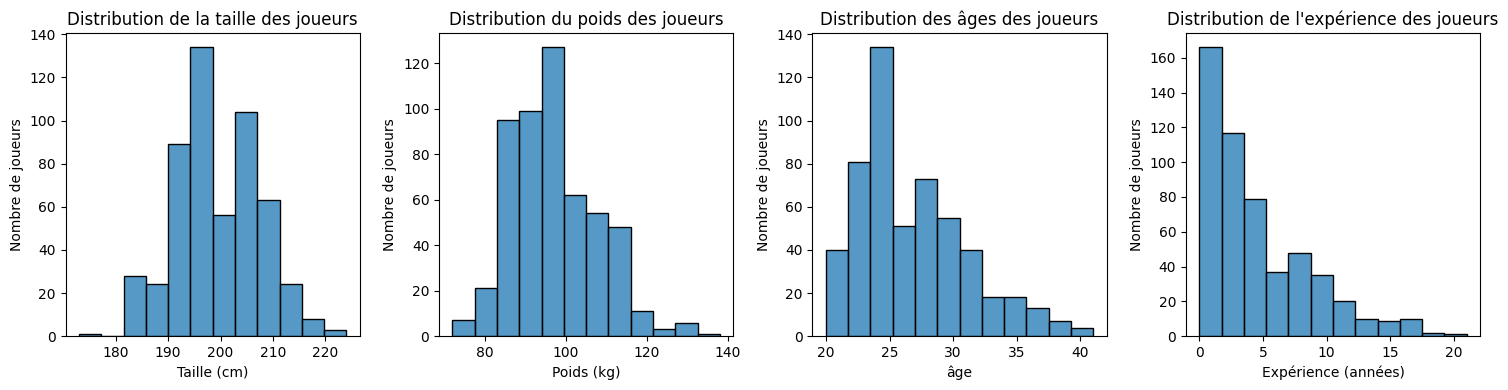

In [535]:
fig, axes = plt.subplots(1, 4, figsize=(15, 4)) # Pour présenter mes graphs sur 1 ligne et deux colonnes 2 colonnes

#Histogramme pour les tailles
sns.histplot(df_player_list['taille'], bins =12,ax=axes[0])
axes[0].set_xlabel('Taille (cm)')
axes[0].set_ylabel('Nombre de joueurs')
axes[0].set_title('Distribution de la taille des joueurs')

#Histogramme pour les poids
sns.histplot(df_player_list['poids'], bins =12, ax=axes[1])
axes[1].set_xlabel('Poids (kg)')
axes[1].set_ylabel('Nombre de joueurs')
axes[1].set_title('Distribution du poids des joueurs')

#Histogramme pour les âges
sns.histplot(df_player_list['âge'], bins =12, ax=axes[2])
axes[2].set_xlabel('âge')
axes[2].set_ylabel('Nombre de joueurs')
axes[2].set_title('Distribution des âges des joueurs')

#Histogramme pour l'exp
sns.histplot(df_player_list['expérience (années)'], bins =12, ax=axes[3])
axes[3].set_xlabel('Expérience (années)')
axes[3].set_ylabel('Nombre de joueurs')
axes[3].set_title("Distribution de l'expérience des joueurs")

plt.tight_layout() # Permet d'éviter que les graphs se chevauchent
plt.show()

####Etude des outliers

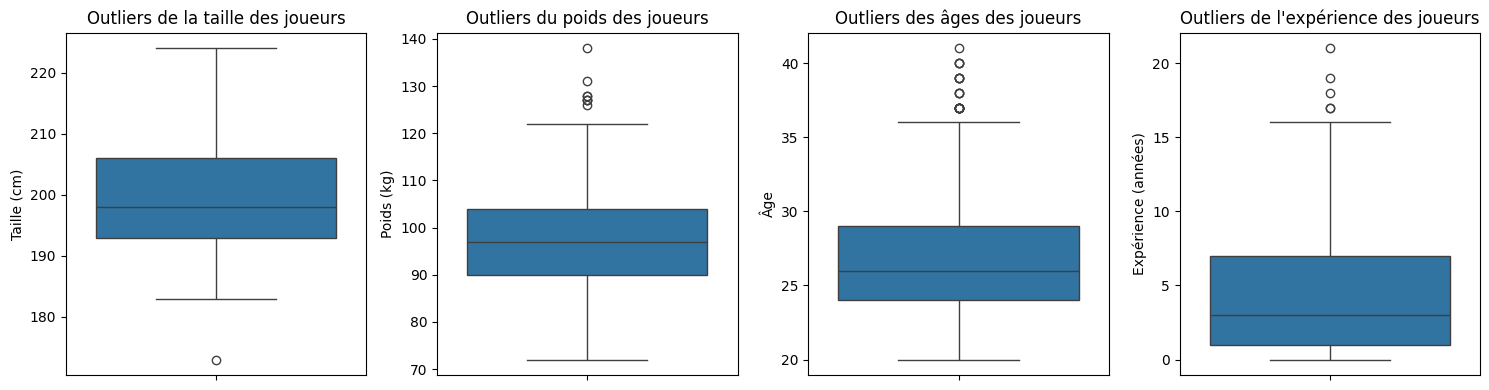

In [536]:
fig, axes = plt.subplots(1, 4, figsize=(15, 4)) # Pour présenter mes graphs sur 1 ligne et deux colonnes 2 colonnes

#Histogramme pour les tailles
sns.boxplot(df_player_list['taille'],ax=axes[0])
axes[0].set_ylabel('Taille (cm)')
axes[0].set_title('Outliers de la taille des joueurs')

#Histogramme pour les poids
sns.boxplot(df_player_list['poids'], ax=axes[1])
axes[1].set_ylabel('Poids (kg)')
axes[1].set_title('Outliers du poids des joueurs')

#Histogramme pour les âges
sns.boxplot(df_player_list['âge'], ax=axes[2])
axes[2].set_ylabel('Âge')
axes[2].set_title('Outliers des âges des joueurs')

#Histogramme pour l'exp
sns.boxplot(df_player_list['expérience (années)'], ax=axes[3])
axes[3].set_ylabel('Expérience (années)')
axes[3].set_title("Outliers de l'expérience des joueurs")

plt.tight_layout() # Permet d'éviter que les graphs se chevauchent
plt.show()

####Profil type d'un joueur de NBA

In [537]:
#Je prends connaissance des statisitques de bases sur les joueurs
df_player_list.describe().T

,count,mean,std,min,25%,50%,75%,max
taille,534.0,199.438202,7.978331,173.0,193.0,198.0,206.0,224.0
poids,534.0,97.046816,10.614853,72.0,90.0,97.0,104.0,138.0
expérience (années),534.0,4.376404,4.201613,0.0,1.0,3.0,7.0,21.0
âge,534.0,26.737828,4.282977,20.0,24.0,26.0,29.0,41.0


In [538]:
print(f"Le profil type d'un joueur de NBA est un homme de {df_player_list['âge'].mean().astype(int)} ans qui mesure {df_player_list['taille'].mean().astype(int)/100} m pour {df_player_list['poids'].mean().astype(int)} kg et qui a {df_player_list['expérience (années)'].mean().astype(int)} d'expérience." )

Le profil type d'un joueur de NBA est un homme de 26 ans qui mesure 1.99 m pour 97 kg et qui a 4 d'expérience.


###Meneurs

In [539]:
df_meneurs_list = df_player_list[df_player_list['position'] == 'Meneur']

####Répartiton des données

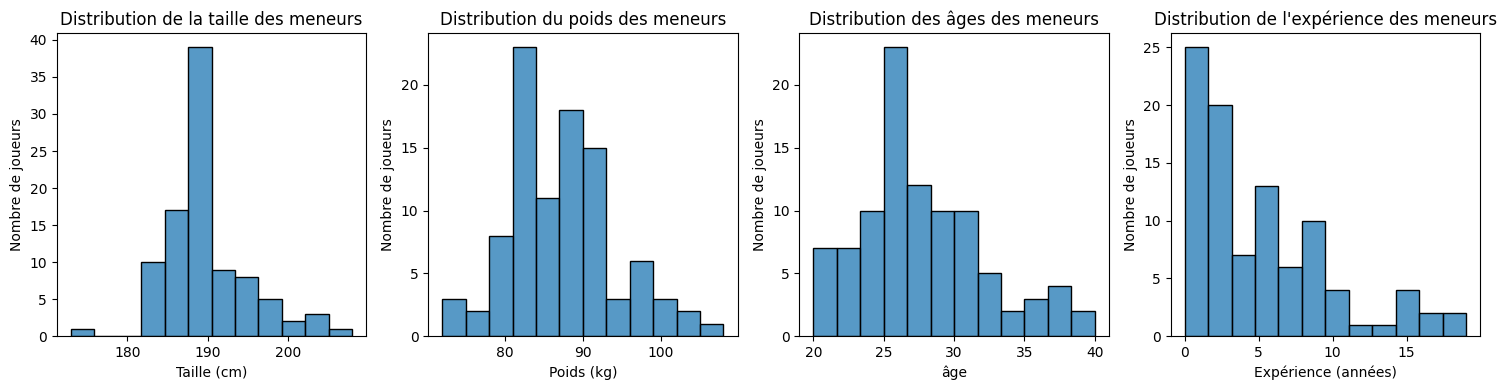

In [540]:
fig, axes = plt.subplots(1, 4, figsize=(15, 4)) # Pour présenter mes graphs sur 1 ligne et deux colonnes 2 colonnes

#Histogramme pour les tailles
sns.histplot(df_meneurs_list['taille'], bins =12,ax=axes[0])
axes[0].set_xlabel('Taille (cm)')
axes[0].set_ylabel('Nombre de joueurs')
axes[0].set_title('Distribution de la taille des meneurs')

#Histogramme pour les poids
sns.histplot(df_meneurs_list['poids'], bins =12, ax=axes[1])
axes[1].set_xlabel('Poids (kg)')
axes[1].set_ylabel('Nombre de joueurs')
axes[1].set_title('Distribution du poids des meneurs')

#Histogramme pour les âges
sns.histplot(df_meneurs_list['âge'], bins =12, ax=axes[2])
axes[2].set_xlabel('âge')
axes[2].set_ylabel('Nombre de joueurs')
axes[2].set_title('Distribution des âges des meneurs')

#Histogramme pour l'exp
sns.histplot(df_meneurs_list['expérience (années)'], bins =12, ax=axes[3])
axes[3].set_xlabel('Expérience (années)')
axes[3].set_ylabel('Nombre de joueurs')
axes[3].set_title("Distribution de l'expérience des meneurs")

plt.tight_layout() # Permet d'éviter que les graphs se chevauchent
plt.show()

####Etude des outliers

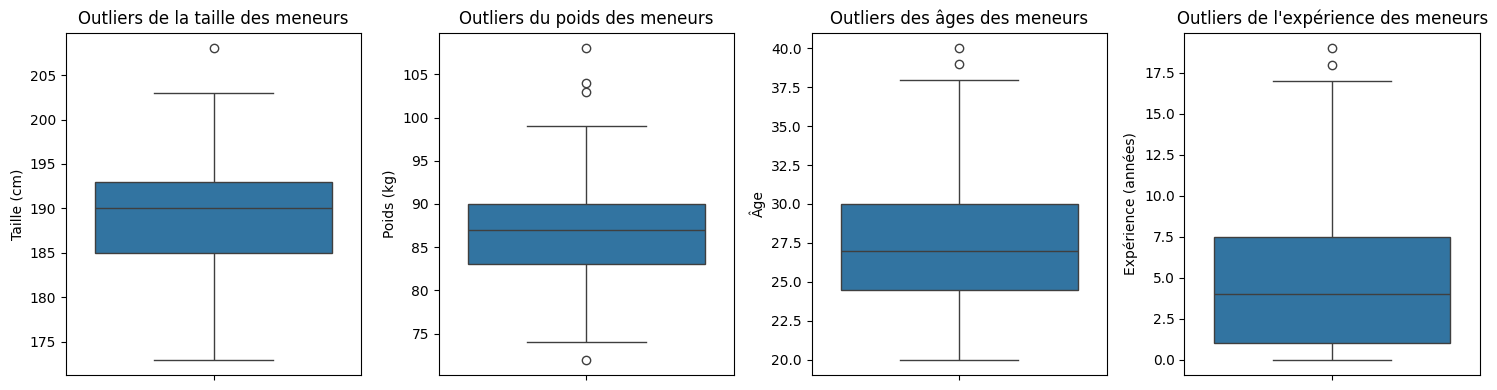

In [541]:
fig, axes = plt.subplots(1, 4, figsize=(15, 4)) # Pour présenter mes graphs sur 1 ligne et deux colonnes 2 colonnes

#Histogramme pour les tailles
sns.boxplot(df_meneurs_list['taille'],ax=axes[0])
axes[0].set_ylabel('Taille (cm)')
axes[0].set_title('Outliers de la taille des meneurs')

#Histogramme pour les poids
sns.boxplot(df_meneurs_list['poids'], ax=axes[1])
axes[1].set_ylabel('Poids (kg)')
axes[1].set_title('Outliers du poids des meneurs')

#Histogramme pour les âges
sns.boxplot(df_meneurs_list['âge'], ax=axes[2])
axes[2].set_ylabel('Âge')
axes[2].set_title('Outliers des âges des meneurs')

#Histogramme pour l'exp
sns.boxplot(df_meneurs_list['expérience (années)'], ax=axes[3])
axes[3].set_ylabel('Expérience (années)')
axes[3].set_title("Outliers de l'expérience des meneurs")

plt.tight_layout() # Permet d'éviter que les graphs se chevauchent
plt.show()

####Profil type du meneur en NBA

In [542]:
#Je prends connaissance de celles des autres meneur
df_meneurs_list.describe().T

,count,mean,std,min,25%,50%,75%,max
taille,95.0,189.852632,5.683063,173.0,185.0,190.0,193.0,208.0
poids,95.0,86.968421,6.731085,72.0,83.0,87.0,90.0,108.0
expérience (années),95.0,5.126316,4.729361,0.0,1.0,4.0,7.5,19.0
âge,95.0,27.568421,4.502133,20.0,24.5,27.0,30.0,40.0


In [543]:
print(f"Le profil type d'un meneur en NBA est un homme de {df_meneurs_list['âge'].mean().astype(int)} ans qui mesure {df_meneurs_list['taille'].mean().astype(int)/100} m pour {df_meneurs_list['poids'].mean().astype(int)} kg et qui a {df_meneurs_list['expérience (années)'].mean().astype(int)} d'expérience." )

Le profil type d'un meneur en NBA est un homme de 27 ans qui mesure 1.89 m pour 86 kg et qui a 5 d'expérience.


###Comparaison des données sur Shai Gilgeous Alexander avec celles des autres meneurs

In [544]:
df_meneurs_taille = df_player_list[df_player_list['position'] == 'Meneur']['taille']

quartiles_taille = df_meneurs_taille.quantile([0.25, 0.5, 0.75])

shai_taille = df_player_list[df_player_list['nom'] == 'Shai Gilgeous Alexander']['taille'].iloc[0]

print(f"Quartiles des tailles des meneurs :")
print(f"  Q1 (25ème percentile) : {quartiles_taille[0.25]:.2f} cm")
print(f"  Q2 (50ème percentile/Médiane) : {quartiles_taille[0.5]:.2f} cm")
print(f"  Q3 (75ème percentile) : {quartiles_taille[0.75]:.2f} cm")

print(f"\nTaille de Shai Gilgeous Alexander : {shai_taille} cm")

if shai_taille < quartiles_taille[0.25]:
    print("Shai Gilgeous-Alexander fait partie des meneurs les plus petits.")
elif shai_taille < quartiles_taille[0.5]:
    print("Shai Gilgeous-Alexander est plus petit que la moyenne des meneurs, sans faire partie des plus petits.")
elif shai_taille < quartiles_taille[0.75]:
    print("Shai Gilgeous-Alexander est plus grand que la moyenne des meneurs, sans faire partie des plus grands.")
else:
    print("Shai Gilgeous-Alexander fait partie des meneurs les plus grands.")

Quartiles des tailles des meneurs :
  Q1 (25ème percentile) : 185.00 cm
  Q2 (50ème percentile/Médiane) : 190.00 cm
  Q3 (75ème percentile) : 193.00 cm

Taille de Shai Gilgeous Alexander : 198.0 cm
Shai Gilgeous-Alexander fait partie des meneurs les plus grands.


In [545]:
df_meneurs_age = df_player_list[df_player_list['position'] == 'Meneur']['âge']

quartiles_age = df_meneurs_age.quantile([0.25, 0.5, 0.75])

shai_age = df_player_list[df_player_list['nom'] == 'Shai Gilgeous Alexander']['âge'].iloc[0]

print(f"Quartiles des âge des meneurs :")
print(f"  Q1 (25ème percentile) : {quartiles_age[0.25]:.2f} ans")
print(f"  Q2 (50ème percentile/Médiane) : {quartiles_age[0.5]:.2f} ans")
print(f"  Q3 (75ème percentile) : {quartiles_age[0.75]:.2f} ans")

print(f"\nÂge de Shai Gilgeous Alexander : {shai_age} ans")

if shai_age < quartiles_age[0.25]:
    print("Shai Gilgeous-Alexander fait partie des meneurs les plus jeunes.")
elif shai_age < quartiles_age[0.5]:
    print("Shai Gilgeous-Alexander est plus jeune que la moyenne des meneurs, sans faire partie des plus jeunes.")
elif shai_age < quartiles_age[0.75]:
    print("Shai Gilgeous-Alexander est plus vieux que la moyenne des meneurs, sans faire partie des plus vieux.")
else:
    print("Shai Gilgeous-Alexander fait partie des meneurs les plus vieux.")

Quartiles des âge des meneurs :
  Q1 (25ème percentile) : 24.50 ans
  Q2 (50ème percentile/Médiane) : 27.00 ans
  Q3 (75ème percentile) : 30.00 ans

Âge de Shai Gilgeous Alexander : 27 ans
Shai Gilgeous-Alexander est plus vieux que la moyenne des meneurs, sans faire partie des plus vieux.


In [546]:
df_meneurs_poids = df_player_list[df_player_list['position'] == 'Meneur']['poids']

quartiles_poids = df_meneurs_age.quantile([0.25, 0.5, 0.75])

shai_poids = df_player_list[df_player_list['nom'] == 'Shai Gilgeous Alexander']['poids'].iloc[0]

print(f"Quartiles des poids des meneurs :")
print(f"  Q1 (25ème percentile) : {quartiles_poids[0.25]:.2f} kg")
print(f"  Q2 (50ème percentile/Médiane) : {quartiles_poids[0.5]:.2f} kg")
print(f"  Q3 (75ème percentile) : {quartiles_poids[0.75]:.2f} kg")

print(f"\nPoids de Shai Gilgeous Alexander : {shai_poids} kg")

if shai_age < quartiles_poids[0.25]:
    print("Shai Gilgeous-Alexander fait partie des meneurs les plus léger.")
elif shai_age < quartiles_poids[0.5]:
    print("Shai Gilgeous-Alexander est plus léger que la moyenne des meneurs, sans faire partie des plus léger.")
elif shai_age < quartiles_poids[0.75]:
    print("Shai Gilgeous-Alexander est plus lourd que la moyenne des meneurs, sans faire partie des plus lourd.")
else:
    print("Shai Gilgeous-Alexander fait partie des meneurs les plus lourd.")

Quartiles des poids des meneurs :
  Q1 (25ème percentile) : 24.50 kg
  Q2 (50ème percentile/Médiane) : 27.00 kg
  Q3 (75ème percentile) : 30.00 kg

Poids de Shai Gilgeous Alexander : 88 kg
Shai Gilgeous-Alexander est plus lourd que la moyenne des meneurs, sans faire partie des plus lourd.


In [547]:
df_meneurs_exp = df_player_list[df_player_list['position'] == 'Meneur']['expérience (années)']

quartiles_exp = df_meneurs_exp.quantile([0.25, 0.5, 0.75])

shai_exp = df_player_list[df_player_list['nom'] == 'Shai Gilgeous Alexander']['expérience (années)'].iloc[0]

print(f"Quartiles des exp des meneurs :")
print(f"  Q1 (25ème percentile) : {quartiles_exp[0.25]:.2f} ans")
print(f"  Q2 (50ème percentile/Médiane) : {quartiles_exp[0.5]:.2f} ans")
print(f"  Q3 (75ème percentile) : {quartiles_exp[0.75]:.2f} ans")

print(f"\nExpérience de Shai Gilgeous Alexander : {shai_exp} ans")

if shai_exp < quartiles_exp[0.25]:
    print("Shai Gilgeous-Alexander fait partie des meneurs les moins expérimentés.")
elif shai_exp < quartiles_exp[0.5]:
    print("Shai Gilgeous-Alexander est moins expérimenté que la moyenne des meneurs, sans faire partie des moins expérimentés.")
elif shai_exp < quartiles_exp[0.75]:
    print("Shai Gilgeous-Alexander est plus expérimenté que la moyenne des meneurs, sans faire partie des plus expérimentés.")
else:
    print("Shai Gilgeous-Alexander fait partie des meneurs les plus expérimentés.")

Quartiles des exp des meneurs :
  Q1 (25ème percentile) : 1.00 ans
  Q2 (50ème percentile/Médiane) : 4.00 ans
  Q3 (75ème percentile) : 7.50 ans

Expérience de Shai Gilgeous Alexander : 6 ans
Shai Gilgeous-Alexander est plus expérimenté que la moyenne des meneurs, sans faire partie des plus expérimentés.


##Analyse des contrats et de la masse salariale

###Prise de connaissances des données

In [548]:
df_contrats.head()

,Player,Team,2024-25,2025-26,2026-27,2027-28,2028-29,2029-30,Guaranteed,Player-additional,Team_code,experience_year,contract_type
0,Stephen Curry,GSW Warriors,55761216,59606817,62587158,0,0,0,177955191,curryst01,GSW,15.0,Supermax
1,Joel Embiid,PHI 76ers,51415938,55224526,57985752,62624612,67263472,0,227250828,embiijo01,PHI,8.0,Supermax
2,Nikola Jokic,DEN Nuggets,51415938,55224526,59033114,62841702,0,0,165673578,jokicni01,DEN,9.0,Supermax
3,Kevin Durant,PHX Suns,51179021,54708609,0,0,0,0,105887630,duranke01,PHX,16.0,Supermax
4,Bradley Beal,PHX Suns,50203930,53666270,57128610,0,0,0,103870200,bealbr01,PHX,12.0,Supermax


In [549]:
df_contrats.describe().T

,count,mean,std,min,25%,50%,75%,max
2024-25,536.0,9.841002e+06,1.220960e+07,11997.0,2087519.0,4445130.5,12571351.50,55761216.0
2025-26,536.0,9.656624e+06,1.377594e+07,0.0,0.0,3048780.0,12990909.50,59606817.0
2026-27,536.0,7.529712e+06,1.412120e+07,0.0,0.0,0.0,7479980.25,62587158.0
2027-28,536.0,5.129150e+06,1.317770e+07,0.0,0.0,0.0,0.00,62841702.0
2028-29,536.0,2.528400e+06,1.046740e+07,0.0,0.0,0.0,0.00,67263472.0
2029-30,536.0,6.927568e+05,5.864810e+06,0.0,0.0,0.0,0.00,71446914.0
Guaranteed,536.0,2.928217e+07,5.163792e+07,11997.0,2087519.0,7155540.0,29383543.50,285393640.0
experience_year,536.0,5.011194e+00,4.229388e+00,0.0,2.0,4.0,7.00,21.0


###Répartition des joueurs par type de contrat

In [550]:
#Je crée une palette de couleur pour la suite de mes visuels
couleurs_thunder= [
    '#007AC1',  # Thunder Blue
    '#00B2EE',  # Sky Blue
    '#F05133',  # Thunder Orange
    '#002D62',  # Dark Navy
    '#89CFF0',  # Light Blue (variation)
    '#FF8C42',  # Soft Orange
    '#1B365D',  # Deep Blue
    '#B0BEC5'   # Light Gray-Blue
]

#Sert à ce que mes pie charts ait la même couleur pour un même nom de catégorie
palette_contrats = {
    'Standard': '#007AC1',     # Bleu Thunder
    'Max': '#00B2EE',      # Bleu clair
    'Rookie Scale': '#F05133',       # Orange
    'Supermax': '#002D62',   # Navy foncé
    'Shai Gilgeous Alexander' : '#B0BEC5'# Light Gray-Blue
}

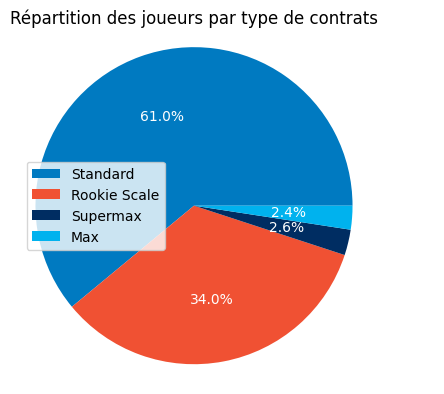

In [551]:
#Pie chart répartition des joueurs par type de contrat
compte_contrats = df_contrats['contract_type'].value_counts()
labels_joueurs = compte_contrats.index
couleurs_joueurs = [palette_contrats[lab] for lab in labels_joueurs]

plt.figure(figsize=(4.5, 4.5))
plt.pie(compte_contrats,
        labels=labels_joueurs,
        autopct='%1.1f%%',
        colors=couleurs_joueurs,
        textprops={'color': 'white'})
plt.legend()
plt.title('Répartition des joueurs par type de contrats')
plt.axis('equal')
plt.show()

###Répartition de la masse salariale par type de contrats pour la saison 2024-2025

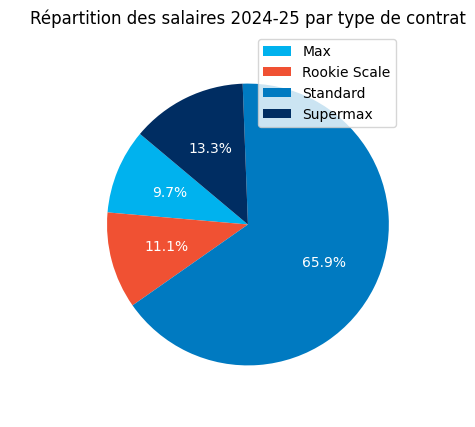

In [552]:
#Répartition de la masse salariale par type de contrat
salary_by_contract_type = df_contrats.groupby('contract_type')['2024-25'].sum()
labels_salaires = salary_by_contract_type.index
couleurs_salaires = [palette_contrats[lab] for lab in labels_salaires]

plt.figure(figsize=(4,5, ))
plt.pie(salary_by_contract_type,
        labels=labels_salaires,
        autopct='%1.1f%%',
        startangle=140,
        colors=couleurs_salaires,
        textprops={'color': 'white'})
plt.title('Répartition des salaires 2024-25 par type de contrat')
plt.legend()
plt.axis('equal')
plt.show()

###Salaire moyen par type de contrat

####Préparation des données

In [553]:
# Calculer le salaire moyen par type de contrat
salaire_moy_contrat = df_contrats.groupby('contract_type')['2024-25'].mean().reset_index()

# Récupérer le salaire de Shai Gilgeous-Alexander pour 2024-25
shai_salary_2024_25 = df_contrats[df_contrats['Player'] == 'Shai Gilgeous Alexander']['2024-25'].iloc[0]

# Renommer la colonne pour plus de clarté
salaire_moy_contrat = salaire_moy_contrat.rename(columns={'2024-25': 'Average Salary 2024-25'})

# Créer un nouveau DataFrame pour Shai avec le même format que salaire_moy_contrat
shai_data = {'contract_type': ['Shai Gilgeous Alexander'], 'Average Salary 2024-25': [shai_salary_2024_25]}
df_shai_salary = pd.DataFrame(shai_data)

# Concaténer les DataFrames pour inclure Shai dans les données du graphique
average_salary_with_shai = pd.concat([salaire_moy_contrat, df_shai_salary], ignore_index=True)

####Formated string sur les salaires moyen

In [554]:
# 2. Créer les chaînes formatées pour les salaires moyens
print(f"Le salaire moyen d'un joueur de NBA pour la saison 2024-25 est de {df_contrats['2024-25'].mean():,.2f}€.")
print("\nSalaires moyens par type de contrat (2024-25):")
for index, row in average_salary_by_contract_type.iterrows(): # Note: On utilise average_salary_by_contract_type ici car les phrases ne concernent que les moyennes par type de contrat
    contract_type = row['contract_type']
    average_salary = row['Average Salary 2024-25']
    print(f"Le salaire moyen pour les contrats {contract_type} est de {average_salary:,.2f} $.") # Utilisation de ,.2f pour formater avec séparateur de milliers

Le salaire moyen d'un joueur de NBA pour la saison 2024-25 est de 9,841,002.32€.

Salaires moyens par type de contrat (2024-25):
Le salaire moyen pour les contrats Max est de 39,534,388.85 $.
Le salaire moyen pour les contrats Rookie Scale est de 3,216,158.85 $.
Le salaire moyen pour les contrats Standard est de 10,625,019.46 $.
Le salaire moyen pour les contrats Supermax est de 50,079,136.93 $.


####Barplot sur les salaires moyens

/tmp/ipython-input-555-2900864449.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='contract_type', y='Average Salary 2024-25', data=average_salary_with_shai, palette=palette_contrats) # Utiliser la palette de couleurs pour mieux distinguer


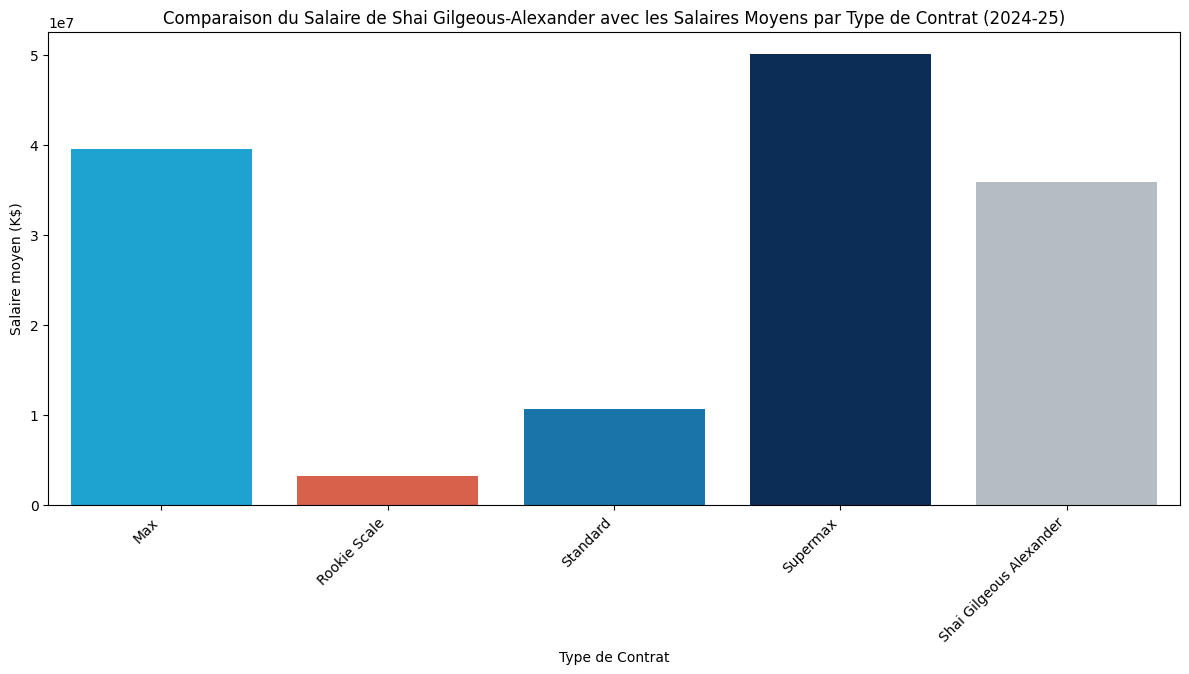

In [555]:
# 3. Créer un graphique à barres

plt.figure(figsize=(12, 7)) # Ajuster la taille de la figure et utiliser average_salary_with_shai
sns.barplot(x='contract_type', y='Average Salary 2024-25', data=average_salary_with_shai, palette=palette_contrats) # Utiliser la palette de couleurs pour mieux distinguer

plt.title('Comparaison du Salaire de Shai Gilgeous-Alexander avec les Salaires Moyens par Type de Contrat (2024-25)')
plt.xlabel('Type de Contrat')
plt.ylabel('Salaire moyen (K$)')
plt.xticks(rotation=45, ha='right') # Rotation des étiquettes pour une meilleure lisibilité
plt.tight_layout() # Ajuste automatiquement les paramètres du subplot
plt.show()

###Comparaison du poids dans la masse salariale de chaque type de contrat comparé à leur poids dans les effectifs

####Formated string de synthèse des situations par types de contrats

In [556]:
# Obtenir les types de contrat uniques
contract_types = df_contrats['contract_type'].unique()

# Nombre total de joueurs (défini une seule fois)
total_players = df_contrats.shape[0]

# Calculer la masse salariale totale pour 2024-25 (une seule fois)
total_salary_2024_25 = df_contrats['2024-25'].sum()

# Boucler sur chaque type de contrat
for contract_type in contract_types:
    # Nombre total de joueurs avec ce type de contrat
    players_of_type = df_contrats[df_contrats['contract_type'] == contract_type].shape[0]

    # Pourcentage de joueurs avec ce type de contrat
    player_percentage = (players_of_type / total_players) * 100

    # Masse salariale des joueurs avec ce type de contrat pour 2024-25
    salary_of_type_2024_25 = df_contrats[df_contrats['contract_type'] == contract_type]['2024-25'].sum()

    # Pourcentage de la masse salariale pour ce type de contrat
    # Éviter la division par zéro si la masse salariale totale est 0
    if total_salary_2024_25 > 0:
        salary_percentage = (salary_of_type_2024_25 / total_salary_2024_25) * 100
    else:
        salary_percentage = 0

    # Créer et afficher la chaîne formatée
    print(f"Les contrats {contract_type} représentent {player_percentage:.2f}% des effectifs pour {salary_percentage:.2f}% de la masse salariale pour la saison 2024-25.\n")

Les contrats Supermax représentent 2.61% des effectifs pour 13.29% de la masse salariale pour la saison 2024-25.

Les contrats Standard représentent 61.01% des effectifs pour 65.87% de la masse salariale pour la saison 2024-25.

Les contrats Max représentent 2.43% des effectifs pour 9.74% de la masse salariale pour la saison 2024-25.

Les contrats Rookie Scale représentent 33.96% des effectifs pour 11.10% de la masse salariale pour la saison 2024-25.



####Comparaison en barplot du poids dans les effectifs et celui dans la masse salariale des différents type de contrats.

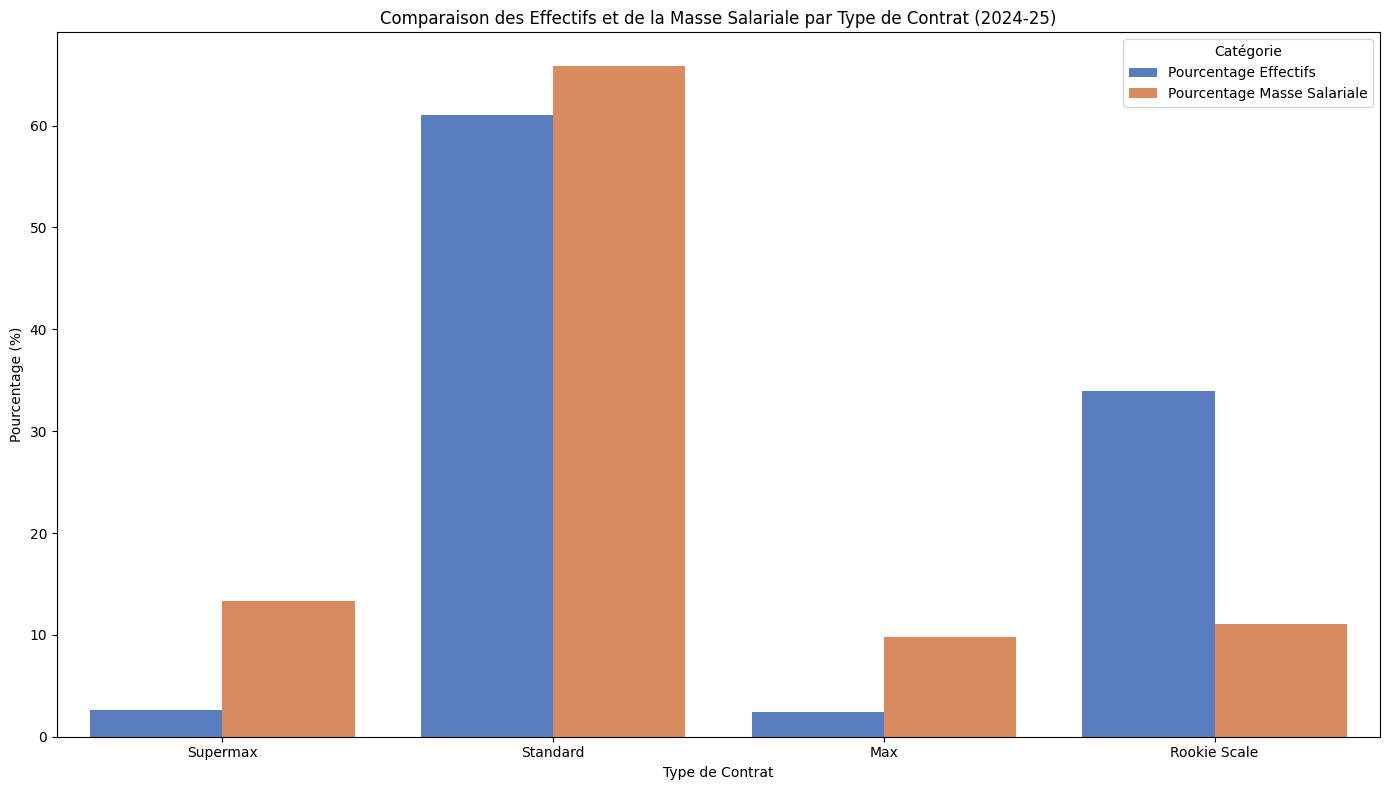

In [557]:
# Liste pour stocker les données des pourcentages pour le graphique
percentage_data_for_viz = []

# Vous avez déjà calculé ces valeurs dans votre boucle précédente
# Nous allons juste les stocker dans un format adapté au graphique

# Obtenir les types de contrat uniques
contract_types = df_contrats['contract_type'].unique()

# Nombre total de joueurs (défini une seule fois)
total_players = df_contrats.shape[0]

# Calculer la masse salariale totale pour 2024-25 (une seule fois)
total_salary_2024_25 = df_contrats['2024-25'].sum()


for contract_type in contract_types:
    # Nombre total de joueurs avec ce type de contrat
    players_of_type = df_contrats[df_contrats['contract_type'] == contract_type].shape[0]

    # Pourcentage de joueurs avec ce type de contrat
    player_percentage = (players_of_type / total_players) * 100

    # Masse salariale des joueurs avec ce type de contrat pour 2024-25
    salary_of_type_2024_25 = df_contrats[df_contrats['contract_type'] == contract_type]['2024-25'].sum()

    # Pourcentage de la masse salariale pour ce type de contrat
    if total_salary_2024_25 > 0:
        salary_percentage = (salary_of_type_2024_25 / total_salary_2024_25) * 100
    else:
        salary_percentage = 0

    # Ajouter les données à la liste dans le format "long"
    percentage_data_for_viz.append({'Type de Contrat': contract_type, 'Catégorie': 'Pourcentage Effectifs', 'Pourcentage': player_percentage})
    percentage_data_for_viz.append({'Type de Contrat': contract_type, 'Catégorie': 'Pourcentage Masse Salariale', 'Pourcentage': salary_percentage})

# Convertir la liste en DataFrame pour la visualisation
df_percentage_viz = pd.DataFrame(percentage_data_for_viz)

# Créer le graphique de barres groupées

plt.figure(figsize=(14, 8)) # Ajuster la taille de la figure
sns.barplot(x='Type de Contrat', y='Pourcentage', hue='Catégorie', data=df_percentage_viz, palette='muted')

plt.title('Comparaison des Effectifs et de la Masse Salariale par Type de Contrat (2024-25)')
plt.xlabel('Type de Contrat')
plt.ylabel('Pourcentage (%)')
plt.legend(title='Catégorie')
plt.tight_layout()
plt.show()

##Etude de corrélation entre le nombre de joueurs en contrat max dans une équipe et le taux de victoire de l'équipe.

###Création d'un df comprenant le nombre de contrat max ou super max par équipe

####Je fais un df avec le nombre de contrat max/supermax par équipe

In [364]:
# Je crée un df avec seulement les contrat 'Max' et 'Supermax'
df_max_supermax = df_contrats[df_contrats['contract_type'].isin(['Max', 'Supermax'])]

# Je fais un Group by par team 'Team' avec count pour avoir le nb de joueur par équipe
df_max_supermax = df_max_supermax.groupby('Team').size().reset_index(name='nb_joueurs')

# Je crée une liste de toutes les équipes présentes dans le df_contrats
all_teams = df_contrats['Team'].unique()

# Je le transforme en dataframe
df_all_teams = pd.DataFrame({'Team': all_teams})

# Je fais une fusion avec mon df all_teams et je mets des 0 pour les valeurs manquantes
df_max_supermax = pd.merge(df_all_teams, df_max_supermax, on='Team', how='left').fillna(0)

# Je convertis le nb_joueurs en integer
df_max_supermax['nb_joueurs'] = df_max_supermax['nb_joueurs'].astype(int)

# J'affiche les infos sur le df
df_max_supermax


,Team,nb_joueurs
0,GSW Warriors,2
1,PHI 76ers,3
2,DEN Nuggets,2
3,PHX Suns,3
4,BOS Celtics,1
5,NYC Knicks,1
6,LAC Clippers,1
7,MIL Bucks,2
8,LAL Lakers,2
9,SAC Kings,0


####Je fusionne avec le df_team_stat pour l'année 2025

In [365]:
#Je fusionne avec le df_team_stat pour l'année 2025
#  Je vérifie les colonnes de chaque table
print("Colonnes df_stats :", df_team_stats[df_team_stats['year']==2025].columns.tolist())
print("Colonnes df_contracts :", df_max_supermax.columns.tolist())

#  Choix de la clé de jointure
#    Par exemple : 'Team' dans df_stats et 'Équipe' dans df_contracts
left_key  = 'Team'     # à adapter si nécessaire
right_key = 'Team'   # à adapter selon le nom exact

#  Jointure
df_max_supermax = pd.merge(
    df_team_stats[df_team_stats['year']==2025],
    df_max_supermax,
    left_on=left_key,
    right_on=right_key,
    how='left'        # ou 'left', 'right', 'outer' selon le besoin

)

#  Résultat
df_max_supermax.info()

Colonnes df_stats : ['Rk', 'Team', 'Conf', 'Div', 'W', 'L', 'W/L%', 'MOV', 'ORtg', 'DRtg', 'NRtg', 'MOV/A', 'ORtg/A', 'DRtg/A', 'NRtg/A', 'year', 'Team code']
Colonnes df_contracts : ['Team', 'nb_joueurs']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Rk          30 non-null     int64  
 1   Team        30 non-null     object 
 2   Conf        30 non-null     object 
 3   Div         30 non-null     object 
 4   W           30 non-null     int64  
 5   L           30 non-null     int64  
 6   W/L%        30 non-null     float64
 7   MOV         30 non-null     float64
 8   ORtg        30 non-null     float64
 9   DRtg        30 non-null     float64
 10  NRtg        30 non-null     float64
 11  MOV/A       30 non-null     float64
 12  ORtg/A      30 non-null     float64
 13  DRtg/A      30 non-null     float64
 14  NRtg/A      30 non-null     fl

####Je conserve seulement les colonnes qui m'interesse

In [366]:
df_max_supermax = df_max_supermax[['Rk','W/L%','nb_joueurs']]
df_max_supermax.sort_values(by='Rk')

,Rk,W/L%,nb_joueurs
0,1,0.829,0
1,2,0.780,1
2,3,0.744,1
3,4,0.598,1
4,5,0.610,1
5,6,0.634,1
6,7,0.585,1
7,8,0.610,2
8,9,0.622,1
9,10,0.585,2


A première vue, il pourrait y avoir une corrélation entre le taux de victoires et la présence de contrat max dans l'équipe car 9 des 10 première équipes en ont au moins un.

###Matrice de corrélation :


*  Est-ce qu'il existe une corrélation entre le nombre victoire et la présence de contrat supermax ou supermax dans l'équipes ?
*  Lorsque l'on a des contrats max est-ce qu'il existe une corrélation entre le nombre de victoire et un nombre plus important de contrat max/supermax ?



####Est-ce qu'il existe une corrélation entre le nombre victoire et la présence de contrat supermax ou supermax dans l'équipes ?

In [367]:
cor_matrix_globale = df_max_supermax[['W/L%','nb_joueurs']].corr()
cor_matrix_globale

,W/L%,nb_joueurs
W/L%,1.000000,0.103334
nb_joueurs,0.103334,1.000000


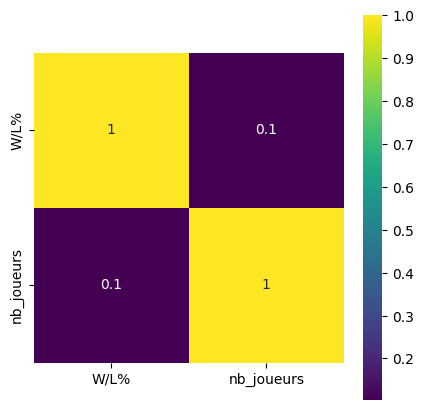

In [368]:
plt.figure(figsize=(5, 5))

sns.heatmap(cor_matrix_globale, # Nos données, ici, la matrice de corrélation
            annot= True,  # Afficher les chiffres
            cmap= 'viridis',  # Choix de la palette de couleur
            square= True) # Bien mettre au carré chaque case
plt.show()

En réalité il n'y a pas de réelle corrélation entre le taux de victoires et le nombre de contrat max ou supermax dans l'équipe.

####Lorsque l'on a des contrats max est-ce qu'il existe une corrélation entre le nombre de victoire et un nombre plus important de contrat max/supermax ?

In [369]:
# pour comparer on se concentre sur les colonnes 'W/L%' et 'nombre_joueurs'.
df_max_corr = df_max_supermax[df_max_supermax['nb_joueurs'] != 0]
df_max_corr

,Rk,W/L%,nb_joueurs
1,2,0.780,1
2,3,0.744,1
3,4,0.598,1
4,5,0.610,1
5,6,0.634,1
6,7,0.585,1
7,8,0.610,2
8,9,0.622,1
9,10,0.585,2
10,11,0.585,2


In [370]:
correlation_matrix = df_max_corr[['W/L%','nb_joueurs']].corr()
correlation_matrix

,W/L%,nb_joueurs
W/L%,1.000000,-0.135664
nb_joueurs,-0.135664,1.000000


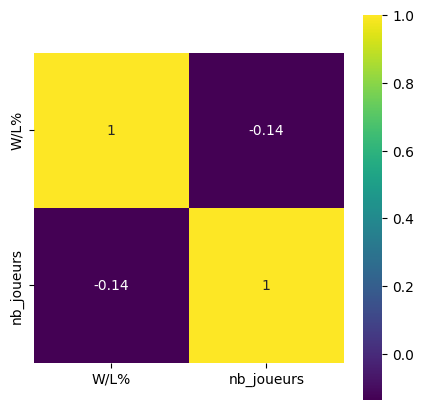

In [371]:
plt.figure(figsize=(5, 5))

sns.heatmap(correlation_matrix,      # Nos données, ici, la matrice de corrélation
            annot= True,  # Afficher les chiffres
            cmap= 'viridis',  # Choix de la palette de couleur
            square= True) # Bien mettre au carré chaque case
plt.show()

##Analyse des statistiques individuelles des joueurs et comparaison avec celles de Shai Gilgeous Alexander

###Profil statistique des joueurs de NBA

Pour définir le profil statistiques type d'un joueur de NBA nous nous appuyerons sur l'analyse des indicateurs suivants :
*   PTS : nombre de points marqué par match en moyenne.
*   AST : nombre de panier marqué grâce à l'action d'un joueur par ses coequipiers.
*   TRB : nombre de rebonds qu’un joueur a captés lorsqu’il était sur le terrain.
*   STL : nombre de possessions adverses terminées par une interception du joueur lorsqu’il était sur le terrain.
*   BLK : nombre de tirs à 2 points adverses bloqués par le joueur lorsqu’il était sur le terrain.
*   PER : Mesure de la production par minute d’un joueur, standardisée pour que la moyenne de la ligue soit de 15.
La moyenne PER de la ligue est toujours fixée à 15.
Un joueur avec un PER > 20 est considéré comme très bon.
Un PER < 10 indique généralement un joueur peu efficace.
*   TS% : Mesure de l’efficacité au tir prenant en compte les tirs à 2 points, les tirs à 3 points et les lancers francs.
*   WS : Estimation du nombre total de victoires auxquelles un joueur a contribué.
*  VORP : Estimation à partir des statistiques de la contribution d’un joueur par rapport à un joueur de remplacement (niveau -2,0), exprimée en points par 100 possessions d’équipe, ajustée à une équipe moyenne et rapportée à une saison de 82 matchs.




####Tableau des stats moyennes par poste

In [372]:
df_profil_stat = df_player_stat[df_player_stat['year'] == 2025]
df_profil_stat = df_profil_stat[['Player','Pos','PTS','AST', 'TRB', 'STL', 'BLK','PER','TS%','WS','BPM','PIS','VORP']]
df_profil_stat.head()

,Player,Pos,PTS,AST,TRB,STL,BLK,PER,TS%,WS,BPM,PIS,VORP
2,Aj Green,Arrière,7.4,1.50,2.4,0.5,0.10,9.20,0.6210,2.8,-2.2,-0.49,-0.10
5,Aj Lawson,Arrière,9.1,1.20,3.3,0.5,0.20,12.70,0.5420,0.8,-2.5,-0.22,-0.10
8,Aj Johnson,Arrière,6.0,2.05,1.7,0.3,0.05,8.75,0.4905,-0.2,-6.6,-0.93,-0.45
11,Aaron Gordon,Ailier fort,14.7,3.20,4.8,0.5,0.30,17.00,0.6500,4.3,1.2,0.67,1.20
14,Aaron Holiday,Meneur,5.5,1.30,1.3,0.3,0.20,12.20,0.5940,2.0,-0.2,-0.03,0.30


In [373]:
# Je fais un dataframe des stats par type de position
df_stats_pos = df_profil_stat.drop(columns=['Player'])
df_stats_pos = df_stats_pos.groupby('Pos').mean()

# On calcule la moyenne de toutes les colonnes numériques (excluant 'Player' et 'Pos')
df_stats_moy = df_profil_stat.drop(columns=['Player', 'Pos']).mean()

# On utilise .to_frame().T pour transformer le resultat en DataFrame d'une ligne
df_stats_moy = df_stats_moy.to_frame().T

# Renommez l'index de cette nouvelle ligne pour indiquer "Général"
df_stats_moy.index = ['Général']

# On concatene avec le df_stats_pos pour ajouter la nouvelle ligne
df_stats_pos = pd.concat([df_stats_pos, df_stats_moy])

# Afficher le résultat pour vérifier
df_stats_pos

,PTS,AST,TRB,STL,BLK,PER,TS%,WS,BPM,PIS,VORP
Ailier,8.462928,1.588318,3.206854,0.619159,0.316822,11.843925,0.537212,1.646106,-2.450467,-0.237103,0.249221
Ailier fort,9.061746,1.735079,4.203175,0.624444,0.451905,13.715714,0.552587,2.143968,-0.967143,0.082667,0.571905
Arrière,8.627667,1.979333,2.541667,0.705333,0.227,11.522333,0.53254,1.807667,-2.195667,-0.246933,0.362333
Meneur,9.854085,3.615033,2.613072,0.824183,0.262908,13.15915,0.531742,2.068137,-1.245915,0.001176,0.64281
Pivot,8.472063,1.566667,5.80873,0.536349,0.81746,16.748413,0.600223,2.993651,0.017778,0.510952,0.810159
Général,8.867926,2.077797,3.589045,0.664323,0.400791,13.245372,0.549307,2.104892,-1.438166,0.00007,0.512654


####Visualisation des profils en radar

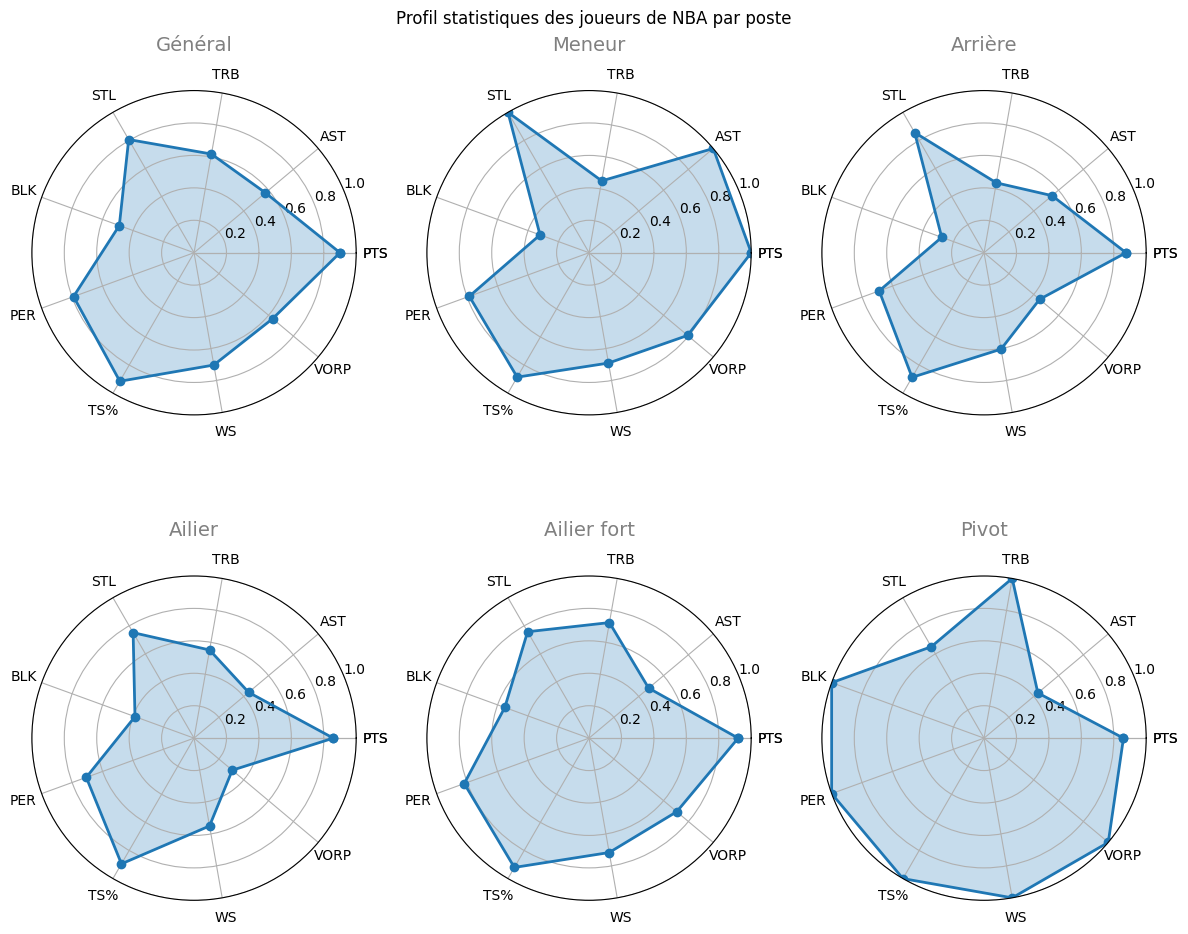

In [374]:
# Sélectionner les statistiques que l'on veut voir sur le graphique
stats_pour_graphique = ['PTS', 'AST', 'TRB', 'STL', 'BLK', 'PER', 'TS%', 'WS', 'VORP']

# Vérifier si ces statistiques existent bien dans notre tableau de statistiques par poste (df_stats_pos)
stats_existantes = [stat for stat in stats_pour_graphique if stat in df_stats_pos.columns]

# Prendre seulement ces statistiques dans un nouveau tableau
stats_selectionnees = df_stats_pos[stats_existantes].copy()

# --- Normalisation des données ---
# Cela va ajuster les valeurs pour qu'elles soient sur la même échelle (entre 0 et 1)
# On divise chaque statistique par la valeur la plus grande pour cette statistique
stats_normalisees = stats_selectionnees / stats_selectionnees.max()

# --- Mise en forme pour le graphique radar ---

# Les noms des statistiques seront les labels de notre graphique (les pointes de l'étoile)
labels_graphique = np.array(stats_existantes)

# Calculer les angles pour placer chaque label autour du cercle
angles_graphique = np.linspace(0, 2 * np.pi, len(labels_graphique), endpoint=False)

# Pour fermer le cercle du graphique radar, on répète le premier angle et le premier label à la fin
angles_graphique = np.concatenate((angles_graphique, [angles_graphique[0]]))
labels_graphique = np.concatenate((labels_graphique, [labels_graphique[0]]))

# --- Création du graphique ---

# On va tracer un graphique pour chaque poste qu'on veut comparer
# On définit ici la liste des postes à afficher, y compris la moyenne générale ("Général")
postes_a_afficher = ['Général', 'Meneur', 'Arrière', 'Ailier', 'Ailier fort', 'Pivot']

# On prépare l'espace pour les graphique en faisant une grille de 2 lignes et 3 colonnes
fig, axes = plt.subplots(figsize=(12, 10), nrows=2, ncols=3, subplot_kw=dict(polar=True))

# On organise les espaces de graphiques pour pouvoir les utiliser facilement un par un
axes = axes.flatten()

# --- Tracer chaque poste sur son graphique ---

# On fait une boucle sur chaque poste
for i, poste in enumerate(postes_a_afficher):
    # On récupère les données normalisées pour le poste actuel
    # On prend la ligne qui correspond à ce poste dans notre tableau normalisé
    donnees_poste = stats_normalisees.loc[poste].values

    # On répète la première valeur à la fin pour fermer le cercle du graphique
    donnees_poste = np.concatenate((donnees_poste, [donnees_poste[0]]))

    # On utilise l'espace graphique correspondant (axes[i]) pour tracer le graphique radar
    ax = axes[i]

    # On trace la ligne du radar pour ce poste
    ax.plot(angles_graphique, donnees_poste, 'o-', linewidth=2,  label=poste)

    # On remplit la zone sous la ligne du radar avec une couleur légère
    ax.fill(angles_graphique, donnees_poste, alpha=0.25)

    # On met les labels des statistiques sur les pointes du radar
    ax.set_thetagrids(angles_graphique * 180 / np.pi, labels_graphique)

    # On définit le titre de ce graphique avec le nom du poste
    ax.set_title(poste, size=14, color='grey', y=1.1)

    # On règle les limites des axes pour que le graphique aille de 0 à 1 (car on a normalisé)
    ax.set_ylim(0, 1) # Les valeurs normalisées vont de 0 à 1

# --- Afficher les graphiques ---

# On ajuste l'espace entre les graphiques pour qu'ils ne se chevauchent pas
plt.tight_layout()

#On choisit un titre global
plt.suptitle("Profil statistiques des joueurs de NBA par poste")

# On affiche tous les graphiques créés
plt.show()

###Statistiques de Shai Gilgeous Alexander et evolution sur les 3 dernières années

In [375]:
#On selectionne les stats qui nous interesse
Stats_of_Shai = df_player_stat[df_player_stat['Player'] == 'Shai Gilgeous Alexander']
Stats_of_Shai['prod_plus']= (
    Stats_of_Shai['PTS']+ Stats_of_Shai['TRB'] + Stats_of_Shai['AST'] + Stats_of_Shai['STL'] + Stats_of_Shai['BLK']
)
Stats_of_Shai

/tmp/ipython-input-375-3900141672.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Stats_of_Shai['prod_plus']= (


,Age,G,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,TS%,WS,WS/48,BPM,VORP,Player,Player-additional,Pos,PIS,prod_plus
1454,24.0,68.0,35.5,10.4,20.3,0.510,0.9,2.5,0.345,9.5,...,0.626,11.4,0.226,7.3,5.6,Shai Gilgeous Alexander,gilgesh01,Meneur,2.93,44.3
1455,25.0,75.0,34.0,10.6,19.8,0.535,1.3,3.6,0.353,9.3,...,0.636,14.6,0.275,9.0,7.1,Shai Gilgeous Alexander,gilgesh01,Meneur,3.47,44.7
1456,26.0,76.0,34.2,11.3,21.8,0.519,2.1,5.7,0.375,9.2,...,0.637,16.7,0.309,11.5,8.9,Shai Gilgeous Alexander,gilgesh01,Meneur,4.49,46.8


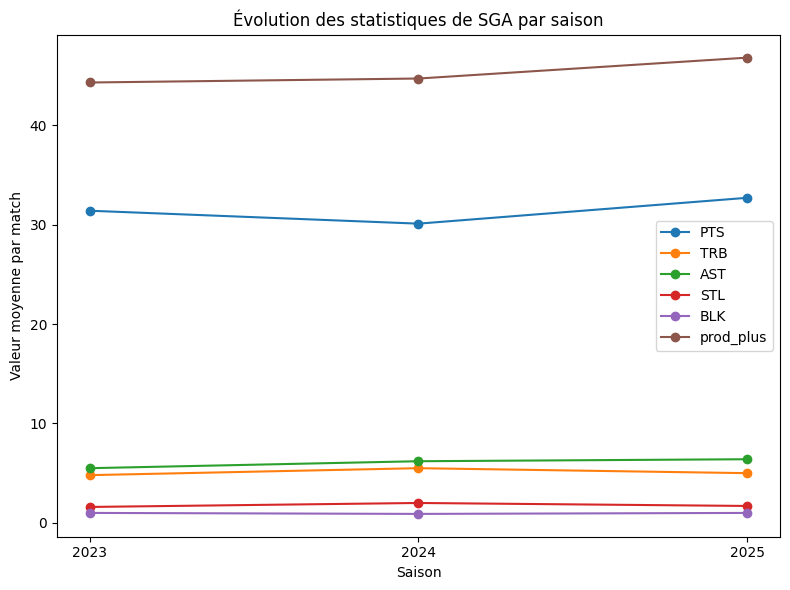

In [376]:
#Visualisation des données
# Liste des stats à tracer
stats_list = ['PTS', 'TRB', 'AST', 'STL', 'BLK', 'prod_plus']

plt.figure(figsize=(8, 6))

# Tracer chaque statistique
for stat in stats_list:
    plt.plot(Stats_of_Shai['year'], Stats_of_Shai[stat], marker='o', label=stat)

# Mise en forme du graphique
plt.title("Évolution des statistiques de SGA par saison")
plt.xlabel("Saison")
plt.ylabel("Valeur moyenne par match")
plt.xticks([2023, 2024, 2025])
plt.legend()
#plt.grid(True)
plt.tight_layout()
plt.show()

On voit donc une légère évolution à la hausse grace à la stat 'prod_plus'. Evolution légère mais l'ensemble stable dans le haut niveau.

In [377]:
# On filtre sur shai
Stats_of_Shai.sort_values(by='year')

# On prend les stats de 2023 et 2025
stats_2023 = Stats_of_Shai[Stats_of_Shai['year'] == 2023].iloc[0]
stats_2025 = Stats_of_Shai[Stats_of_Shai['year'] == 2025].iloc[0]

# On selectionne les colonnes souhaitées
stats_cols = ['PTS', 'TRB', 'AST', 'STL', 'BLK','PIS', 'prod_plus']

# On crée les formated string
print("Taux d'évolution pour Shai Gilgeous Alexander (2023 à 2025):")
for col in stats_cols:
    value_2023 = stats_2023[col]
    value_2025 = stats_2025[col]
    percentage_change = ((value_2025 - value_2023) / value_2023) * 100
    print(f"Le taux d'évolution de son {col} est de {percentage_change:.2f} % entre 2023 et 2025.")


Taux d'évolution pour Shai Gilgeous Alexander (2023 à 2025):
Le taux d'évolution de son PTS est de 4.14 % entre 2023 et 2025.
Le taux d'évolution de son TRB est de 4.17 % entre 2023 et 2025.
Le taux d'évolution de son AST est de 16.36 % entre 2023 et 2025.
Le taux d'évolution de son STL est de 6.25 % entre 2023 et 2025.
Le taux d'évolution de son BLK est de 0.00 % entre 2023 et 2025.
Le taux d'évolution de son PIS est de 53.24 % entre 2023 et 2025.
Le taux d'évolution de son prod_plus est de 5.64 % entre 2023 et 2025.


###Comparaison des statistiques de Shai Gilgeous Alexander avec celles des autres meneurs en NBA

####Comparaison sur les statistiques basiques par match

In [378]:
df_player_stat['year'] = df_player_stat['year'].astype(int)

# 2. Filtrer pour tous les meneurs (PG) puis celle de Shai:
df_pg = df_player_stat[df_player_stat['Pos'] == 'Meneur']
Shai = df_player_stat[df_player_stat['Player'] == 'Shai Gilgeous Alexander']

# 3. Définir les colonnes à agréger
cols = ['PTS', '2P%', '3P%', 'AST', 'TRB', 'STL', 'BLK']

# 4. Calculer la moyenne par année des PG et celles de Shai :
moy_par_annee_PG = df_pg.groupby('year')[cols].mean().reset_index()
moy_par_annee_Shai = Shai.groupby('year')[cols].mean().reset_index()

# 5. Afficher le résultat
print(moy_par_annee_PG)

print(moy_par_annee_Shai)

   year        PTS       2P%       3P%       AST       TRB       STL       BLK
0  2023  10.604255  0.475011  0.329612  3.948404  2.743085  0.806915  0.243085
1  2024   9.424127  0.480193  0.332828  3.488254  2.541587  0.718571  0.231587
2  2025   9.854085  0.493630  0.336940  3.615033  2.613072  0.824183  0.262908
   year   PTS    2P%    3P%  AST  TRB  STL  BLK
0  2023  31.4  0.533  0.345  5.5  4.8  1.6  1.0
1  2024  30.1  0.576  0.353  6.2  5.5  2.0  0.9
2  2025  32.7  0.571  0.375  6.4  5.0  1.7  1.0


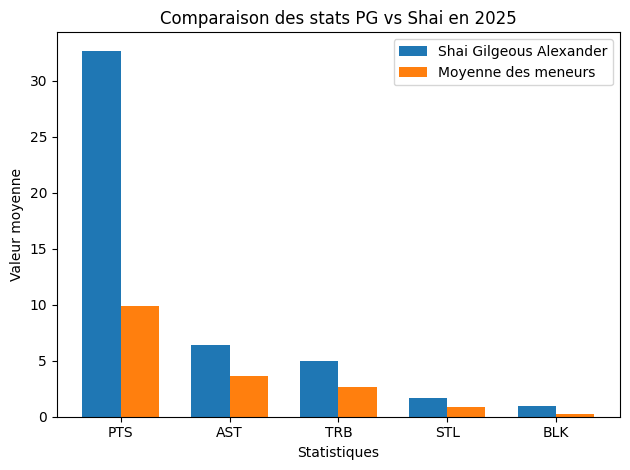

In [379]:
# Choisir l'année à comparer
year = 2025  # ou toute autre saison présente dans vos données

# Statistiques à afficher
stats_select = ['PTS','AST', 'TRB', 'STL', 'BLK']

# Filtrer les PG et SGA pour l'année choisie
df_PG = df_player_stat[(df_player_stat['Pos'] == 'Meneur')& (df_player_stat['year'] == year)]
df_sga = df_player_stat[(df_player_stat['Player'] == 'Shai Gilgeous Alexander') & (df_player_stat['year'] == year)]

# Calculer les moyennes
avg_pg  = df_PG[stats_select].mean()
avg_sga = df_sga[stats_select].mean()

# Paramétrer le bar chart groupé
x     = np.arange(len(stats_select))
width = 0.35

plt.figure()
plt.bar(x - width/2, avg_sga, width, label='Shai Gilgeous Alexander')
plt.bar(x + width/2, avg_pg,  width, label='Moyenne des meneurs')

# Mise en forme
plt.xticks(x, stats_select)
plt.xlabel('Statistiques')
plt.ylabel('Valeur moyenne')
plt.title(f'Comparaison des stats PG vs Shai en {year}')
plt.legend()
plt.tight_layout()
plt.show()

On constate que les statistiques par match de Shai Gilgeous Alexander sont bien superieures à celles de la moyenne des autres meneurs.
Voyons ce que ça donne sur les statistiques avancés.

####Comparatison sur les statistiques avancées

In [380]:
# 2. Filtrer pour tous les meneurs (PG) puis celle de Shai:
df_pg = df_player_stat[df_player_stat['Pos'] == 'Meneur']
Shai = df_player_stat[df_player_stat['Player'] == 'Shai Gilgeous Alexander']

# 3. Définir les colonnes à agréger
stats_adv_select = ['PER','TS%','WS','BPM','VORP']

# 4. Calculer la moyenne par année des PG et celles de Shai :
moy_par_annee_adv_PG = df_pg.groupby('year')[stats_adv_select].mean().reset_index()
moy_par_annee_adv_Shai = Shai.groupby('year')[stats_adv_select].mean().reset_index()

# 5. Afficher le résultat
print(moy_par_annee_adv_PG)
print(moy_par_annee_adv_Shai)

   year        PER       TS%        WS       BPM      VORP
0  2023  13.261170  0.526527  2.340426 -1.246809  0.804255
1  2024  12.659048  0.520058  2.167302 -1.975238  0.716032
2  2025  13.159150  0.531742  2.068137 -1.245915  0.642810
   year   PER    TS%    WS   BPM  VORP
0  2023  27.2  0.626  11.4   7.3   5.6
1  2024  29.3  0.636  14.6   9.0   7.1
2  2025  30.7  0.637  16.7  11.5   8.9


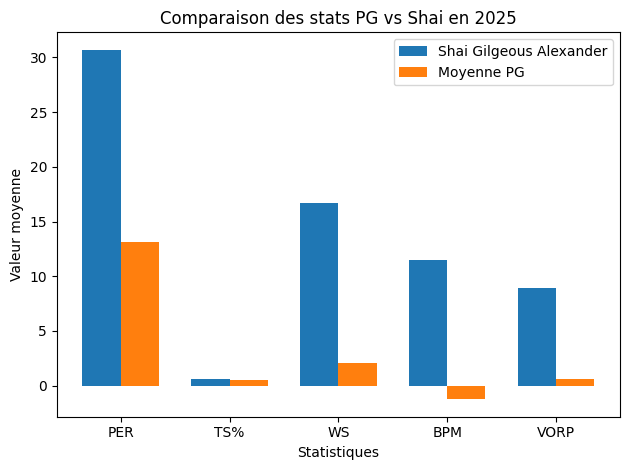

In [381]:
# Choisir l'année à comparer
year = 2025  # ou toute autre saison présente dans vos données

# Statistiques à afficher
stats2 = ['PER','TS%','WS','BPM','VORP']

# Filtrer les PG et SGA pour l'année choisie
df_PG= df_player_stat[(df_player_stat['Pos'] == 'Meneur')& (df_player_stat['year'] == year)]
df_sga = df_player_stat[(df_player_stat['Player'] == 'Shai Gilgeous Alexander') & (df_player_stat['year'] == year)]

# Calculer les moyennes
avg_pg  = df_PG[stats2].mean()
avg_sga = df_sga[stats2].mean()

# Paramétrer le bar chart groupé
x     = np.arange(len(stats2))
width = 0.35

plt.figure()
plt.bar(x - width/2, avg_sga, width, label='Shai Gilgeous Alexander')
plt.bar(x + width/2, avg_pg,  width, label='Moyenne PG')

# Mise en forme
plt.xticks(x, stats2)
plt.xlabel('Statistiques')
plt.ylabel('Valeur moyenne')
plt.title(f'Comparaison des stats PG vs Shai en {year}')
plt.legend()
plt.tight_layout()
plt.show()

Même constat sur les statistiques avancés.

####Comparaison de l'évolution sur 3 ans de Shai Gilgeous Alexander et des meneurs

#####Etude sur le prod +

In [382]:
#On ajoute la colonne 'prod_plus' dans le Dataframe 'player_stat' pour visualiser l'évolution du meneur moyen et celle de Shai.
df_player_stat['prod_plus']= (
    df_player_stat['PTS']+ df_player_stat['TRB'] + df_player_stat['AST'] + df_player_stat['STL'] + df_player_stat['BLK']
)
df_player_stat.head()

,Age,G,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,TS%,WS,WS/48,BPM,VORP,Player,Player-additional,Pos,PIS,prod_plus
0,23.0,35.0,9.9,1.50,3.60,0.424,1.30,3.0,0.419,0.3,...,0.607,0.80,0.111,-0.9,0.10,Aj Green,greenaj01,Arrière,-0.17,6.50
1,24.0,56.0,11.0,1.50,3.50,0.423,1.20,3.0,0.408,0.3,...,0.617,1.10,0.084,-2.1,0.00,Aj Green,greenaj01,Arrière,-0.27,6.40
2,25.0,73.0,22.7,2.50,5.80,0.429,2.10,5.0,0.427,0.4,...,0.621,2.80,0.082,-2.2,-0.10,Aj Green,greenaj01,Arrière,-0.49,11.90
3,22.0,7.5,4.8,1.25,2.05,0.744,0.35,0.9,0.400,0.9,...,0.790,0.05,0.217,0.3,-0.05,Aj Lawson,lawsoaj01,Arrière,1.0,4.25
4,23.0,42.0,7.4,1.30,2.90,0.446,0.30,1.2,0.260,1.0,...,0.519,0.20,0.036,-4.6,-0.20,Aj Lawson,lawsoaj01,Arrière,-0.39,5.20


In [383]:
df_player_stat['year'] = df_player_stat['year'].astype(int)

# 2. Filtrer pour tous les meneurs (PG) puis celle de Shai:
df_pg = df_player_stat[df_player_stat['Pos'] == 'Meneur']
Shai = df_player_stat[df_player_stat['Player'] == 'Shai Gilgeous Alexander']

# 3. Définir les colonnes à agréger
col = ['prod_plus']

# 4. Calculer la prod plus par année des PG et celles de Shai :
prod_plus_PG = df_pg.groupby('year')[col].mean().reset_index()
prod_plus_Shai = Shai.groupby('year')[col].mean().reset_index()

# 5. Afficher le résultat
print(prod_plus_PG)
print(prod_plus_Shai)

   year  prod_plus
0  2023  18.345745
1  2024  16.404127
2  2025  17.169281
   year  prod_plus
0  2023       44.3
1  2024       44.7
2  2025       46.8


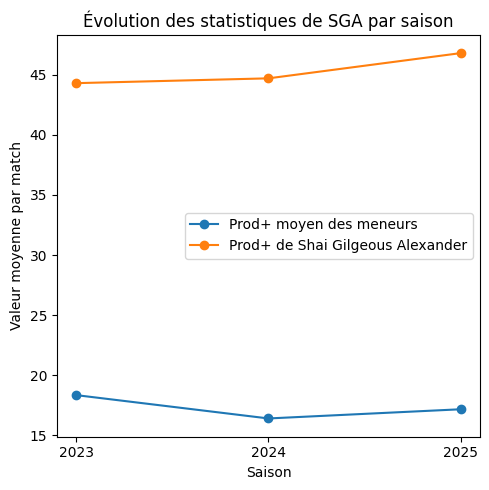

In [384]:
# Liste des stats à tracer
statis = ['prod_plus']

plt.figure(figsize=(5, 5))

# Tracer chaque statistique
for stat in statis:
    plt.plot(prod_plus_PG['year'], prod_plus_PG[stat], marker='o', label='Prod+ moyen des meneurs')
    plt.plot(prod_plus_Shai['year'], prod_plus_Shai[stat], marker='o', label='Prod+ de Shai Gilgeous Alexander')

# Mise en forme du graphique
plt.title("Évolution des statistiques de SGA par saison")
plt.xlabel("Saison")
plt.ylabel("Valeur moyenne par match")
plt.xticks([2023, 2024, 2025])
plt.legend()
#plt.grid(True)
plt.tight_layout()
plt.show()

L'écart est abyssal. Regardons ce que ca donne avec des boxplot par année.

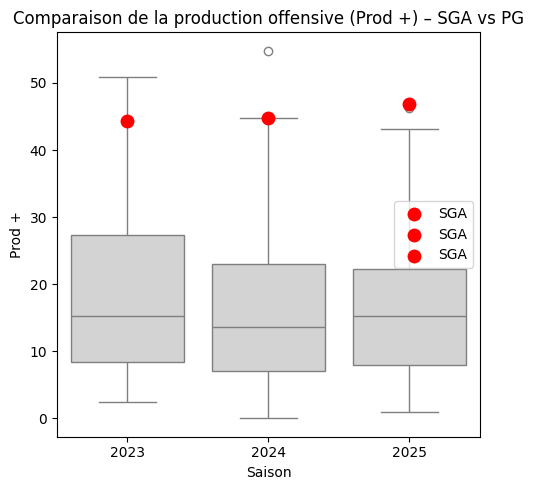

In [385]:
plt.figure(figsize=(5, 5))

# Boxplots par saison
sns.boxplot(data=df_pg, x='year', y='prod_plus', color='lightgray')

# Ajouter SGA par-dessus en rouge
sga_stats = df_player_stat[df_player_stat['Player'] == 'Shai Gilgeous Alexander']
sns.stripplot(data=sga_stats, x='year', y='prod_plus', color='red', size=10, label="SGA")


# Titre et axes
plt.title("Comparaison de la production offensive (Prod +) – SGA vs PG")
plt.xlabel("Saison")
plt.ylabel("Prod +")
plt.legend()
plt.tight_layout()
plt.show()

On peut qualifier ses performances d'extrêmes et elles le deviennent de plus en plus.

#####Etude sur le PIS

   year       PIS
0  2023  0.042872
1  2024  0.025048
2  2025  0.001176
   year   PIS
0  2023  2.93
1  2024  3.47
2  2025  4.49


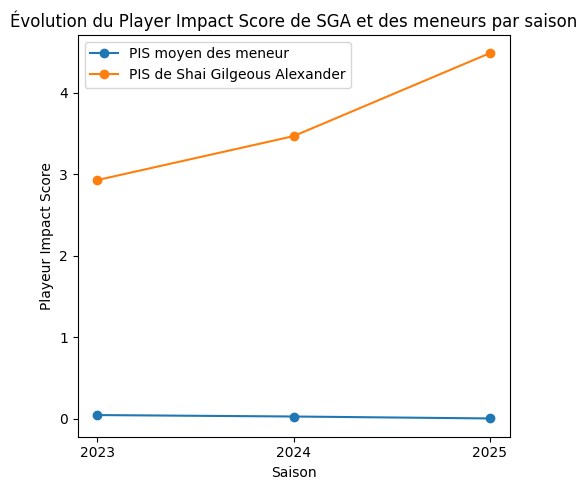

In [386]:
# 2. Filtrer pour tous les meneurs (PG) puis celle de Shai:
df_pg = df_player_stat[df_player_stat['Pos'] == 'Meneur']
Shai = df_player_stat[df_player_stat['Player'] == 'Shai Gilgeous Alexander']

# 3. Définir les colonnes à agréger
col = ['PIS']

# 4. Calculer la prod plus par année des PG et celles de Shai :
pis_PG = df_pg.groupby('year')[col].mean().reset_index()
pis_Shai = Shai.groupby('year')[col].mean().reset_index()

# 5. Afficher le résultat
print(pis_PG)
print(pis_Shai)

# Liste des stats à tracer
statis_pis = ['PIS']

plt.figure(figsize=(5, 5))

# Tracer chaque statistique
for stat in statis_pis:
    plt.plot(pis_PG['year'], pis_PG[stat], marker='o', label='PIS moyen des meneur')
    plt.plot(pis_Shai['year'], pis_Shai[stat], marker='o', label='PIS de Shai Gilgeous Alexander')

# Mise en forme du graphique
plt.title("Évolution du Player Impact Score de SGA et des meneurs par saison")
plt.xlabel("Saison")
plt.ylabel("Playeur Impact Score")
plt.xticks([2023, 2024, 2025])
plt.legend()
#plt.grid(True)
plt.tight_layout()
plt.show()

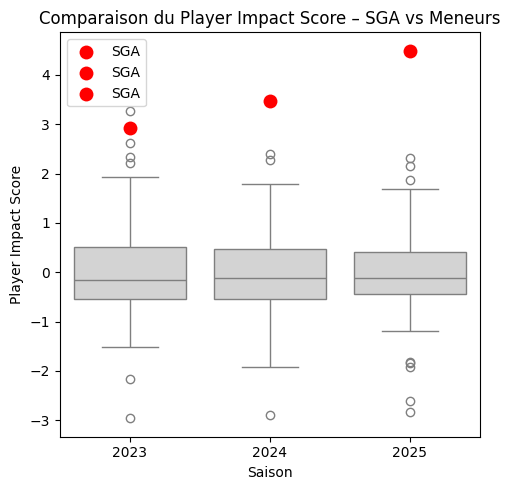

In [387]:
plt.figure(figsize=(5, 5))

# Boxplots par saison
sns.boxplot(data=df_pg, x='year', y='PIS', color='lightgray')

# Ajouter SGA par-dessus en rouge
sga_stats = df_player_stat[df_player_stat['Player'] == 'Shai Gilgeous Alexander']
sns.stripplot(data=sga_stats, x='year', y='PIS', color='red', size=10, label="SGA")


# Titre et axes
plt.title("Comparaison du Player Impact Score – SGA vs Meneurs")
plt.xlabel("Saison")
plt.ylabel("Player Impact Score")
plt.legend()
plt.tight_layout()
plt.show()

###Comparaison des statistiques de Shai Gilgeous Alexander avec une selection des meilleurs joueurs actifs en NBA

In [388]:
df_PGallstar = df_player_stat[df_player_stat['Player'].isin(['Luka Doncic','Stephen Curry','Damian Lillard','Jalen Brunson','Shai Gilgeous Alexander'])]
df_PGallstar['PIS'] = df_PGallstar['PIS'].astype(float)

/tmp/ipython-input-388-2740409248.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_PGallstar['PIS'] = df_PGallstar['PIS'].astype(float)


In [389]:
#Nous allons prendre les meilleurs meneurs sur les trois dernières années.
colonne_ = df_PGallstar.select_dtypes(include="number").columns.tolist()

In [390]:
#Nous faisons en suite la moyenne des 3 derniers pour chaques joueurs.
df_PGallstarmoy = (
    df_PGallstar
    .groupby("Player")[colonne_]
    .mean(numeric_only=True)      # moyenne sur chaque colonne numérique
    .reset_index()
)
#Suppression de la colonne année
df_PGallstarmoy.drop('year', axis=1, inplace=True)
df_PGallstarmoy

,Player,Age,G,MP,FG,FGA,FG%,3P,3PA,3P%,...,PF,PTS,PER,TS%,WS,WS/48,BPM,VORP,PIS,prod_plus
0,Damian Lillard,33.0,63.000000,35.900000,8.233333,18.433333,0.445000,3.533333,9.600000,0.367000,...,1.800000,27.133333,22.533333,0.618667,8.100000,0.174333,4.400000,3.600000,1.856667,40.166667
1,Jalen Brunson,27.0,70.000000,35.266667,9.300000,19.166667,0.486000,2.333333,5.866667,0.400000,...,2.066667,26.233333,22.066667,0.598000,9.400000,0.181667,4.333333,4.000000,1.930000,37.366667
2,Luka Doncic,24.0,53.666667,36.366667,10.566667,22.066667,0.478000,3.466667,9.466667,0.363500,...,2.366667,31.483333,26.950000,0.604333,8.383333,0.194500,8.500000,5.516667,2.750000,50.633333
3,Shai Gilgeous Alexander,25.0,73.000000,34.566667,10.766667,20.633333,0.521333,1.433333,3.933333,0.357667,...,2.500000,31.400000,29.066667,0.633000,14.233333,0.270000,9.266667,7.200000,3.630000,45.266667
4,Stephen Curry,35.0,66.666667,33.200000,8.966667,19.233333,0.463667,4.700000,11.466667,0.410667,...,1.700000,26.766667,22.066667,0.630000,7.633333,0.167333,6.333333,4.633333,2.096667,38.866667


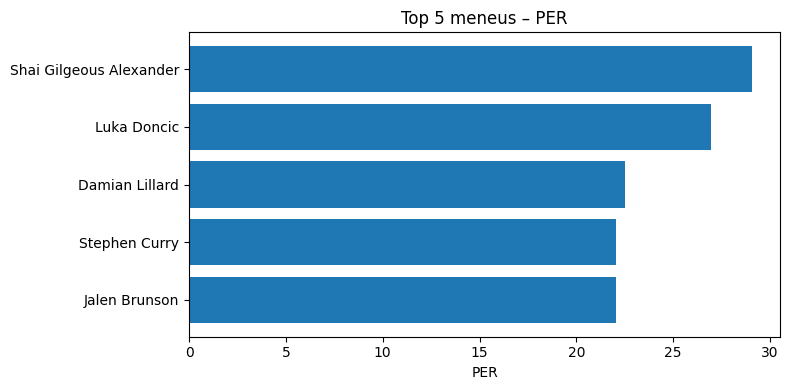

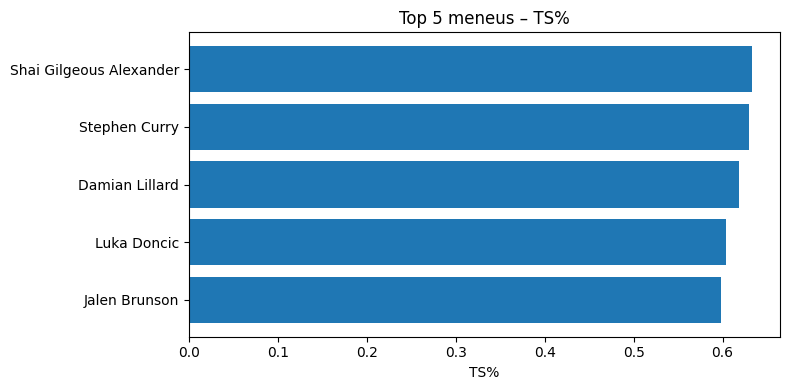

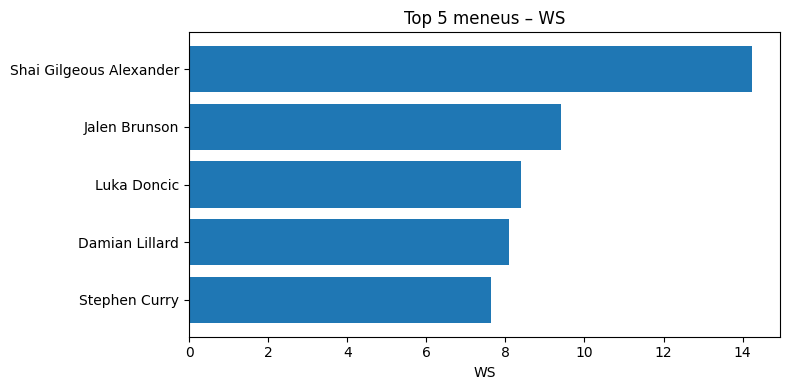

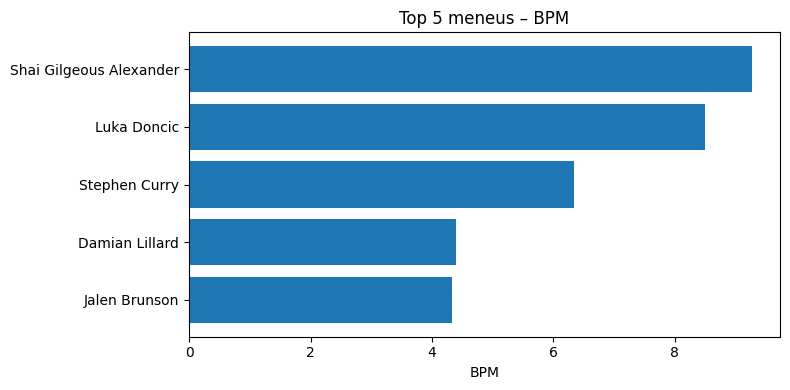

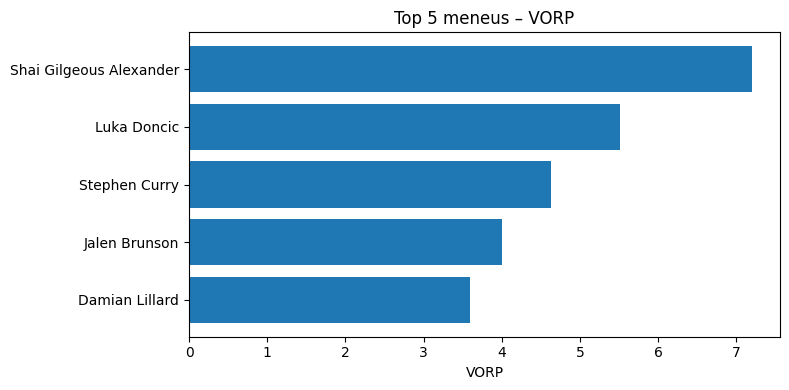

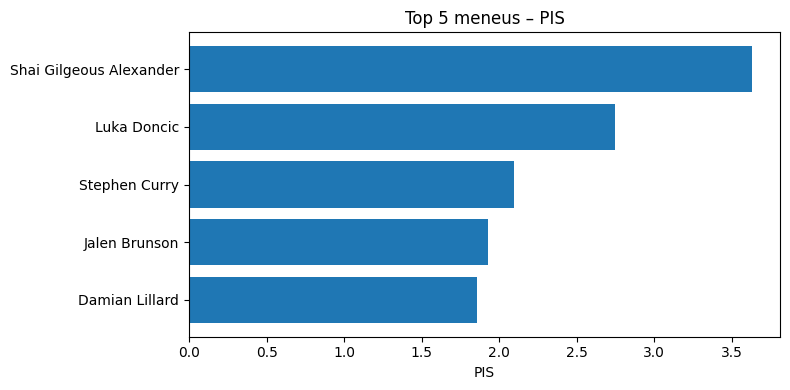

In [391]:
# Visualisation en bar plot

# Liste des métriques à tracer
metrics = ["PER", "TS%", "WS", "BPM", "VORP",'PIS']

# Pour chaque métrique, on prend les 5 plus grands et on trace un barplot horizontal
for metric in metrics:
    # Sélection Top 5
    top5 = df_PGallstarmoy.nlargest(5, metric).sort_values(metric)

    # Figure dédiée
    plt.figure(figsize=(8, 4))
    plt.barh(top5["Player"], top5[metric])
    plt.xlabel(metric)
    plt.title(f"Top 5 meneus – {metric}")
    plt.tight_layout()
    plt.show()

Même en prenant les meilleurs joueurs à son poste, SGA fait la différence en étant premier dans chaque catégorie.

##Analyse statistiques des contrats max

###AB test pour vérifier si il existe une différence statistique entre l'avant et l'après signature des joueurs ayant signé un contrat max


*   H0 : Il n'y a pas de différence statistique significative sur l'indicateur étudié avant et après la signature du contrat
*   Il existe une différence statistique significative sur l'indicateur étudié avant et après signature du contrat



####Sur le PER

In [392]:
df_per = df_contrat_max[df_contrat_max["PER"].notna() & df_contrat_max["annee_signature"].notna()]
per_avg = df_per.groupby(["Player", "Apres_Contrat"])["PER"].mean().unstack().dropna()

# Test t apparié
t_stat_per, p_value_per = stats.ttest_rel(per_avg[0], per_avg[1])

if p_value_per < 0.05:
    print(f"La p-value étant de {p_value_per}, nous pouvons rejeter H0.\nIl existe une différence statistique significative sur le PER avant et après signature du contrat.")
    if per_avg[0].mean() > per_avg[1].mean() :
     print(f"- Le PER des joueur diminue après la signature d'un contrat max")
    else:
     print(f"- Le PER des joueur augmente après la signature d'un contrat max")

else:
    print(f"La p-value étant de {p_value_per}, nous ne pouvons pas rejeter H0.\nIl n'y a pas de différence statistique significative sur le PER avant et après la signature du contrat.")

La p-value étant de 0.8072914783693802, nous ne pouvons pas rejeter H0.
Il n'y a pas de différence statistique significative sur le PER avant et après la signature du contrat.


####Sur le VORP

In [393]:
df_vorp = df_contrat_max[df_contrat_max["VORP"].notna() & df_contrat_max["annee_signature"].notna()]
vorp_avg = df_per.groupby(["Player", "Apres_Contrat"])["VORP"].mean().unstack().dropna()

# Test t apparié
t_stat_vorp, p_value_vorp = stats.ttest_rel(vorp_avg[0], vorp_avg[1])

if p_value_vorp < 0.05:
    print(f"La p-value étant de {p_value_vorp}, nous pouvons rejeter H0.\nIl existe une différence statistique significative sur le VORP avant et après signature du contrat.")
    if vorp_avg[0].mean() > vorp_avg[1].mean() :
     print(f"- Le VORP des joueur diminue après la signature d'un contrat max")
    else:
     print(f"- Le VORP des joueur augmente après la signature d'un contrat max")

else:
    print(f"La p-value étant de {p_value_vorp}, nous ne pouvons pas rejeter H0.\nIl n'y a pas de différence statistique significative sur le VORP avant et après la signature du contrat.")

La p-value étant de 0.22429092324231742, nous ne pouvons pas rejeter H0.
Il n'y a pas de différence statistique significative sur le VORP avant et après la signature du contrat.


####Sur le WS

In [394]:
df_ws = df_contrat_max[df_contrat_max["WS"].notna() & df_contrat_max["annee_signature"].notna()]
ws_avg = df_ws.groupby(["Player", "Apres_Contrat"])["WS"].mean().unstack().dropna()

# Test t apparié
t_stat_ws, p_value_ws = stats.ttest_rel(ws_avg[0], ws_avg[1])

if p_value_ws < 0.05:
    print(f"La p-value étant de {p_value_ws}, nous pouvons rejeter H0.\nIl existe une différence statistique significative sur le WS avant et après signature du contrat.")
    if ws_avg[0].mean() > ws_avg[1].mean() :
     print(f"- Le WS des joueur diminue après la signature d'un contrat max")
    else:
     print(f"- Le WS des joueur augmente après la signature d'un contrat max")

else:
    print(f"La p-value étant de {p_value_ws}, nous ne pouvons pas rejeter H0.\nIl n'y a pas de différence statistique significative sur le WS avant et après la signature du contrat.")

La p-value étant de 0.03352957955085201, nous pouvons rejeter H0.
Il existe une différence statistique significative sur le WS avant et après signature du contrat.
- Le WS des joueur diminue après la signature d'un contrat max


####Malgré l'absence de différence significative entre les performances avant et après signature nous décidons de pousser malgré tout l'analyse.

###Comparaison du PER avant et après signature

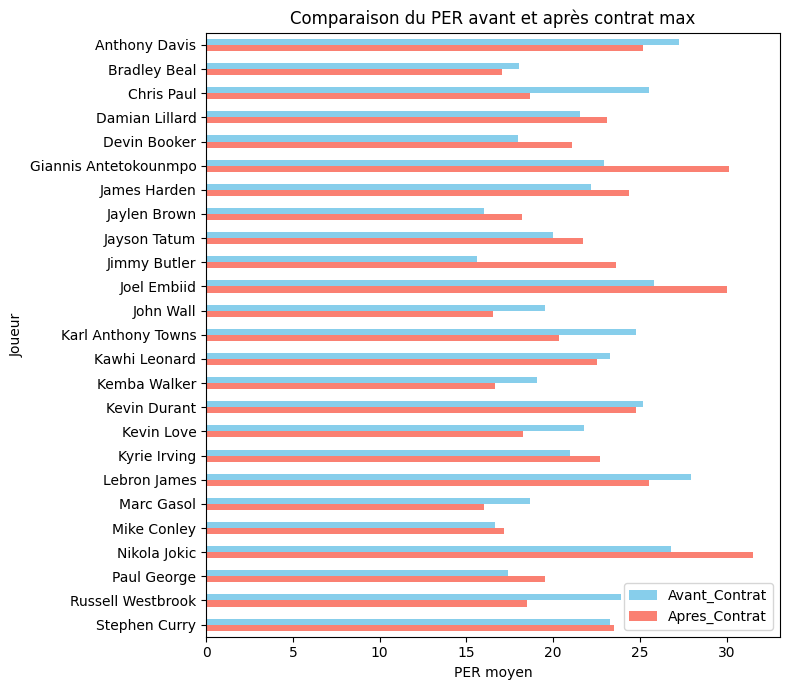

In [395]:
per_comparaison = (
    df_per.groupby(["Player", "Apres_Contrat"])["PER"].mean().unstack().dropna()
    .rename(columns={0: "Avant_Contrat", 1: "Apres_Contrat"})
)
per_comparaison["Diff"] = per_comparaison["Apres_Contrat"] - per_comparaison["Avant_Contrat"]

# Graphique
per_comparaison[["Avant_Contrat", "Apres_Contrat"]].plot(
    kind="barh", figsize=(8, 7), color=["skyblue", "salmon"]
)
plt.title("Comparaison du PER avant et après contrat max")
plt.xlabel("PER moyen")
plt.ylabel("Joueur")
plt.legend(loc="lower right")
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

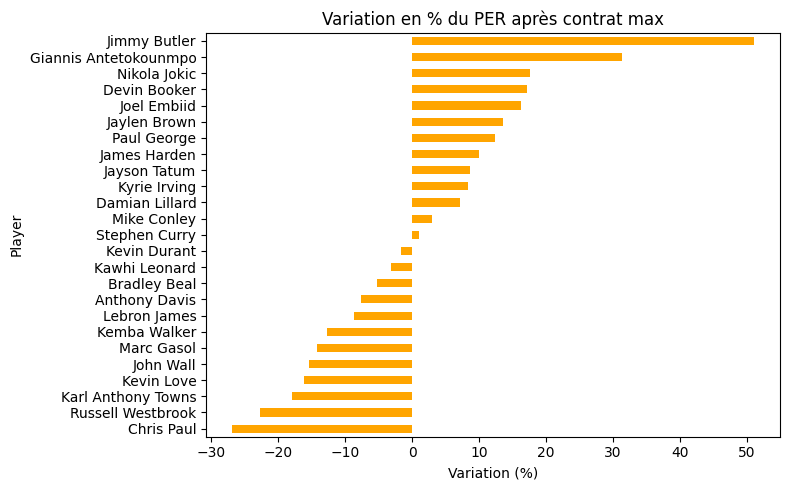

In [396]:
# Variation %
per_comparaison["Variation_%"] = (
    (per_comparaison["Apres_Contrat"] - per_comparaison["Avant_Contrat"]) /
    per_comparaison["Avant_Contrat"]
) * 100
per_comparaison["Variation_%"].sort_values(ascending=False).plot(kind="barh", figsize=(8, 5), color="orange")
plt.title("Variation en % du PER après contrat max")
plt.xlabel("Variation (%)")
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

In [397]:
# 1. Calculer le nombre de joueurs avec augmentation du PER
augmentation_per = per_comparaison[per_comparaison["Variation_%"] > 0].shape[0]

# 2. Calculer le nombre de joueurs avec diminution du PER
diminution_per = per_comparaison[per_comparaison["Variation_%"] < 0].shape[0]

# Exclure les variations nulles si vous ne voulez pas les inclure dans les pourcentages d'augmentation/diminution
total_joueurs_variation = augmentation_per + diminution_per

# 3. Calculer les pourcentages
pourcentage_augmentation = (augmentation_per / total_joueurs_variation) * 100
pourcentage_diminution = (diminution_per / total_joueurs_variation) * 100

# 4. Créer la formatted string
print(f"Après la signature de leur contrat, {pourcentage_augmentation:.2f}% des joueurs ont vu leur PER augmenter.")
if per_comparaison["Variation_%"].mean() < 0:
    print(f"Après la signature de leur contrat, le PER des joueurs a diminué de {per_comparaison['Variation_%'].mean()} en moyenne.")
else:
    print(f"Après la signature de leur contrat, le PER des joueurs a augmenté de {per_comparaison['Variation_%'].mean().round()} % en moyenne.")

Après la signature de leur contrat, 52.00% des joueurs ont vu leur PER augmenter.
Après la signature de leur contrat, le PER des joueurs a augmenté de 2.0 % en moyenne.


###Comparaison du VORP avant et après signature

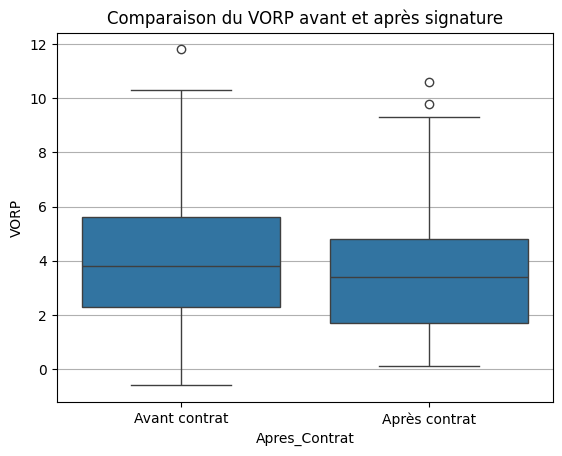

In [398]:
# Boxplot
sns.boxplot(data=df_vorp, x="Apres_Contrat", y="VORP")
plt.title("Comparaison du VORP avant et après signature")
plt.xticks([0, 1], ['Avant contrat', 'Après contrat'])
plt.ylabel("VORP")
plt.grid(True, axis='y')
plt.show()

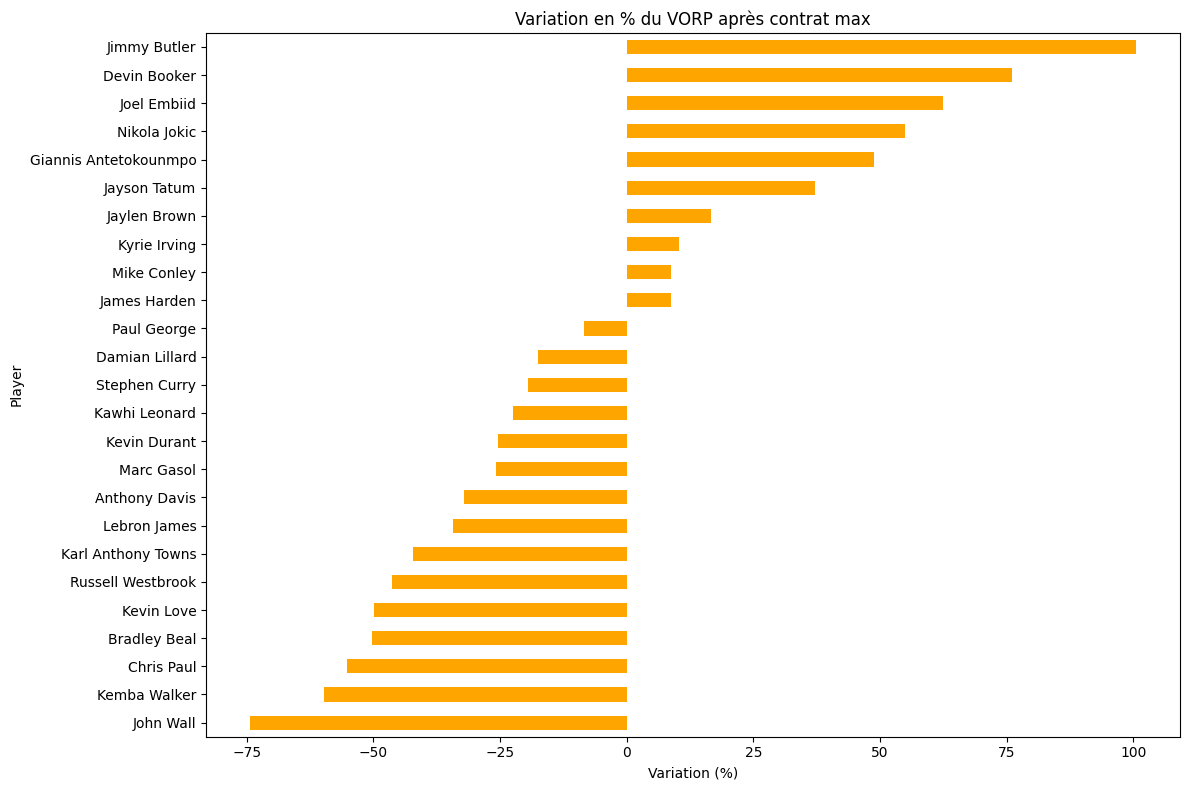

In [399]:
vorp_comparaison = df_vorp.groupby(["Player", "Apres_Contrat"])["VORP"].mean().unstack().dropna()
vorp_comparaison.columns = ["Avant_Contrat", "Apres_Contrat"]
vorp_comparaison["Variation_%"] = (
    (vorp_comparaison["Apres_Contrat"] - vorp_comparaison["Avant_Contrat"]) /
    vorp_comparaison["Avant_Contrat"]
) * 100

vorp_comparaison.sort_values("Variation_%", ascending=False)["Variation_%"].plot(kind="barh", figsize=(12, 8), color="orange")
plt.title("Variation en % du VORP après contrat max")
plt.xlabel("Variation (%)")
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

###Comparaison du WS avant et après signature

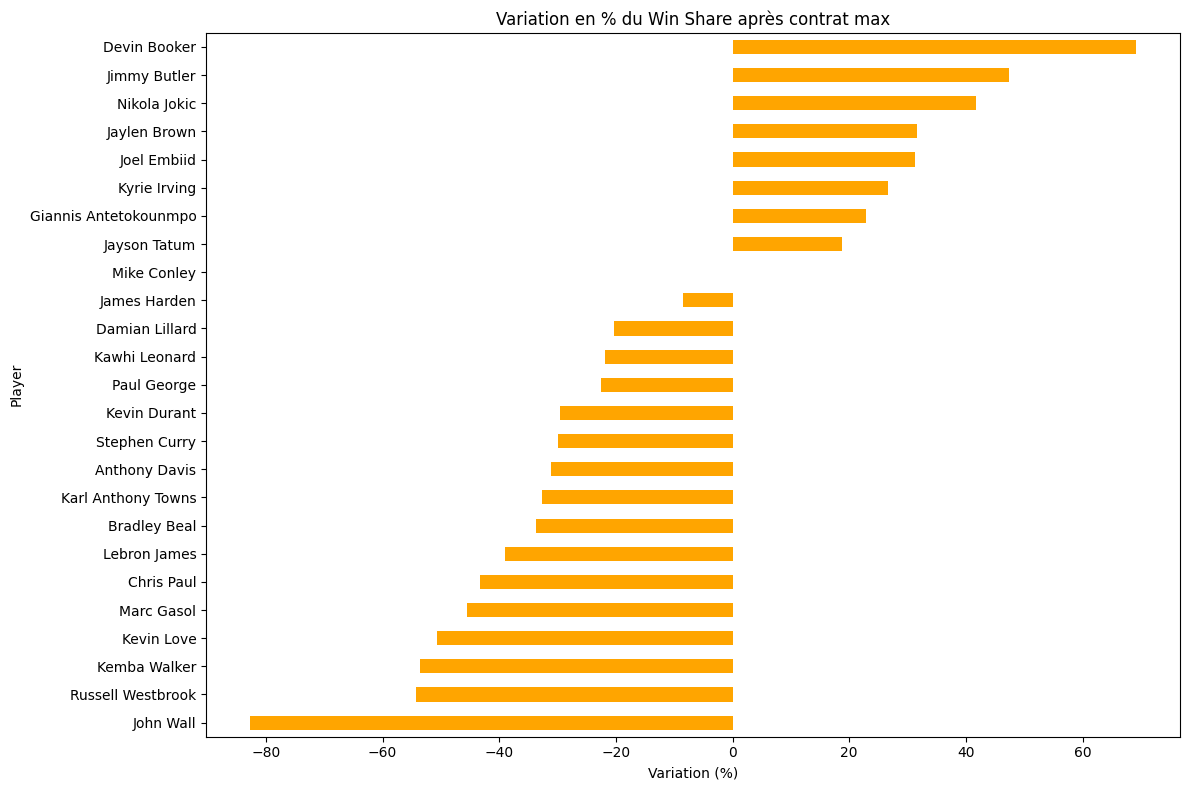

In [400]:
ws_comparaison = df_ws.groupby(["Player", "Apres_Contrat"])["WS"].mean().unstack().dropna()
ws_comparaison.columns = ["Avant_Contrat", "Apres_Contrat"]
ws_comparaison["Variation_%"] = (
    (ws_comparaison["Apres_Contrat"] - ws_comparaison["Avant_Contrat"]) /
    ws_comparaison["Avant_Contrat"]
) * 100

ws_comparaison.sort_values("Variation_%", ascending=False)["Variation_%"].plot(kind="barh", figsize=(12, 8), color="orange")
plt.title("Variation en % du Win Share après contrat max")
plt.xlabel("Variation (%)")
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

In [401]:
ws_comparaison

,Avant_Contrat,Apres_Contrat,Variation_%
Player,,,
Anthony Davis,10.375000,7.140000,-31.180723
Bradley Beal,4.880000,3.233333,-33.743169
Chris Paul,12.684615,7.185714,-43.350949
Damian Lillard,10.042857,8.000000,-20.341394
Devin Booker,4.257143,7.200000,69.127517
Giannis Antetokounmpo,9.185714,11.280000,22.799378
James Harden,11.400000,10.425000,-8.552632
Jaylen Brown,4.214286,5.550000,31.694915
Jayson Tatum,8.000000,9.500000,18.750000


###Age moyen à la signature du contrat

In [402]:
df_max_age_sign = df_contrat_max[['Player','Age_signature']]
df_max_age_sign.drop_duplicates(inplace=True)

/tmp/ipython-input-402-2563926188.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_max_age_sign.drop_duplicates(inplace=True)


In [403]:
print(f"L'âge moyen à la signature d'un contrat max est de {df_max_age_sign['Age_signature'].mean()}.")

L'âge moyen à la signature d'un contrat max est de 27.88.


###Analyse standardisée des performances des joueurs avant et après la signature d'un contrat max

Âge moyen à la signature : 27.88
Écart d'âge moyen : -1.207977207977208


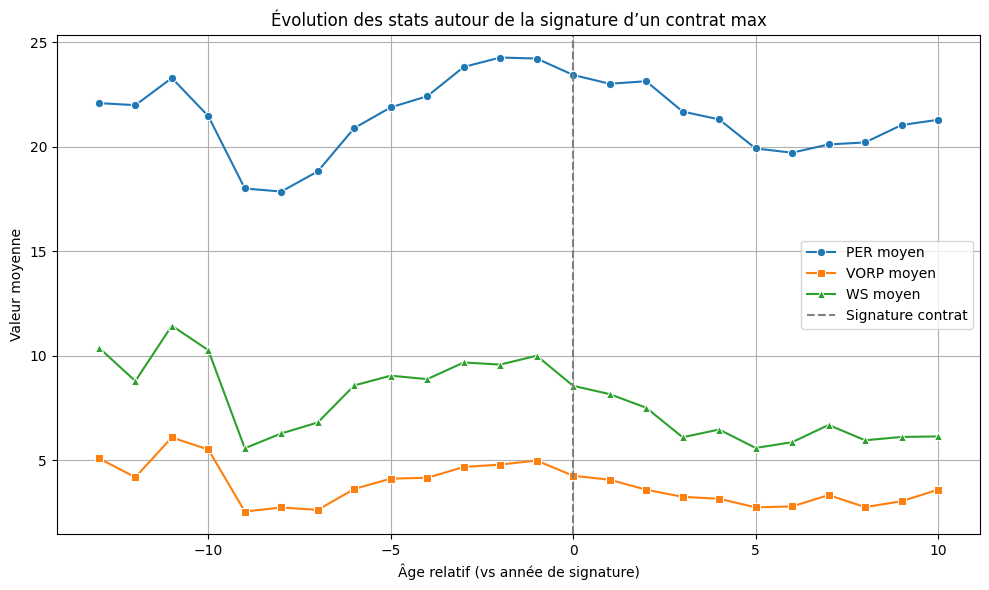

In [404]:
# Moyenne de l'âge au moment du contrat
print("Âge moyen à la signature :", df_max_age_sign["Age_signature"].mean())

# Calcul de l'écart d'âge par rapport à la signature
df_contrat_max["Ecart_Age"] = df_contrat_max["Age"] - df_contrat_max["Age_signature"]
print("Écart d'âge moyen :", df_contrat_max["Ecart_Age"].mean())

# Calcul des moyennes statistiques par écart d’âge
df_stats = df_contrat_max[["Ecart_Age", "PER", "VORP", "WS"]].dropna()
df_moyennes = df_stats.groupby("Ecart_Age", as_index=False).mean()

# Tracer l'évolution des stats autour de la signature
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_moyennes, x="Ecart_Age", y="PER", label="PER moyen", marker="o")
sns.lineplot(data=df_moyennes, x="Ecart_Age", y="VORP", label="VORP moyen", marker="s")
sns.lineplot(data=df_moyennes, x="Ecart_Age", y="WS", label="WS moyen", marker="^")
plt.axvline(x=0, linestyle="--", color="gray", label="Signature contrat")
plt.title("Évolution des stats autour de la signature d’un contrat max")
plt.xlabel("Âge relatif (vs année de signature)")
plt.ylabel("Valeur moyenne")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


###Comparaison de la moyenne des principaux indicateurs avant et après signature

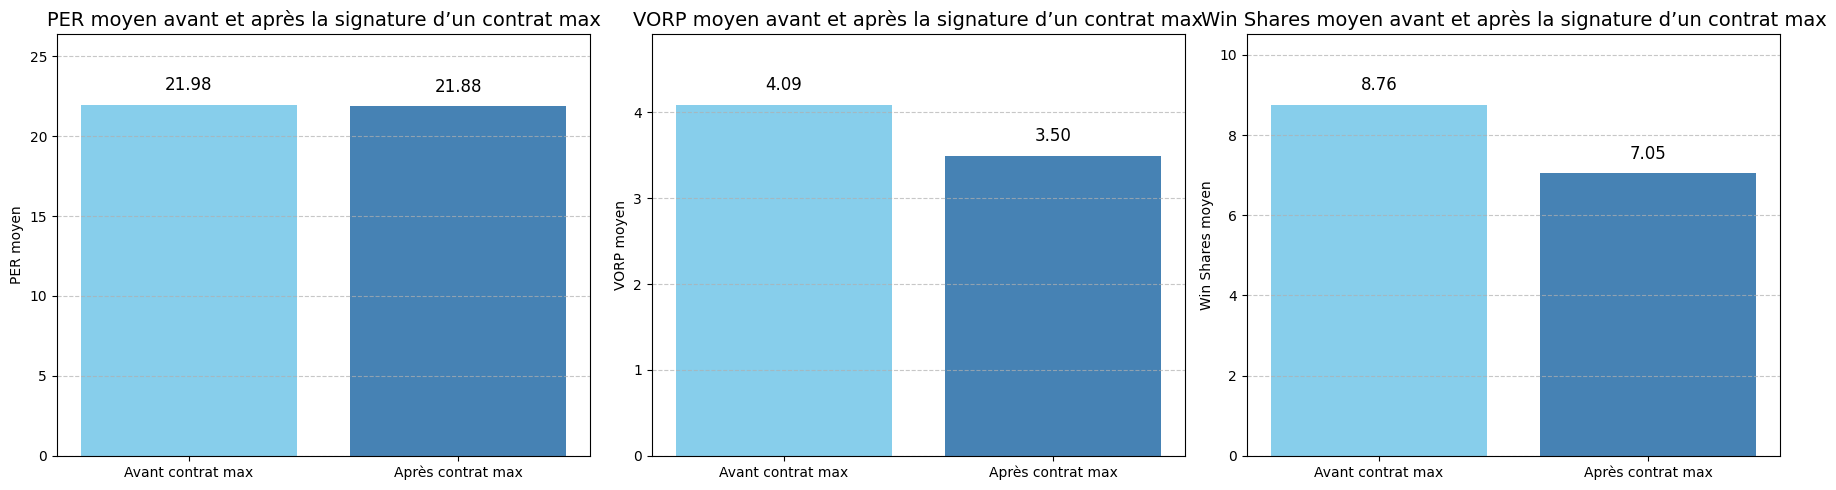

In [405]:
# Assuming df_contrat_max is already loaded and processed as in your notebook

metrics = ['PER', 'VORP', 'WS']
labels = ['Avant contrat max', 'Après contrat max']
colors = ["skyblue", "steelblue"]
metric_names = {
    'PER': 'PER',
    'VORP': 'VORP',
    'WS': 'Win Shares'
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, metric in enumerate(metrics):
    # Calculate the average for the current metric
    moyennes_metric = df_contrat_max.groupby("Apres_Contrat")[metric].mean().reset_index()
    moyennes_metric.columns = ["Apres_Contrat", f"{metric}_moyen"]
    values = moyennes_metric[f"{metric}_moyen"]

    # Plot the average metric
    axes[i].bar(labels, values, color=colors)
    axes[i].set_title(f"{metric_names[metric]} moyen avant et après la signature d’un contrat max", fontsize=14)
    axes[i].set_ylabel(f"{metric_names[metric]} moyen")
    axes[i].set_ylim(0, max(values) * 1.2) # Adjust ylim for better visualization
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

    # Add text annotations
    for j, v in enumerate(values):
        axes[i].text(j, v + (max(values) * 0.03), f"{v:.2f}", ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

###Comparaison des statistiques de SGA avec celles des contrats max à la signature de leurs contrats

In [406]:
df_stat_shai25 = df_player_stat[(df_player_stat['Player'] == 'Shai Gilgeous Alexander') & (df_player_stat['year'] == 2025)]
df_stat_shai25

,Age,G,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,TS%,WS,WS/48,BPM,VORP,Player,Player-additional,Pos,PIS,prod_plus
1456,26.0,76.0,34.2,11.3,21.8,0.519,2.1,5.7,0.375,9.2,...,0.637,16.7,0.309,11.5,8.9,Shai Gilgeous Alexander,gilgesh01,Meneur,4.49,46.8


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


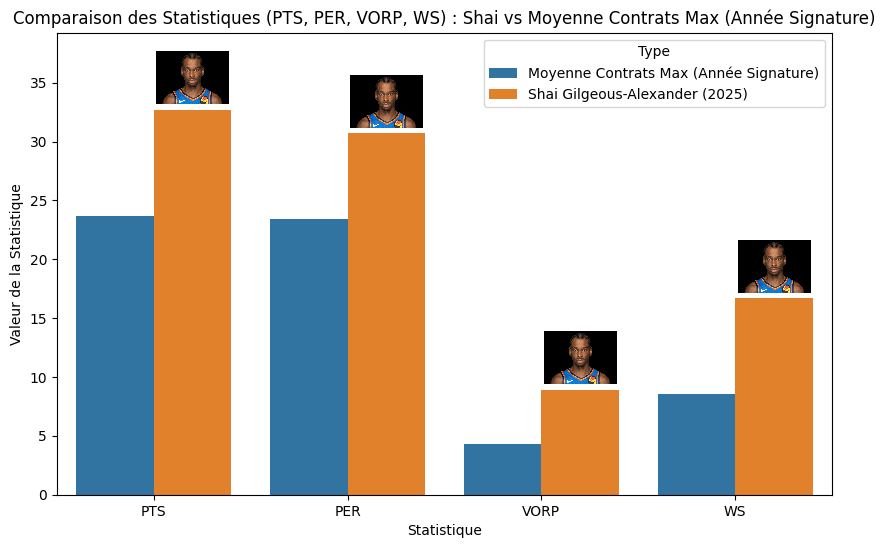

In [407]:
# 1. Calculer la moyenne des statistiques pour les joueurs à l'année de signature du contrat max
# Filtrer pour les données l'année de la signature du contrat
df_annee_signature = df_contrat_max[df_contrat_max['Season_start'] == df_contrat_max['annee_signature']]

# Calculer la moyenne des statistiques pertinentes
moyennes_contrat_max_signature = df_annee_signature[['PTS','PER', 'VORP', 'WS']].mean()

#Selection des indicateurs pour shai
stats_shai = df_stat_shai25[['PTS','PER', 'VORP', 'WS']].iloc[0]

# 3. Préparer les données pour la visualisation
# Créer un DataFrame pour les moyennes à l'année de signature
df_moyennes_signature = moyennes_contrat_max_signature.reset_index()
df_moyennes_signature.columns = ['Statistique', 'Moyenne']
df_moyennes_signature['Type'] = 'Moyenne Contrats Max (Année Signature)'

# Créer un DataFrame pour les stats de Shai
df_shai = stats_shai.reset_index()
df_shai.columns = ['Statistique', 'Valeur']
df_shai['Type'] = 'Shai Gilgeous-Alexander (2025)'

# Renommer la colonne de valeur pour correspondre au DataFrame des moyennes
df_shai = df_shai.rename(columns={'Valeur': 'Moyenne'})

# Concaténer les deux DataFrames
df_combined = pd.concat([df_moyennes_signature, df_shai])

# Charger l’image de SGA
url = "https://cdn.nba.com/headshots/nba/latest/1040x760/1628983.png"
img = Image.open(BytesIO(urllib.request.urlopen(url).read())).convert("RGB")
imgbox = OffsetImage(img, zoom=0.05)

# 4. Créer l'histogramme (graphique à barres)
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Statistique', y='Moyenne', hue='Type', data=df_combined)
plt.title('Comparaison des Statistiques (PTS, PER, VORP, WS) : Shai vs Moyenne Contrats Max (Année Signature)')
plt.ylabel('Valeur de la Statistique')
plt.xlabel('Statistique')

# Ajouter l'image au-dessus des barres de Shai
stats_graph = ['PTS', 'PER', 'VORP', 'WS']
for stat in stats_graph:
    for patch, (stat_val, type_val) in zip(ax.patches, zip(df_combined['Statistique'], df_combined['Type'])):
        if stat_val == stat and "Shai" in type_val:
            x_pos = patch.get_x() + patch.get_width() / 2.0
            y_pos = patch.get_height()

            ab = AnnotationBbox(
                imgbox, (x_pos, y_pos),
                xybox=(0, 23),
                xycoords='data',
                boxcoords="offset points",
                pad=0,
                bboxprops=dict(boxstyle="round,pad=0", fc="w", ec="none")
            )
            ax.add_artist(ab)
            break

# Ajuster la marge supérieure pour laisser de la place à l'image
ax.margins(y=0.2) # Augmenter légèrement la marge si les images sont grandes ou le décalage important

plt.show()

###Top 10 Player Impact Score à la signature comparé à celui de Shai Gilgeous Anderson

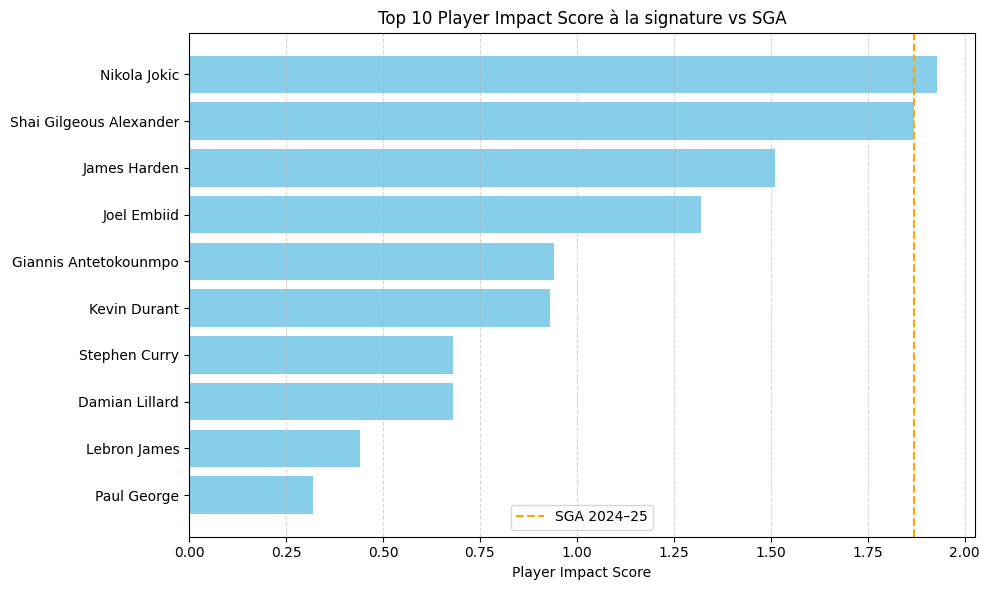

In [408]:
#Création d'un df PIS pour le graphs
df_pis = df_annee_signature[['Player','PER','VORP','WS/48']]
df_pis_shai = df_stat_shai25[['Player','PER','VORP','WS/48']]
df_pis = pd.concat([df_pis, df_pis_shai])

#On apllique la fonction de calcul du PIS pour le calculer sur les joueurs selectionnés seulement
calculate_pis(df_pis)
df_pis = df_pis.sort_values(by='PIS', ascending=False)

# On localise SGA pour ajouter une barre à son niveau dans le graph
sga_row = df_pis[df_pis["Player"].str.contains("gilgeous", case=False)]

#TOP 10 graphs
plt.figure(figsize=(10, 6))
plt.barh(df_pis["Player"].head(10)[::-1], df_pis["PIS"].head(10)[::-1], color="skyblue")
if not sga_row.empty:
    sga_score = sga_row["PIS"].values[0]
    plt.axvline(sga_score, color="orange", linestyle="--", label="SGA 2024–25")
plt.title("Top 10 Player Impact Score à la signature vs SGA")
plt.xlabel("Player Impact Score")
plt.legend()
plt.grid(True, axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


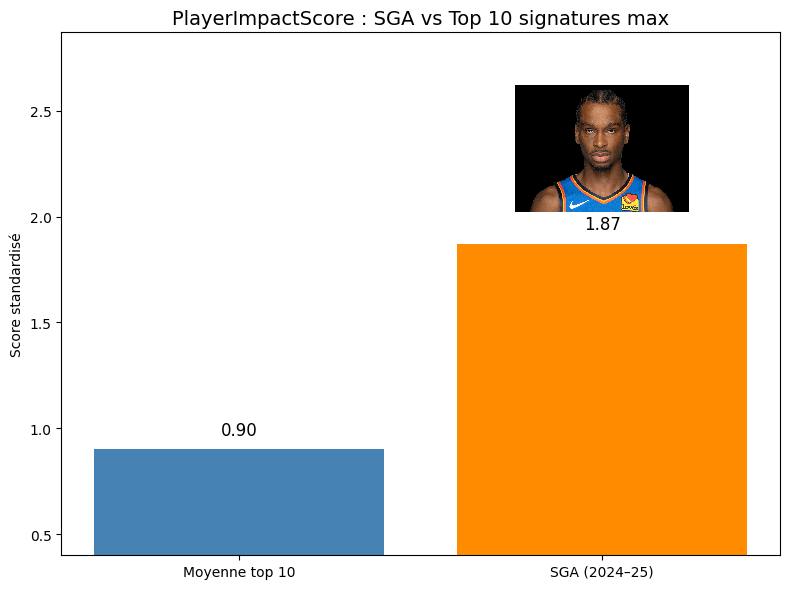

In [409]:
# 1. Calculer la moyenne du PIS pour tous les joueurs en 2025
mean_pis = df_pis[~df_pis["Player"].str.contains("gilgeous", case=False)].sort_values("PIS", ascending=False).head(10)
mean_pis = mean_pis['PIS'].mean()
# 2. Extraire le PIS de Shai pour la saison 2024-2025
# Assurez-vous que df_stat_shai25 est correctement défini et contient le PIS de Shai
# (Si vous avez déjà Shai dans df_player_stat_2025, vous pouvez l'extraire directement de là)
shai_pis_2025 = df_pis[df_pis['Player'] == 'Shai Gilgeous Alexander']['PIS'].iloc[0]

# 3. Créer un DataFrame pour le Barplot
barplot_data_mean = pd.DataFrame({
    'Catégorie': ['Moyenne PIS NBA (2025)', 'PIS Shai Gilgeous-Alexander (2025)'],
    'PIS': [mean_pis, shai_pis_2025]
})

# 9. Graphique comparatif
labels = ["Moyenne top 10", "SGA (2024–25)"]
values = [mean_pis, shai_pis_2025]

fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(labels, values, color=["steelblue", "darkorange"])
ax.set_title("PlayerImpactScore : SGA vs Top 10 signatures max", fontsize=14)
ax.set_ylabel("Score standardisé")
ax.set_ylim(min(values) - 0.5, max(values) + 1)

# Ajouter les scores sur les barres
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.05,
            f"{height:.2f}", ha="center", va="bottom", fontsize=12)

# Ajouter image SGA au-dessus de sa barre
try:
    url = "https://cdn.nba.com/headshots/nba/latest/1040x760/1628983.png"
    img = Image.open(BytesIO(urllib.request.urlopen(url).read())).convert("RGB")
    imgbox = OffsetImage(img, zoom=0.12)  # Ajuste le zoom si nécessaire
    sga_bar = bars[1]
    x = sga_bar.get_x() + sga_bar.get_width() / 2
    y = sga_bar.get_height() + 0.15
    ab = AnnotationBbox(imgbox, (x, y), frameon=False, box_alignment=(0.5, 0))
    ax.add_artist(ab)
except Exception as e:
    print("Erreur chargement image SGA:", e)


plt.tight_layout()
plt.show()
